# De Werf/Diep/Jamieson Human Pediatric AML Study in Progenitors and Hematopoietic Stem Cells 
### Progenitors
* Pediatric AML vs Adult AML
* Pediatric AML vs Pediatric Non-leukemia

### Stem Cells
* Pediatric AML vs Adult AML
* Pediatric AML vs Pediatric Non-leukemia

### Pediatric AML
* Progenitors vs Stem Cells

### Adult AML
* Progenitors vs Stem Cells


# RNASeq Differential Expression Testing and Visualization

   > * Tom Whisenant, CCBB (twhisenant@ucsd.edu)
   > * Based on upstream analysis by Guorong Xu, CCBB (g1xu@ucsd.edu)
</div>

* Modeled on "RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR" ([1](#Citations))

## Table of Contents
* [Introduction](#Introduction)
* [Parameter Input](#Parameter-Input)
* [Library Import](#Library-Import)
* [Differential Expression Testing](#Differential-Expression-Testing)
    * [Design Model Creation](#Design-Model-Creation)
    * [Contrast Creation](#Contrast-Creation)
    * [Removal of Heteroscedascity](#Removal-of-Heteroscedascity)
    * [Discussion of Statistical Treatment of Replicates](#Discussion-of-Statistical-Treatment-of-Replicates)
    * [Fitting of Linear Models](#Fitting-of-Linear-Models)
    * [Summarization of Differentially Expressed Genes](#Summarization-of-Differentially-Expressed-Genes)
* [Examination of Individual Comparisons](#Examination-of-Individual-Comparisons)

   > * [Progenitors_PedAMLvsAdultAML](#Progenitors_PedAMLvsAdultAML)
   > * [Progenitors_PedAMLvsPedNL](#Progenitors_PedAMLvsPedNL)
   > * [Stem_PedAMLvsAdultAML](#Stem_PedAMLvsAdultAML)
   > * [Stem_PedAMLvsPedNL](#Stem_PedAMLvsPedNL)
   > * [PedAML_ProgenitorsvsStem](#PedAML_ProgenitorsvsStem)
   > * [AdultAML_ProgenitorsvsStem](#AdultAML_ProgenitorsvsStem)

* [Summary](#Summary)
* [Citations](#Citations)
* [Appendix: R Session Info](#Appendix:-R-Session-Info)


## Introduction

This notebook takes in RNASeq data prepared by the previous notebook, "3_RNASeq_Data_Exploration_and_Preprocessing", and uses the limma ([2](#Citations)) and edgeR ([3](#Citations)) Bioconductor ([4](#Citations)) packages written in R ([5](#Citations)) to test for differential expression in comparisons of interest to the researcher using the voom technique ([6](#Citations)).

[Table of Contents](#Table-of-Contents)

## Parameter Input

In [1]:
gPreviousStepRdataFp =  "../interim/20200228_DeWerf_Human_PediatricAML_data_exploration_20200327141050.RData"
                          

In [2]:
gSourceDir = "/mnt/data1/tomw/RNASeq/notebooks/src/" # note trailing slash here but not below
# Import shared source code to load and save previous notebooks' environments:
source(paste0(gSourceDir, "ChainedNotebookSupport.R"))
# Import the previous step's state:
gPreviousStepEnv = loadToEnvironment(gPreviousStepRdataFp)

In [3]:
# Load relevant variables:
gProjectName = gPreviousStepEnv$gProjectName
gInterimDir = gPreviousStepEnv$gInterimDir
gOutputDir = gPreviousStepEnv$gOutputDir
gDgeList = gPreviousStepEnv$gDgeList
gGeneType = gPreviousStepEnv$gGeneType
gGeneIdCol = gPreviousStepEnv$gGeneIdCol

Populate the run name parameter automatically to ensure that outputs from different runs do not overwrite each other:

In [4]:
gRunName = makeRunName(gProjectName, "differential_expression")
gRunName

[1] "20200228_DeWerf_Human_PediatricAML_differential_expression_20200601235205"

[Table of Contents](#Table-of-Contents)

## Library Import

Import the necessary R, Bioconductor, and CCBB libraries for the analysis:

In [ ]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

In [ ]:
#BiocManager::install("limma", version = "3.8")

In [ ]:
#BiocManager::install("Glimma", version = "3.8")

In [ ]:
#install.packages("gdata")

In [ ]:
#install.packages("cowplot")

In [ ]:
#install.packages("gplots")

In [ ]:
#install.packages("statmod")

In [ ]:
#BiocManager::install("RNASeqPower", version = "3.8")

In [ ]:
#install.packages("RColorBrewer")

In [5]:
library(limma)
library(edgeR)
library(Glimma)
library(statmod)

In [6]:
library(IRdisplay)
library(RColorBrewer)

Warning message:
“package ‘IRdisplay’ was built under R version 3.4.4”

In [7]:
source(paste0(gSourceDir, "PcaPlotter.R"))
source(paste0(gSourceDir, "CountsPcaPlotter.R"))

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [8]:
# This cell supports future resizing of the plots in the Jupyter notebook
gDefaultWidth = getOption("repr.plot.width")
gDefaultHeight = getOption("repr.plot.height")
resetPlotSize = function(){
    options(repr.plot.width=gDefaultWidth, repr.plot.height=gDefaultHeight)
}

In [9]:
# This line prevents SVG output, which interacts badly with export to HTML
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

[Table of Contents](#Table-of-Contents)

## Differential Expression Testing

Conceptually, determining differential expression for a given gene between conditions of interest in experimental data is a simple matter of looking at the measured expression levels for that gene in each condition of interest and determining if they are different from each other.  For example, in case A in the plot below, the gene expression in the treated condition is clearly lower than that in the control condition:

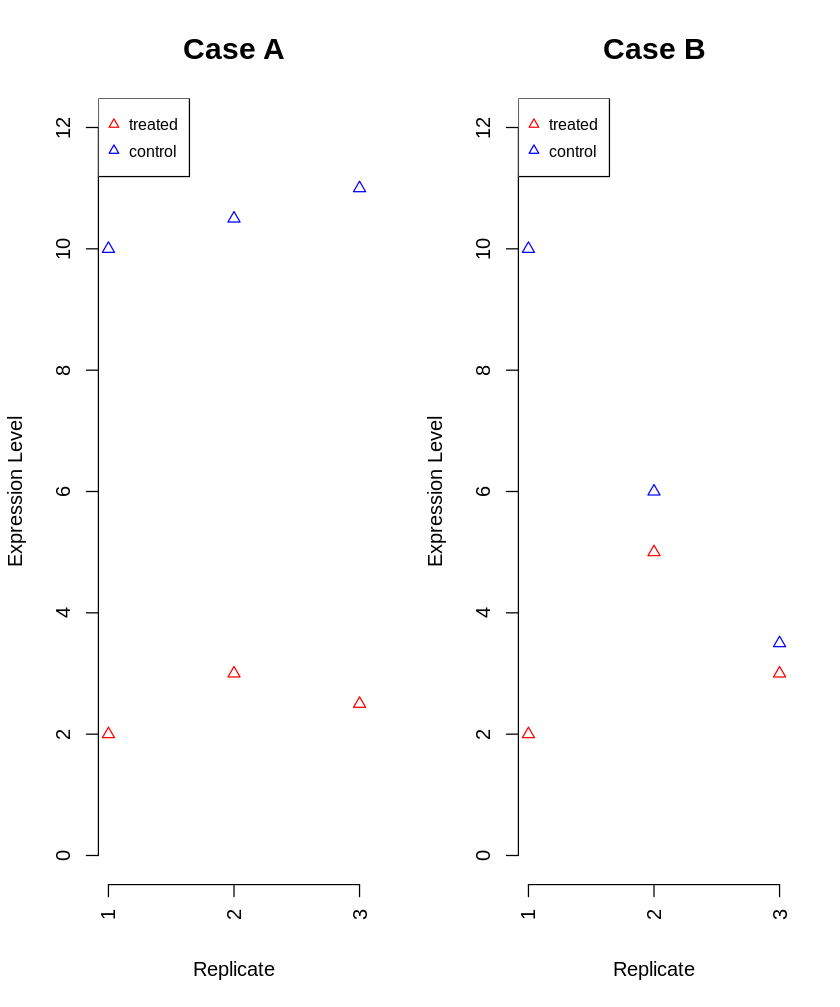

In [293]:
drawExamplePlots = function(){
    par(mfrow=c(1,2))
    
    replicate <- 1:3
    dat <- data.frame(
      x = rep(replicate,2),
      y = c(2, 3, 2.5, 10, 10.5, 11),
      treatment = c(rep("treated",3), rep("control",3))
    )
    
    drawExamplePlot(dat, "Case A")
    
    dat$y = c(2, 5, 3, 10, 6, 3.5)
    drawExamplePlot(dat, "Case B")
}

drawExamplePlot = function(dat, case){
    plot(dat$x, dat$y, xaxt="n",
         xlab="Replicate", ylab="Expression Level", 
         xlim=c(1,3), ylim=c(0,12), 
         main=case, pch=2, 
         cex.main=1.5, frame.plot=FALSE, 
         col=ifelse(dat$treatment=="treated", "red", "blue"))
    
    legend("topleft", pch=c(2,2), col=c("red", "blue"), c("treated", "control"), bty="o",  cex=.8)
    axis(1, xaxp=c(1,3,2), las=2)
}

#resize the output for attractive side-by-side plots
options(repr.plot.width=gDefaultWidth, repr.plot.height=gDefaultHeight*.7) 
drawExamplePlots()
options(repr.plot.width=gDefaultWidth, repr.plot.height=gDefaultHeight) 

However, in reality, data often look less clear-cut, like those shown in case B; therefore, instead of examining the data qualitatively, analysts apply a statistical test that integrates replicate data to calculate the degree of difference in expression level and determine if that difference is statistically significant.  In a simple experiment like that shown above, one could accomplish this with a Student's t-test, but real studies usually have a more complex experimental design.  This design may include multiple levels of a condition of interest (e.g., several different treatments), multiple factors of interest (e.g., both treatment and disease state), repeated measurements over time on the same subject, and/or batch effects or confounding variables that must be accounted for (e.g., subject age, sex, etc).  Therefore, a common technique is to use statistical tests based on linear models, which are able to appropriately estimate amount and significance of differential expression for such complex experiments (as well as for very simple ones).


### Background on Linear Models

The limma package performs differential expression testing using linear models, especially the subset of these known as simple linear regression models.  In this context, a model is simply a formula predicting a variable of interest based on some known other variables, and linear regression is the process by which we arrive at this model:

> [Simple l]inear regression is used to predict the value of a continuous variable Y based on one or more input predictor variables X. The aim is to establish a mathematical formula between the the response variable (Y) and the predictor variables (Xs). You can use this formula to predict Y, when only X values are known. ([7](#Citations))

Y is also sometimes referred to as dependent variable or the observation, and the Xs are also called independent variables. The basic format of the mathematical formula of a linear model is 

Y = B<sub>0</sub> + B<sub>1</sub>\*X<sub>1</sub> + B<sub>2</sub>\*X<sub>2</sub> + ... + B<sub>n</sub>\*X<sub>n</sub> + e

where X<sub>1 through n</sub> are the independent variables and B<sub>1 through n</sub> are their coefficients, B<sub>0</sub> is the intercept, and e is a random error.  

In the context of differential expression testing, we attempt to predict a particular gene's expression level (the independent variable Y) in a particular sample based on independent variables X from the metadata about that sample such as treatment applied, time point at which expression was assessed, sex of subject, etc. (Non-numeric independent variables are easily accommodated in this approach using "dummy variables"; see [https://en.wikipedia.org/wiki/Dummy_variable_(statistics)](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) for details).  While the formula format shown above gives the basic idea, there are in fact multiple ways to represent the independent variables in the formula (see [Design Model Creation](#Design-Model-Creation) below), and the data analyst must decide on the most appropriate format of the formula for the hypotheses being tested in a particular experiment.  
    
Once the formula format has been specified, the linear regression process takes in training data cases (where each case is a known Y value with its associated X values) and decides upon (or "fits") numeric values to the coefficients B<sub>1 through n</sub> in the formula format.  The goal is to find B<sub>1 through n</sub> values such that when one plugs the known X values for each training data case into the formula, one gets a Y value that is the same as (or at least close to!) the real Y value known from the training data.  Usually this fitting is done by least squares approximation; see [https://en.wikipedia.org/wiki/Least_squares](https://en.wikipedia.org/wiki/Least_squares) for further details on this process.

In differential expression analysis, the experimental data are used as the training cases: the observations of a given gene's read counts in the experimental samples are the Y values, while the metadata for each sample are the X values. limma fits one linear model for EACH gene; all models share the same formula *format* but each has its own gene-specific *coefficients*, one for each independent variable; each of these coefficients also has an estimate of its standard deviation. 

To determine whether a particular independent variable affects the expression level of a given gene, it is simply necessary to perform a t-test to determine whether the coefficient for that variable is statistically significantly different from zero.  limma performs this test based on a "moderated" t-statistic:

> This has the same interpretation as an ordinary t-statistic except that the standard errors have been
moderated across genes, i.e., squeezed towards a common value, using a simple Bayesian model.
This has the effect of borrowing information from the ensemble of genes to aid with inference about
each individual gene[.] ([8](#Citations))

The coefficients can, if necessary, be processed into "contrasts" (see [Contrast Creation](#Contrast-Creation) below) to that can be similarly tested to see if they differ from zero in order to address questions about, for example, whether two conditions affect a gene's expression *differently*.

### Design Model Creation

The formula format used in the linear model fitting is specified by a design model.  In limma, this is represented as a matrix in which each row is a sample in the experiment and each column is a representation of a dependent variable; due to the use of dummy variables, one dependent variable may be represented by more than one column.

In [12]:
gOrigNormedFilteredDgeList <- gPreviousStepEnv$gOrigNormedFilteredDgeList
gOrigNormedFilteredDgeList.prog <- gPreviousStepEnv$gOrigNormedFilteredDgeList.prog
gOrigNormedFilteredDgeList.stem <- gPreviousStepEnv$gOrigNormedFilteredDgeList.stem
head(gOrigNormedFilteredDgeList$samples)
gOrigNormedFilteredDgeList.prog$samples
head(gOrigNormedFilteredDgeList.stem$samples)

group  lib.size norm.factors
01id38cellHSC         PedAML 41053037 1.0202671   
02id38cellPROGENITORS PedAML 33880305 0.9970015   
cell05id90HSC         PedAML 32756184 0.9893871   
06id90cellPROGENITORS PedAML 33202985 0.8548814   
03id78cellHSC         PedAML 28605524 0.8076966   
04id78cellPROGENITORS PedAML 41632102 0.9348678   
                      SequenceRun                                               
01id38cellHSC         ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
02id38cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
cell05id90HSC         ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
06id90cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
03id78cellHSC         ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
04id78cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
                      SequenceDate Sample                SampleName    
01id38cellHSC         5/5/19       01id38cellHSC         38 HSC        
02id38cellPROGENITORS 5/5/19       02id38cellPROGENITORS 38 Progenitors
cell05id90HSC         5/5/19       cell05id90HSC         90 HSC        
06id90cellPROGENITORS 5/5/19       06id90cellPROGENITORS 90 Progenitors
03id78cellHSC         5/5/19       03id78cellHSC         78 HSC        
04id78cellPROGENITORS 5/5/19       04id78cellPROGENITORS 78 Progenitors
                      Patient.ID RIN  X      Adult.Pediatric Disease Cell.type
01id38cellHSC         32538      10.0 PedAML Pediatric       AML     Stem     
02id38cellPROGENITORS 32538       9.7 PedAML Pediatric       AML     Prog     
cell05id90HSC         22390      10.0 PedAML Pediatric       AML     Stem     
06id90cellPROGENITORS 22390      10.0 PedAML Pediatric       AML     Prog     
03id78cellHSC         28678      10.0 PedAML Pediatric       AML     Stem     
04id78cellPROGENITORS 28678      10.0 PedAML Pediatric       AML     Prog     
                      Sorted.Cell.Type Tissue.Source RNA.seq.status Reads   
01id38cellHSC         34+38-           PB            Completed      81234305
02id38cellPROGENITORS 34+38+           PB            Completed      73196851
cell05id90HSC         34+38-           BM            Completed      72625632
06id90cellPROGENITORS 34+38+           BM            Completed      81721991
03id78cellHSC         34+38-           PB            Completed      68483294
04id78cellPROGENITORS 34+38+           PB            Completed      88894032

group    lib.size norm.factors
02id38cellPROGENITORS PedAML   33857287 0.9828611   
06id90cellPROGENITORS PedAML   33182123 0.8321179   
04id78cellPROGENITORS PedAML   41582383 0.9294246   
06id00066PRO          PedAML   30046504 1.1581854   
01x00077xPROGENIT     PedAML   29106100 0.9036754   
03x11379xHPCxxxxx     PedAML   42324440 1.0968453   
05x00047xPLUSPLUS     PedNL    36940541 1.0731430   
06x00077xPLUSPLUS     PedNL    62232722 1.3090993   
07x00023xPLUSPLUS     AdultAML 33543583 1.0523582   
09x00020xPLUSPLUS     AdultAML 30976974 0.8527408   
11x00082xPLUSPLUS     AdultAML 47115589 0.5442266   
14x12488xPLUSPLUS     PedAML   47728459 1.1816605   
15x12584xPLUSPLUS     PedAML   38153804 0.7768948   
17x12451xPLUSPLUS     PedAML   40808630 0.9092180   
18x10720xPLUSPLUS     PedNL    44019600 1.2340483   
02pid24760ctHPC       PedNL    45329818 1.2515420   
04pid24474ctHPC       PedNL    43151631 1.0659681   
06pid25376ctHPC       PedNL    47413103 1.2154517   
                      SequenceRun                                               
02id38cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
06id90cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
04id78cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
06id00066PRO          ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91
01x00077xPROGENIT     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
03x11379xHPCxxxxx     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
05x00047xPLUSPLUS     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
06x00077xPLUSPLUS     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
07x00023xPLUSPLUS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
09x00020xPLUSPLUS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
11x00082xPLUSPLUS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
14x12488xPLUSPLUS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
15x12584xPLUSPLUS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
17x12451xPLUSPLUS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
18x10720xPLUSPLUS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
02pid24760ctHPC       ca_ne_714_001_400_070_JAMIESON_SN_human-ensembl-grch38-r91
04pid24474ctHPC       ca_ne_714_001_400_070_JAMIESON_SN_human-ensembl-grch38-r91
06pid25376ctHPC       ca_ne_714_001_400_070_JAMIESON_SN_human-ensembl-grch38-r91
                      SequenceDate Sample                SampleName    
02id38cellPROGENITORS 5/5/19       02id38cellPROGENITORS 38 Progenitors
06id90cellPROGENITORS 5/5/19       06id90cellPROGENITORS 90 Progenitors
04id78cellPROGENITORS 5/5/19       04id78cellPROGENITORS 78 Progenitors
06id00066PRO          6/26/19      06id00066PRO          66 Progenitors
01x00077xPROGENIT     8/31/19      01x00077xPROGENIT     77 Progenitors
03x11379xHPCxxxxx     8/31/19      03x11379xHPCxxxxx     11379 HPC     
05x00047xPLUSPLUS     8/31/19      05x00047xPLUSPLUS     47 PlPl       
06x00077xPLUSPLUS     8/31/19      06x00077xPLUSPLUS     77 PlPl       
07x00023xPLUSPLUS     8/31/19      07x00023xPLUSPLUS     23 PlPl       
09x00020xPLUSPLUS     8/31/19      09x00020xPLUSPLUS     20 PlPl       
11x00082xPLUSPLUS     8/31/19      11x00082xPLUSPLUS     82 PlPl       
14x12488xPLUSPLUS     9/1/19       14x12488xPLUSPLUS     12488 PlPl    
15x12584xPLUSPLUS     9/1/19       15x12584xPLUSPLUS     12584 PlPl    
17x12451xPLUSPLUS     9/1/19       17x12451xPLUSPLUS     12451 PlPl    
18x10720xPLUSPLUS     9/1/19       18x10720xPLUSPLUS     10720 PlPl    
02pid24760ctHPC       12/19/19     02pid24760ctHPC       24760 HPC     
04pid24474ctHPC       12/19/19     04pid24474ctHPC       24474 HPC     
06pid25376ctHPC       12/19/19     06pid25376ctHPC       25376 HPC     
                      Patient.ID RIN  X        Adult.Pediatric Disease     
02id38cellPROGENITORS 32538     

group    lib.size norm.factors
01id38cellHSC PedAML   40985758 1.0790622   
cell05id90HSC PedAML   32672214 1.0238805   
03id78cellHSC PedAML   28583557 0.8103577   
05id00066HSC  PedAML   15869122 1.2862798   
04id11474HSC  AdultAML 25449852 1.1381900   
02id11251HSC  AdultAML 21994123 0.9289837   
              SequenceRun                                               
01id38cellHSC ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
cell05id90HSC ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
03id78cellHSC ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
05id00066HSC  ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91
04id11474HSC  ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91
02id11251HSC  ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91
              SequenceDate Sample        SampleName Patient.ID RIN  X       
01id38cellHSC 5/5/19       01id38cellHSC 38 HSC     32538      10.0 PedAML  
cell05id90HSC 5/5/19       cell05id90HSC 90 HSC     22390      10.0 PedAML  
03id78cellHSC 5/5/19       03id78cellHSC 78 HSC     28678      10.0 PedAML  
05id00066HSC  6/26/19      05id00066HSC  66 HSC     22666       7.7 PedAML  
04id11474HSC  6/26/19      04id11474HSC  11474 HSC  11474      10.0 AdultAML
02id11251HSC  6/26/19      02id11251HSC  11251 HSC  11251       9.3 AdultAML
              Adult.Pediatric Disease Cell.type Sorted.Cell.Type Tissue.Source
01id38cellHSC Pediatric       AML     Stem      34+38-           PB           
cell05id90HSC Pediatric       AML     Stem      34+38-           BM           
03id78cellHSC Pediatric       AML     Stem      34+38-           PB           
05id00066HSC  Pediatric       AML     Stem      34+38-           BM           
04id11474HSC  Adult           AML     Stem      34+38-           PB           
02id11251HSC  Adult           AML     Stem      34+38-           BM           
              RNA.seq.status Reads   
01id38cellHSC Completed      81234305
cell05id90HSC Completed      72625632
03id78cellHSC Completed      68483294
05id00066HSC  Completed      77519907
04id11474HSC  Completed      79123032
02id11251HSC  Completed      81776486

## Filter for samples paired by cell type by patient
### Patients
#### Pediatric AML

* 32538
* 22390
* 28678
* 22666
* 11379
* 12488
* 12451
* 12584

#### Adult AML

* 11220
* 12682
* 11251
* 11474


In [13]:
paired_patients <- c("32538", "22390", "28678", "22666", "11379", "12488", "12451", 
                    "11220", "12682")
gOrigNormedFilteredDgeList.paired <- gOrigNormedFilteredDgeList[,gOrigNormedFilteredDgeList$samples$Patient.ID %in% paired_patients,]
dim(gOrigNormedFilteredDgeList.paired$counts)
dim(gOrigNormedFilteredDgeList.paired$samples)
gOrigNormedFilteredDgeList.paired$samples

[1] 12685    18

[1] 18 17

group    lib.size norm.factors
01id38cellHSC         PedAML   41053037 1.0202671   
02id38cellPROGENITORS PedAML   33880305 0.9970015   
cell05id90HSC         PedAML   32756184 0.9893871   
06id90cellPROGENITORS PedAML   33202985 0.8548814   
03id78cellHSC         PedAML   28605524 0.8076966   
04id78cellPROGENITORS PedAML   41632102 0.9348678   
05id00066HSC          PedAML   15897883 1.2330452   
06id00066PRO          PedAML   30068212 1.1915671   
02x11379xHSCxxxxx     PedAML   44517357 0.9775678   
03x11379xHPCxxxxx     PedAML   42376854 1.0921071   
08x00020xPLUSMINS     AdultAML 26345499 0.8950048   
09x00020xPLUSPLUS     AdultAML 31010641 0.9014299   
10x00082xPLUSMINS     AdultAML 24628569 0.6008237   
11x00082xPLUSPLUS     AdultAML 47169149 0.5887577   
13x12488xPLUSMINS     PedAML   30635171 1.0557870   
14x12488xPLUSPLUS     PedAML   47756012 1.1716522   
16x12451xPLUSMINS     PedAML   22336931 0.8634050   
17x12451xPLUSPLUS     PedAML   40838428 0.9162113   
                      SequenceRun                                               
01id38cellHSC         ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
02id38cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
cell05id90HSC         ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
06id90cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
03id78cellHSC         ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
04id78cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
05id00066HSC          ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91
06id00066PRO          ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91
02x11379xHSCxxxxx     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
03x11379xHPCxxxxx     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
08x00020xPLUSMINS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
09x00020xPLUSPLUS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
10x00082xPLUSMINS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
11x00082xPLUSPLUS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
13x12488xPLUSMINS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
14x12488xPLUSPLUS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
16x12451xPLUSMINS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
17x12451xPLUSPLUS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
                      SequenceDate Sample                SampleName    
01id38cellHSC         5/5/19       01id38cellHSC         38 HSC        
02id38cellPROGENITORS 5/5/19       02id38cellPROGENITORS 38 Progenitors
cell05id90HSC         5/5/19       cell05id90HSC         90 HSC        
06id90cellPROGENITORS 5/5/19       06id90cellPROGENITORS 90 Progenitors
03id78cellHSC         5/5/19       03id78cellHSC         78 HSC        
04id78cellPROGENITORS 5/5/19       04id78cellPROGENITORS 78 Progenitors
05id00066HSC          6/26/19      05id00066HSC          66 HSC        
06id00066PRO          6/26/19      06id00066PRO          66 Progenitors
02x11379xHSCxxxxx     8/31/19      02x11379xHSCxxxxx     11379 HSC     
03x11379xHPCxxxxx     8/31/19      03x11379xHPCxxxxx     11379 HPC     
08x00020xPLUSMINS     8/31/19      08x00020xPLUSMINS     20 PlMn       
09x00020xPLUSPLUS     8/31/19      09x00020xPLUSPLUS     20 PlPl       
10x00082xPLUSMINS     8/31/19      10x00082xPLUSMINS     82 PlMn       
11x00082xPLUSPLUS     8/31/19      11x00082xPLUSPLUS     82 PlPl       
13x12488xPLUSMINS     9/1/19       13x12488xPLUSMINS     12488 PlMn    
14x12488xPLUSPLUS     9/1/19       14x12488xPLUSPLUS     12488 PlPl    
16x12451xPLUSMINS     9/1/19       16x12451xPLUSMINS     12451 PlMn    
17x12451xPLUSPLUS     9/1/19       17x12451xPLUSPLUS     12451 PlPl    
                      Patient.ID RIN  X        Adult.Pediatric Disease
01id38cellHSC         32538      10.0

<div class="alert alert-warning">
    <strong>Analyst Note: Prepare </strong><br />
    
**Decide upon the appropriate design model matrix for this particular project**, which will be based on the metadata collected (see `gNormedFilteredDgeList$samples`, shown above) and upon the comparisons the researcher wishes to test! 

Examine the "Single-Channel Experimental Designs" chapter of the Limma user's guide [http://www.bioconductor.org/packages/release/bioc/vignettes/limma/inst/doc/usersguide.pdf](http://www.bioconductor.org/packages/release/bioc/vignettes/limma/inst/doc/usersguide.pdf) for many examples.  Note that if the study involves repeated measurements (such as time course data on patients, or technical replicates of samples), this element should almost certainly be modeled as a random effect via the `duplicateCorrelation` function, rather than as a fixed effect via a column in the design matrix.  See [https://web.ma.utexas.edu/users/mks/statmistakes/fixedvsrandom.html](https://web.ma.utexas.edu/users/mks/statmistakes/fixedvsrandom.html) for a discussion of fixed versus random effects, and see https://support.bioconductor.org/p/90460/ for an example of a realistic experimental design modeled in limma using both fixed and random effects.

<br />
    
Recall that a model matrix can either be created manually or can be created via the R command `model.matrix` (see [https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/model.matrix](https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/model.matrix) for details) based on an input formula.  See the "Formula Recap" section at [http://conjugateprior.org/2013/01/formulae-in-r-anova/](http://conjugateprior.org/2013/01/formulae-in-r-anova/) or the "Details" section at [https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/formula](https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/formula) for refreshers on formula syntax. Per [http://www.stat.wisc.edu/~st849-1/Rnotes/ModelMatrices.html](http://www.stat.wisc.edu/~st849-1/Rnotes/ModelMatrices.html), "[n]ote that we can use a one-sided formula because we don't need to know the response to be able to determine the model matrix. A two-sided formula also works as the left-hand side is ignored."

</div>

## Design model 

### Primary factor
* group

### Secondary factor 
* Cell type
* Sequence Date

### Secondary factor, paired
* Patient

In [12]:
table(gOrigNormedFilteredDgeList$sample$X, gOrigNormedFilteredDgeList$sample$Cell.type)
gOrigNormedFilteredDgeList$sample


          
           Prog Stem
  AdultAML    3    4
  PedAML      9    8
  PedNL       6    3

group    lib.size norm.factors
01id38cellHSC         PedAML   41053037 1.0202671   
02id38cellPROGENITORS PedAML   33880305 0.9970015   
cell05id90HSC         PedAML   32756184 0.9893871   
06id90cellPROGENITORS PedAML   33202985 0.8548814   
03id78cellHSC         PedAML   28605524 0.8076966   
04id78cellPROGENITORS PedAML   41632102 0.9348678   
05id00066HSC          PedAML   15897883 1.2330452   
06id00066PRO          PedAML   30068212 1.1915671   
04id11474HSC          AdultAML 25477749 1.1069966   
02id11251HSC          AdultAML 22018607 0.9153723   
01x00077xPROGENIT     PedAML   29159791 0.9261589   
02x11379xHSCxxxxx     PedAML   44517357 0.9775678   
03x11379xHPCxxxxx     PedAML   42376854 1.0921071   
04x00068xPLUSMINS     PedAML   24523885 1.0262421   
05x00047xPLUSPLUS     PedNL    36975152 1.0981341   
06x00077xPLUSPLUS     PedNL    62282036 1.3389970   
07x00023xPLUSPLUS     AdultAML 33570341 1.0632128   
08x00020xPLUSMINS     AdultAML 26345499 0.8950048   
09x00020xPLUSPLUS     AdultAML 31010641 0.9014299   
10x00082xPLUSMINS     AdultAML 24628569 0.6008237   
11x00082xPLUSPLUS     AdultAML 47169149 0.5887577   
13x12488xPLUSMINS     PedAML   30635171 1.0557870   
14x12488xPLUSPLUS     PedAML   47756012 1.1716522   
15x12584xPLUSPLUS     PedAML   38174880 0.8061633   
16x12451xPLUSMINS     PedAML   22336931 0.8634050   
17x12451xPLUSPLUS     PedAML   40838428 0.9162113   
18x10720xPLUSPLUS     PedNL    44050519 1.2411723   
01pid24760ctHSC       PedNL    39200447 1.2604137   
02pid24760ctHPC       PedNL    45367079 1.2707824   
03pid24474ctHSC       PedNL    29555510 0.9468970   
04pid24474ctHPC       PedNL    43180329 1.1008048   
05pid25376ctHSC       PedNL    15552716 1.1397932   
06pid25376ctHPC       PedNL    47442458 1.2256625   
                      SequenceRun                                               
01id38cellHSC         ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
02id38cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
cell05id90HSC         ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
06id90cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
03id78cellHSC         ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
04id78cellPROGENITORS ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91
05id00066HSC          ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91
06id00066PRO          ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91
04id11474HSC          ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91
02id11251HSC          ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91
01x00077xPROGENIT     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
02x11379xHSCxxxxx     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
03x11379xHPCxxxxx     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
04x00068xPLUSMINS     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
05x00047xPLUSPLUS     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
06x00077xPLUSPLUS     ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91
07x00023xPLUSPLUS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
08x00020xPLUSMINS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
09x00020xPLUSPLUS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
10x00082xPLUSMINS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
11x00082xPLUSPLUS     ca_ne_645_001_300_060_JAMIESON_SN_human-ensembl-grch38-r91
13x12488xPLUSMINS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
14x12488xPLUSPLUS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
15x12584xPLUSPLUS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
16x12451xPLUSMINS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
17x12451xPLUSPLUS     ca_ne_650_001_360_060_JAMIESON_SN_human-ensembl-grch38-r91
18x10720xPLUSPLUS     ca_ne_650_0

In [14]:
gOrigNormedFilteredDgeList$samples$Phenotype <- mapply(paste, gOrigNormedFilteredDgeList$samples$X, gOrigNormedFilteredDgeList$samples$Cell.type, sep="." )
gOrigNormedFilteredDgeList.paired$samples$Phenotype <- mapply(paste, gOrigNormedFilteredDgeList.paired$samples$X, gOrigNormedFilteredDgeList.paired$samples$Cell.type, sep="." )

In [15]:
generateGroupMeansDesignModel = function(designDf){

    design_levels.prim <- designDf[["group"]]
    unique_levels.prim <- unique(design_levels.prim)
    design_levels.sec <- paste0("x", designDf[["SequenceDate"]])
    unique_levels.sec <- unique(design_levels.sec)
    f.prim = factor(design_levels.prim, levels=unique_levels.prim)
    f.sec = factor(design_levels.sec, levels=unique_levels.sec)
    #designModel = model.matrix(~0 + f.prim + f.sec)
    designModel = model.matrix(~0 + f.prim)
    rownames(designModel) = designDf[["Sample"]] # or potentially rownames(designDf)
    colnames(designModel) = gsub("f.prim|f.sec", "", gsub("/", "", colnames(designModel)))

    return(designModel)
}

generateGroupMeansDesignModel2 = function(designDf){

    design_levels.prim <- designDf[["Phenotype"]]
    unique_levels.prim <- unique(design_levels.prim)
    design_levels.sec <- paste0("X", designDf[["SequenceDate"]])
    unique_levels.sec <- unique(design_levels.sec)
    f.prim = factor(design_levels.prim, levels=unique_levels.prim)
    f.sec = factor(design_levels.sec, levels=unique_levels.sec)
    designModel = model.matrix(~0 + f.prim + f.sec)
    #designModel = model.matrix(~0 + f.prim)
    rownames(designModel) = designDf[["Sample"]] # or potentially rownames(designDf)
    colnames(designModel) = gsub("f.prim|f.sec", "", gsub("/", "", colnames(designModel)))

    return(designModel)
}

generateGroupMeansDesignModel3 = function(designDf){

    design_levels.prim <- designDf[["Phenotype"]]
    unique_levels.prim <- unique(design_levels.prim)
    design_levels.sec <- paste0("X", designDf[["Patient.ID"]])
    unique_levels.sec <- unique(design_levels.sec)
    f.prim = factor(design_levels.prim, levels=unique_levels.prim)
    f.sec = factor(design_levels.sec, levels=unique_levels.sec)
    designModel = model.matrix(~0 + f.prim + f.sec)
    #designModel = model.matrix(~0 + f.prim + f.sec)
    rownames(designModel) = designDf[["Sample"]] # or potentially rownames(designDf)
    colnames(designModel) = gsub("f.prim|f.sec", "", gsub("/", "", colnames(designModel)))

    return(designModel)
}


In [16]:
gDesignModel = generateGroupMeansDesignModel2(gOrigNormedFilteredDgeList$samples)
gDesignModel
gDesignModel.paired.nocor = generateGroupMeansDesignModel3(gOrigNormedFilteredDgeList.paired$samples)
gDesignModel.paired.nocor
gDesignModel.paired = generateGroupMeansDesignModel2(gOrigNormedFilteredDgeList.paired$samples)
gDesignModel.paired
gDesignModel.prog = generateGroupMeansDesignModel(gOrigNormedFilteredDgeList.prog$samples)
gDesignModel.prog
gDesignModel.stem = generateGroupMeansDesignModel(gOrigNormedFilteredDgeList.stem$samples)
gDesignModel.stem

PedAML.Stem PedAML.Prog AdultAML.Stem PedNL.Prog
01id38cellHSC         1           0           0             0         
02id38cellPROGENITORS 0           1           0             0         
cell05id90HSC         1           0           0             0         
06id90cellPROGENITORS 0           1           0             0         
03id78cellHSC         1           0           0             0         
04id78cellPROGENITORS 0           1           0             0         
05id00066HSC          1           0           0             0         
06id00066PRO          0           1           0             0         
04id11474HSC          0           0           1             0         
02id11251HSC          0           0           1             0         
01x00077xPROGENIT     0           1           0             0         
02x11379xHSCxxxxx     1           0           0             0         
03x11379xHPCxxxxx     0           1           0             0         
04x00068xPLUSMINS     1           0           0             0         
05x00047xPLUSPLUS     0           0           0             1         
06x00077xPLUSPLUS     0           0           0             1         
07x00023xPLUSPLUS     0           0           0             0         
08x00020xPLUSMINS     0           0           1             0         
09x00020xPLUSPLUS     0           0           0             0         
10x00082xPLUSMINS     0           0           1             0         
11x00082xPLUSPLUS     0           0           0             0         
13x12488xPLUSMINS     1           0           0             0         
14x12488xPLUSPLUS     0           1           0             0         
15x12584xPLUSPLUS     0           1           0             0         
16x12451xPLUSMINS     1           0           0             0         
17x12451xPLUSPLUS     0           1           0             0         
18x10720xPLUSPLUS     0           0           0             1         
01pid24760ctHSC       0           0           0             0         
02pid24760ctHPC       0           0           0             1         
03pid24474ctHSC       0           0           0             0         
04pid24474ctHPC       0           0           0             1         
05pid25376ctHSC       0           0           0             0         
06pid25376ctHPC       0           0           0             1         
                      AdultAML.Prog PedNL.Stem X62619 X83119 X9119 X121919
01id38cellHSC         0             0          0      0      0     0      
02id38cellPROGENITORS 0             0          0      0      0     0      
cell05id90HSC         0             0          0      0      0     0      
06id90cellPROGENITORS 0             0          0      0      0     0      
03id78cellHSC         0             0          0      0      0     0      
04id78cellPROGENITORS 0             0          0      0      0     0      
05id00066HSC          0             0          1      0      0     0      
06id00066PRO          0             0          1      0      0     0      
04id11474HSC          0             0          1      0      0     0      
02id11251HSC          0             0          1      0      0     0      
01x00077xPROGENIT     0             0          0      1      0     0      
02x11379xHSCxxxxx     0             0          0      1      0     0      
03x11379xHPCxxxxx     0             0          0      1      0     0      
04x00068xPLUSMINS     0             0          0      1      0     0      
05x00047xPLUSPLUS     0             0          0      1      0     0      
06x00077xPLUSPLUS     0             0          0      1      0     0      
07x00023xPLUSPLUS     1             0          0      1      0     0      
08x00020xPLUSMINS     0             0          0      1      0     0      
09x00020xPLUSPLUS     1             0          0      1      0     0      
10x00082xPLUSMINS     0             0          0      1      0     0      
11x00082xPLUSPLUS     1          

PedAML.Stem PedAML.Prog AdultAML.Stem AdultAML.Prog
01id38cellHSC         1           0           0             0            
02id38cellPROGENITORS 0           1           0             0            
cell05id90HSC         1           0           0             0            
06id90cellPROGENITORS 0           1           0             0            
03id78cellHSC         1           0           0             0            
04id78cellPROGENITORS 0           1           0             0            
05id00066HSC          1           0           0             0            
06id00066PRO          0           1           0             0            
02x11379xHSCxxxxx     1           0           0             0            
03x11379xHPCxxxxx     0           1           0             0            
08x00020xPLUSMINS     0           0           1             0            
09x00020xPLUSPLUS     0           0           0             1            
10x00082xPLUSMINS     0           0           1             0            
11x00082xPLUSPLUS     0           0           0             1            
13x12488xPLUSMINS     1           0           0             0            
14x12488xPLUSPLUS     0           1           0             0            
16x12451xPLUSMINS     1           0           0             0            
17x12451xPLUSPLUS     0           1           0             0            
                      X22390 X28678 X22666 X11379 X11220 X12682 X12488 X12451
01id38cellHSC         0      0      0      0      0      0      0      0     
02id38cellPROGENITORS 0      0      0      0      0      0      0      0     
cell05id90HSC         1      0      0      0      0      0      0      0     
06id90cellPROGENITORS 1      0      0      0      0      0      0      0     
03id78cellHSC         0      1      0      0      0      0      0      0     
04id78cellPROGENITORS 0      1      0      0      0      0      0      0     
05id00066HSC          0      0      1      0      0      0      0      0     
06id00066PRO          0      0      1      0      0      0      0      0     
02x11379xHSCxxxxx     0      0      0      1      0      0      0      0     
03x11379xHPCxxxxx     0      0      0      1      0      0      0      0     
08x00020xPLUSMINS     0      0      0      0      1      0      0      0     
09x00020xPLUSPLUS     0      0      0      0      1      0      0      0     
10x00082xPLUSMINS     0      0      0      0      0      1      0      0     
11x00082xPLUSPLUS     0      0      0      0      0      1      0      0     
13x12488xPLUSMINS     0      0      0      0      0      0      1      0     
14x12488xPLUSPLUS     0      0      0      0      0      0      1      0     
16x12451xPLUSMINS     0      0      0      0      0      0      0      1     
17x12451xPLUSPLUS     0      0      0      0      0      0      0      1

PedAML.Stem PedAML.Prog AdultAML.Stem AdultAML.Prog
01id38cellHSC         1           0           0             0            
02id38cellPROGENITORS 0           1           0             0            
cell05id90HSC         1           0           0             0            
06id90cellPROGENITORS 0           1           0             0            
03id78cellHSC         1           0           0             0            
04id78cellPROGENITORS 0           1           0             0            
05id00066HSC          1           0           0             0            
06id00066PRO          0           1           0             0            
02x11379xHSCxxxxx     1           0           0             0            
03x11379xHPCxxxxx     0           1           0             0            
08x00020xPLUSMINS     0           0           1             0            
09x00020xPLUSPLUS     0           0           0             1            
10x00082xPLUSMINS     0           0           1             0            
11x00082xPLUSPLUS     0           0           0             1            
13x12488xPLUSMINS     1           0           0             0            
14x12488xPLUSPLUS     0           1           0             0            
16x12451xPLUSMINS     1           0           0             0            
17x12451xPLUSPLUS     0           1           0             0            
                      X62619 X83119 X9119
01id38cellHSC         0      0      0    
02id38cellPROGENITORS 0      0      0    
cell05id90HSC         0      0      0    
06id90cellPROGENITORS 0      0      0    
03id78cellHSC         0      0      0    
04id78cellPROGENITORS 0      0      0    
05id00066HSC          1      0      0    
06id00066PRO          1      0      0    
02x11379xHSCxxxxx     0      1      0    
03x11379xHPCxxxxx     0      1      0    
08x00020xPLUSMINS     0      1      0    
09x00020xPLUSPLUS     0      1      0    
10x00082xPLUSMINS     0      1      0    
11x00082xPLUSPLUS     0      1      0    
13x12488xPLUSMINS     0      0      1    
14x12488xPLUSPLUS     0      0      1    
16x12451xPLUSMINS     0      0      1    
17x12451xPLUSPLUS     0      0      1

PedAML PedNL AdultAML
02id38cellPROGENITORS 1      0     0       
06id90cellPROGENITORS 1      0     0       
04id78cellPROGENITORS 1      0     0       
06id00066PRO          1      0     0       
01x00077xPROGENIT     1      0     0       
03x11379xHPCxxxxx     1      0     0       
05x00047xPLUSPLUS     0      1     0       
06x00077xPLUSPLUS     0      1     0       
07x00023xPLUSPLUS     0      0     1       
09x00020xPLUSPLUS     0      0     1       
11x00082xPLUSPLUS     0      0     1       
14x12488xPLUSPLUS     1      0     0       
15x12584xPLUSPLUS     1      0     0       
17x12451xPLUSPLUS     1      0     0       
18x10720xPLUSPLUS     0      1     0       
02pid24760ctHPC       0      1     0       
04pid24474ctHPC       0      1     0       
06pid25376ctHPC       0      1     0

PedAML AdultAML PedNL
01id38cellHSC     1      0        0    
cell05id90HSC     1      0        0    
03id78cellHSC     1      0        0    
05id00066HSC      1      0        0    
04id11474HSC      0      1        0    
02id11251HSC      0      1        0    
02x11379xHSCxxxxx 1      0        0    
04x00068xPLUSMINS 1      0        0    
08x00020xPLUSMINS 0      1        0    
10x00082xPLUSMINS 0      1        0    
13x12488xPLUSMINS 1      0        0    
16x12451xPLUSMINS 1      0        0    
01pid24760ctHSC   0      0        1    
03pid24474ctHSC   0      0        1    
05pid25376ctHSC   0      0        1

[Table of Contents](#Table-of-Contents)

### Contrast Creation

Depending on how the design model is defined, its terms may not always directly address the group comparisons of interest.  Therefore, it is possible to define "contrasts", or differences of terms.  Contrasts allow you to "take the initial coefficients and compare them in as many ways as you want to answer any questions you might have,
regardless of how many or how few these might be." ([8](#Citations))

There are two cell types and three phenotypes, which gives 6 groups. The customer is interested in comparisons of PedAML against the other two phenotypes within each group and also the comparison of PedAML and AdultAML across cell types.   
</div>

In [17]:
gContrastMatrix.prog = makeContrasts(
    
    PedAMLvsAdultAML = PedAML - AdultAML,
    PedAMLvsPedNL = PedAML - PedNL,
    levels=colnames(gDesignModel.prog))

gContrastMatrix.stem = makeContrasts(
    
    PedAMLvsAdultAML = PedAML - AdultAML,
    PedAMLvsPedNL = PedAML - PedNL,
    levels=colnames(gDesignModel.stem))

gContrastMatrix = makeContrasts(
    
    PedAML.ProgvsPedAML.Stem = PedAML.Prog - PedAML.Stem,
    AdultAML.ProgvsAdultAML.Stem = AdultAML.Prog - AdultAML.Stem,
    levels=colnames(gDesignModel))

gContrastMatrix.paired.nocor = makeContrasts(
    
    PedAML.ProgvsPedAML.Stem = PedAML.Prog - PedAML.Stem,
    AdultAML.ProgvsAdultAML.Stem = AdultAML.Prog - AdultAML.Stem,
    levels=colnames(gDesignModel.paired.nocor))

gContrastMatrix.paired = makeContrasts(
    
    PedAML.ProgvsPedAML.Stem = PedAML.Prog - PedAML.Stem,
    AdultAML.ProgvsAdultAML.Stem = AdultAML.Prog - AdultAML.Stem,
    levels=colnames(gDesignModel.paired))

In [18]:
dim(gOrigNormedFilteredDgeList$counts)

[1] 12685    33

In [19]:
gContrastMatrix.prog
gContrastMatrix.stem
gContrastMatrix
gContrastMatrix.paired

Contrasts
Levels     PedAMLvsAdultAML PedAMLvsPedNL
  PedAML    1                1           
  PedNL     0               -1           
  AdultAML -1                0

Contrasts
Levels     PedAMLvsAdultAML PedAMLvsPedNL
  PedAML    1                1           
  AdultAML -1                0           
  PedNL     0               -1

Contrasts
Levels          PedAML.ProgvsPedAML.Stem AdultAML.ProgvsAdultAML.Stem
  PedAML.Stem   -1                        0                          
  PedAML.Prog    1                        0                          
  AdultAML.Stem  0                       -1                          
  PedNL.Prog     0                        0                          
  AdultAML.Prog  0                        1                          
  PedNL.Stem     0                        0                          
  X62619         0                        0                          
  X83119         0                        0                          
  X9119          0                        0                          
  X121919        0                        0

Contrasts
Levels          PedAML.ProgvsPedAML.Stem AdultAML.ProgvsAdultAML.Stem
  PedAML.Stem   -1                        0                          
  PedAML.Prog    1                        0                          
  AdultAML.Stem  0                       -1                          
  AdultAML.Prog  0                        1                          
  X62619         0                        0                          
  X83119         0                        0                          
  X9119          0                        0

[Table of Contents](#Table-of-Contents)

### Removal of Heteroscedascity

Heteroscedacity "refers to the circumstance in which the variability of a variable is unequal across the range of values of a second variable that predicts it" ([9](#Citations)).

> It has been shown that for RNA-seq count data, the variance is not independent of the mean (Law et al. 2014) – this is true of raw counts or when transformed to log-CPM values. Methods that model counts using a Negative Binomial distribution assume a quadratic mean-variance relationship. In limma, linear modelling is carried out on the log-CPM values which are assumed to be normally distributed and the mean-variance relationship is accommodated using precision weights calculated by the voom function.
>
> When operating on a DGEList-object, voom converts raw counts to log-CPM values by automatically extracting library sizes and normalisation factors from x itself. Additional normalisation to log-CPM values can be specified within voom using the normalize.method argument.
>
> The mean-variance relationship of log-CPM values for this dataset is shown in ... the next figure. Typically, the voom-plot shows a decreasing trend between the means and variances resulting from a combination of technical variation in the sequencing experiment and biological variation amongst the replicate samples from different cell populations. Experiments with high biological variation usually result in flatter trends, where variance values plateau at high expression values. Experiments with low biological variation tend to result in sharp decreasing trends.
>
> Moreover, the voom-plot provides a visual check on the level of filtering performed upstream. If filtering of lowly-expressed genes is insufficient, a drop in variance levels can be observed at the low end of the expression scale due to very small counts. If this is observed, one should return to the earlier filtering step and increase the expression threshold applied to the dataset.
>
> Where sample-level variation is evident from earlier inspections of the MDS plot, the voomWithQualityWeights function can be used to simultaneously incorporate sample-level weights together with the abundance dependent weights estimated by voom (Liu et al. 2015). For an example of this, see Liu et al. (2016) (Liu et al. 2016). ([1](#Citations))

Apply the voom method to model the mean-variance relationship in the log-CPM values.

Coefficients not estimable: X12682 


Warning message:
“Partial NA coefficients for 12685 probe(s)”

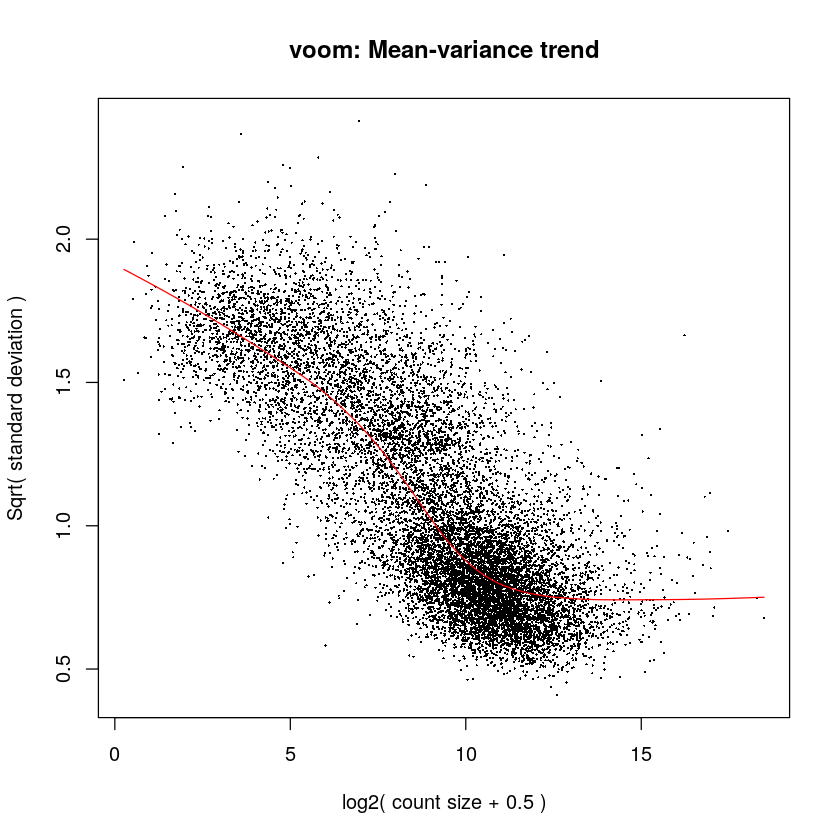

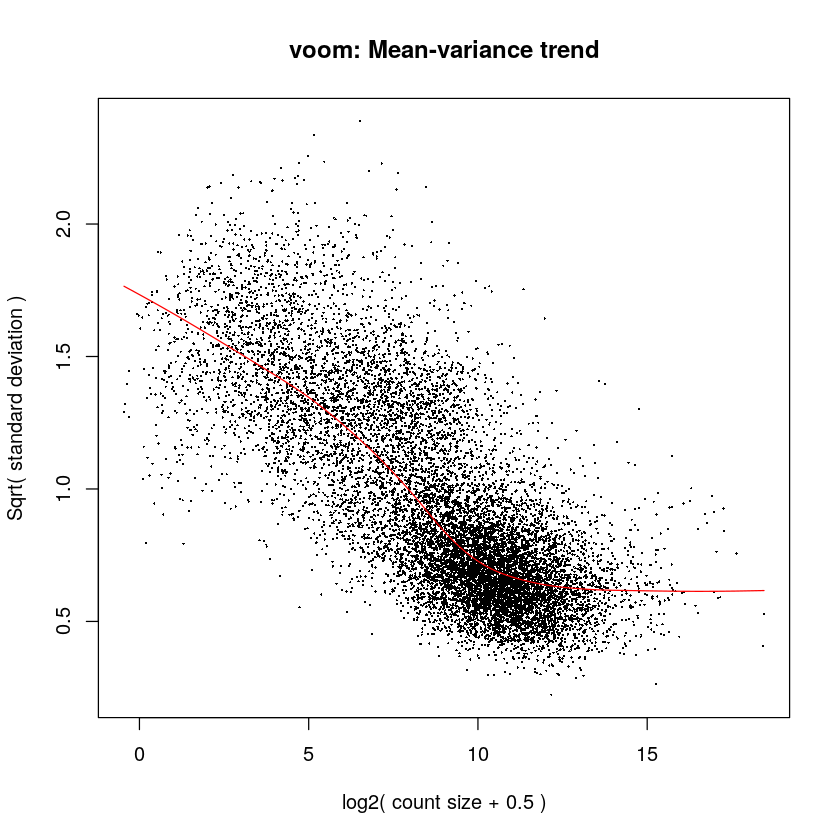

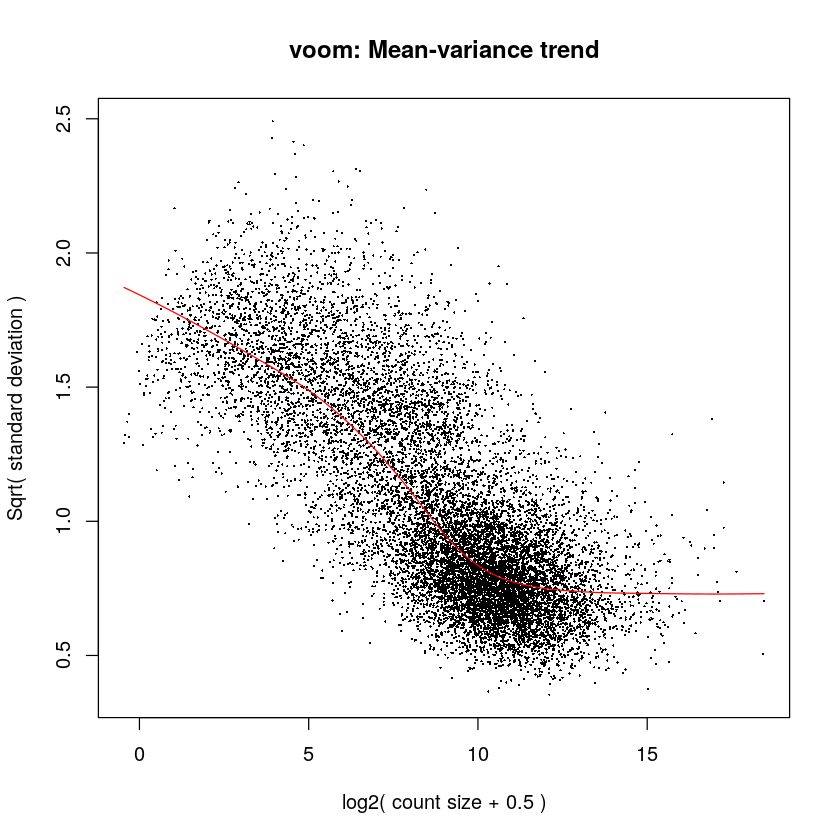

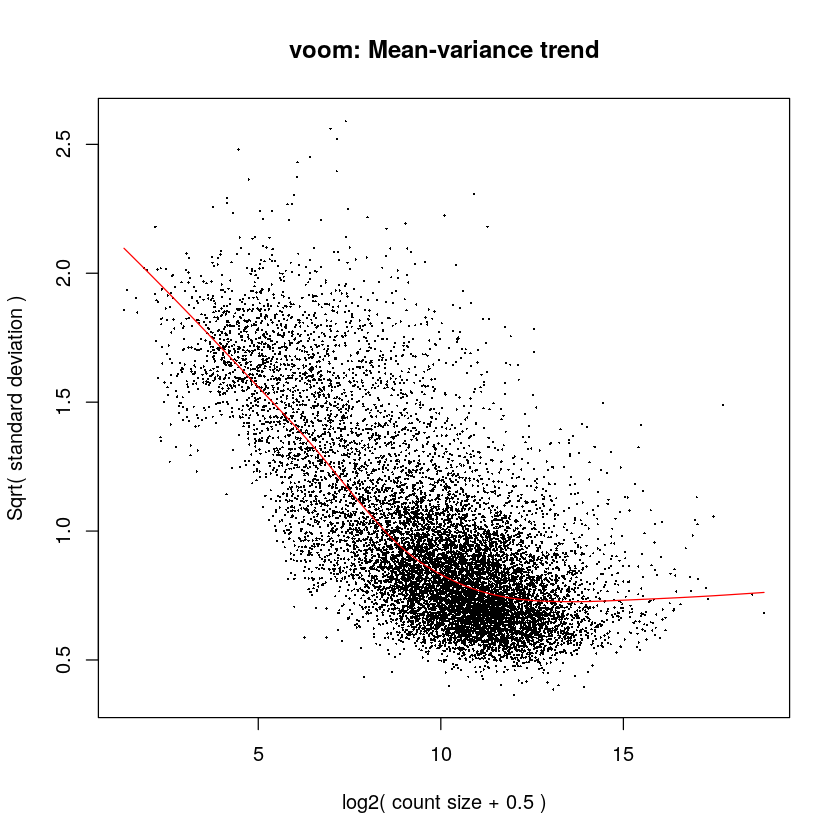

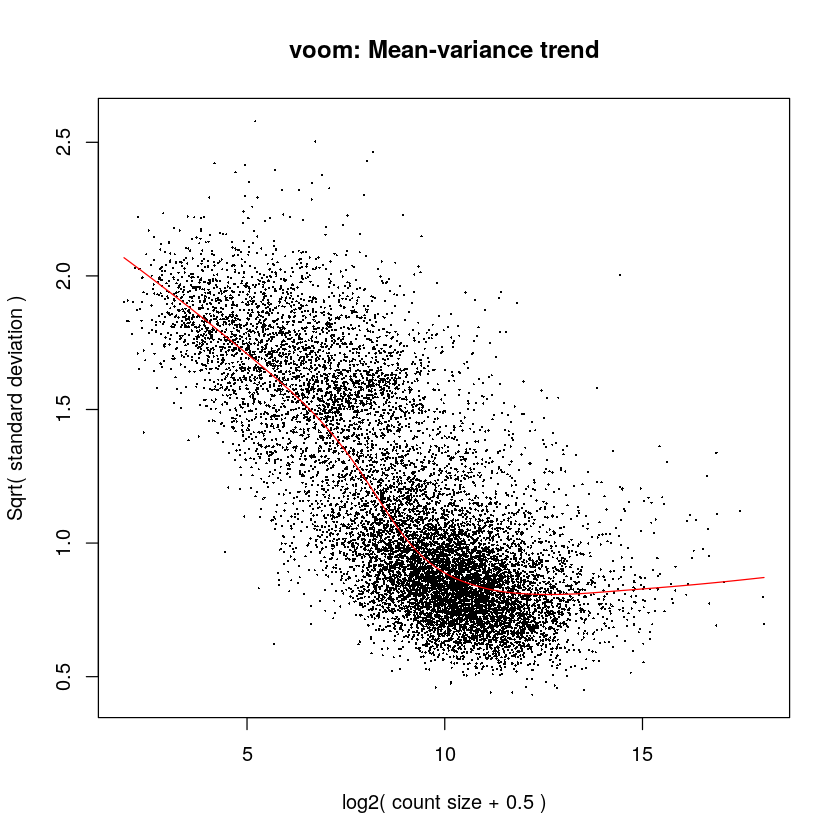

In [20]:
gVoomResult = voom(gOrigNormedFilteredDgeList, gDesignModel, plot=TRUE)
gVoomResult.paired.nocor = voom(gOrigNormedFilteredDgeList.paired, gDesignModel.paired.nocor, plot=TRUE)
gVoomResult.paired = voom(gOrigNormedFilteredDgeList.paired, gDesignModel.paired, plot=TRUE)
gVoomResult.prog = voom(gOrigNormedFilteredDgeList.prog, gDesignModel.prog, plot=TRUE)
gVoomResult.stem = voom(gOrigNormedFilteredDgeList.stem, gDesignModel.stem, plot=TRUE)

[Table of Contents](#Table-of-Contents)

### Fitting of Linear Models

Fit a separate linear model to the expression values of each gene, and apply empirical Bayes moderation to improve the estimates of gene-wise variability by borrowing information across genes.

In [21]:
corfit <- duplicateCorrelation(gVoomResult.paired, gDesignModel.paired, 
                               block=gOrigNormedFilteredDgeList.paired$samples$Patient.ID)
corfit$consensus.correlation
#corfit$consensus.correlation <- 0.521953855359054

[1] 0.4116844

In [22]:
gVoomedFit = lmFit(gVoomResult, gDesignModel)
gVoomedFit.paired.nocor = lmFit(gVoomResult.paired.nocor, gDesignModel.paired.nocor)
gVoomedFit.paired = lmFit(gVoomResult.paired, gDesignModel.paired, 
                          block=gOrigNormedFilteredDgeList.paired$samples$Patient.ID, correlation=corfit$consensus.correlation)
gVoomedFit.prog = lmFit(gVoomResult.prog, gDesignModel.prog)
gVoomedFit.stem = lmFit(gVoomResult.stem, gDesignModel.stem)

Coefficients not estimable: X12682 


Warning message:
“Partial NA coefficients for 12685 probe(s)”

In [23]:
dim(gVoomedFit.paired.nocor$design)
gVoomedFit.paired

[1] 18 12

An object of class "MArrayLM"
$coefficients
                PedAML.Stem PedAML.Prog AdultAML.Stem AdultAML.Prog      X62619
ENSG00000000003   -5.229261   -6.339600      4.274345    -4.9540539  0.05642236
ENSG00000000419    5.880274    5.973081      6.908166     6.4025284 -0.41266854
ENSG00000000457    2.930737    3.106848      2.595913     1.8532553  1.51156925
ENSG00000000460    4.304738    4.558354     -1.815937     2.5113885 -0.03948701
ENSG00000000938    1.933927    2.682667     -5.637624     0.6138576  0.21449967
                     X83119       X9119
ENSG00000000003 -0.70351160  2.64101794
ENSG00000000419 -0.27381532 -0.07824694
ENSG00000000457  1.18601677  0.53364328
ENSG00000000460 -0.03777547 -0.93874040
ENSG00000000938  0.41562417 -0.25406639
12680 more rows ...

$stdev.unscaled
                PedAML.Stem PedAML.Prog AdultAML.Stem AdultAML.Prog    X62619
ENSG00000000003   1.8082178   1.8234397     3.5294767     4.1977855 3.3905552
ENSG00000000419   0.3210855   0.3175875     0.7235433     0.7201791 0.6353177
ENSG00000000457   0.6431457   0.6218566     1.2191622     1.2570634 0.9035082
ENSG00000000460   0.4408050   0.4168957     2.1598471     1.2855617 0.8415931
ENSG00000000938   0.8020600   0.7280736     2.7540025     1.8446465 1.3538692
                   X83119     X9119
ENSG00000000003 3.3905552 2.4423429
ENSG00000000419 0.5787736 0.4670751
ENSG00000000457 0.8638604 0.8484458
ENSG00000000460 0.7217747 0.7332803
ENSG00000000938 1.2041210 1.0167053
12680 more rows ...

$sigma
[1] 0.6840318 0.5700326 0.8424303 0.9505751 0.9902157
12680 more elements ...

$df.residual
[1] 11 11 11 11 11
12680 more elements ...

$ndups
[1] 1

$spacing
[1] 1

$block
 [1] 32538 32538 22390 22390 28678 28678 22666 22666 11379 11379 11220 11220
[13] 12682 12682 12488 12488 12451 12451

$correlation
[1] 0.4116844

$cov.coefficients
              PedAML.Stem PedAML.Prog AdultAML.Stem AdultAML.Prog     X62619
PedAML.Stem     0.2773033   0.1932582     0.2352807     0.2352807 -0.2352807
PedAML.Prog     0.1932582   0.2773033     0.2352807     0.2352807 -0.2352807
AdultAML.Stem   0.2352807   0.2352807     1.4411229     1.1469651 -0.2352807
AdultAML.Prog   0.2352807   0.2352807     1.1469651     1.4411229 -0.2352807
X62619         -0.2352807  -0.2352807    -0.2352807    -0.2352807  0.9411229
X83119         -0.2352807  -0.2352807    -0.9411229    -0.9411229  0.2352807
X9119          -0.2352807  -0.2352807    -0.2352807    -0.2352807  0.2352807
                  X83119      X9119
PedAML.Stem   -0.2352807 -0.2352807
PedAML.Prog   -0.2352807 -0.2352807
AdultAML.Stem -0.9411229 -0.2352807
AdultAML.Prog -0.9411229 -0.2352807
X62619         0.2352807  0.2352807
X83119         0.9411229  0.2352807
X9119          0.2352807  0.5882018

$pivot
[1] 1 2 3 4 5 6 7

$rank
[1] 7

$genes
          ENSEMBL ENTREZID   SYMBOL      gene_type
1 ENSG00000000003     7105   TSPAN6 protein_coding
3 ENSG00000000419     8813     DPM1 protein_coding
4 ENSG00000000457    57147    SCYL3 protein_coding
5 ENSG00000000460    55732 C1orf112 protein_coding
6 ENSG00000000938     2268      FGR protein_coding
12680 more rows ...

$Amean
ENSG00000000003 ENSG00000000419 ENSG00000000457 ENSG00000000460 ENSG00000000938 
      -4.283018        5.938088        3.479322        3.192090        1.433652 
12680 more elements ...

$method
[1] "ls"

$design
                      PedAML.Stem PedAML.Prog AdultAML.Stem AdultAML.Prog
01id38cellHSC                   1           0             0             0
02id38cellPROGENITORS           0           1             0             0
cell05id90HSC                   1           0             0             0
06id90cellPROGENITORS           0           1             0             0
03id78cellHSC                   1           0             0             0
                      X62619 X83119 X9119
01id38cellHSC              0      0     0
02id38cellPROGENITORS      0      0     0
cell05id90HSC              0      0     0
06id90cellPROGENITORS      0      0    

In [24]:
gVoomedFitForContrasts = contrasts.fit(gVoomedFit, contrasts=gContrastMatrix)
gVoomedFitForContrasts.paired.nocor = contrasts.fit(gVoomedFit.paired.nocor, contrasts=gContrastMatrix.paired.nocor)
gVoomedFitForContrasts.paired = contrasts.fit(gVoomedFit.paired, contrasts=gContrastMatrix.paired)
gVoomedFitForContrasts.prog = contrasts.fit(gVoomedFit.prog, contrasts=gContrastMatrix.prog)
gVoomedFitForContrasts.stem = contrasts.fit(gVoomedFit.stem, contrasts=gContrastMatrix.stem)

In [25]:
gModeratedVoomedFitForContrasts = eBayes(gVoomedFitForContrasts)
gModeratedVoomedFitForContrasts.paired.nocor = eBayes(gVoomedFitForContrasts.paired.nocor)
gModeratedVoomedFitForContrasts.paired = eBayes(gVoomedFitForContrasts.paired)
gModeratedVoomedFitForContrasts.prog = eBayes(gVoomedFitForContrasts.prog)
gModeratedVoomedFitForContrasts.stem = eBayes(gVoomedFitForContrasts.stem)

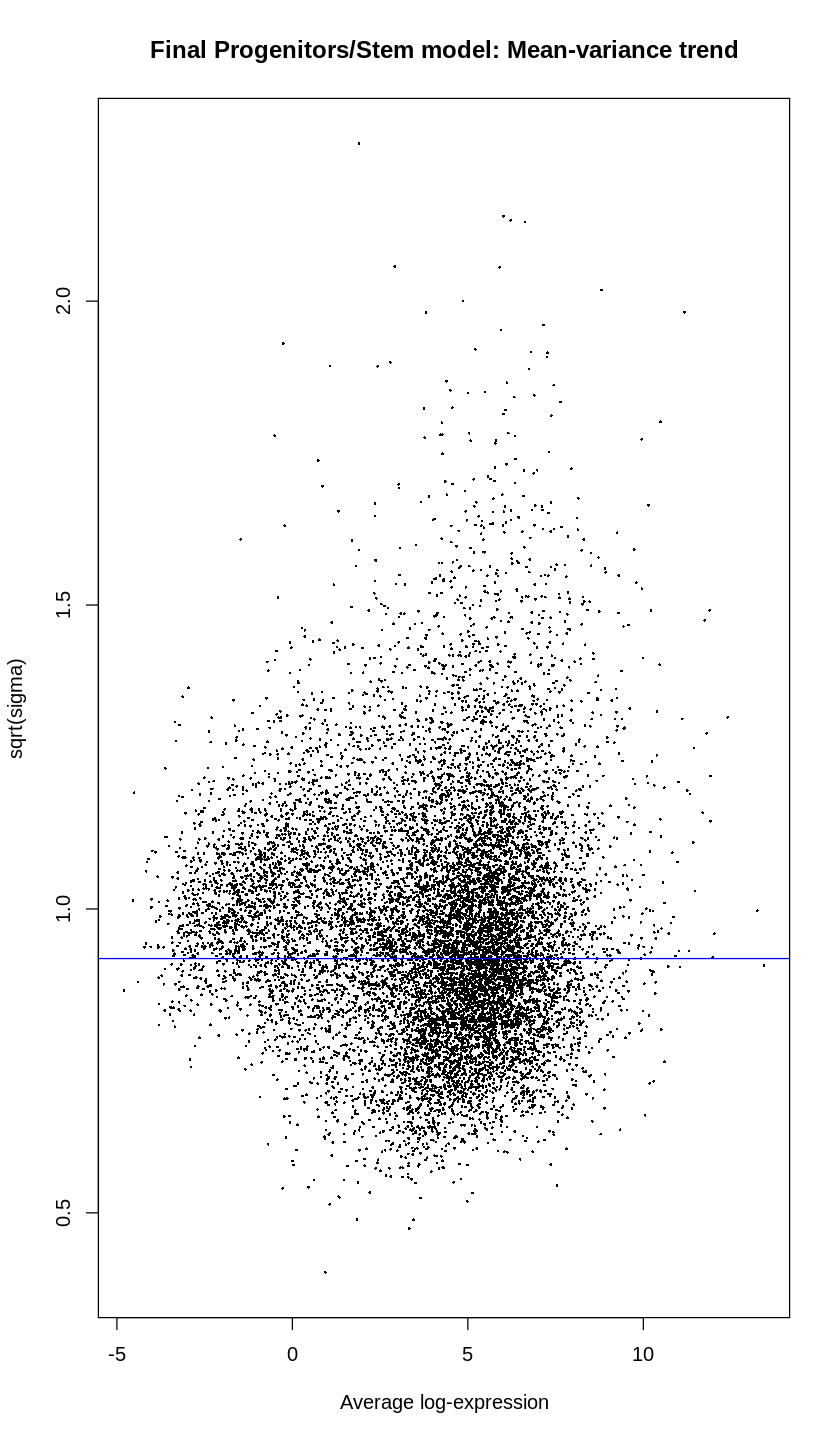

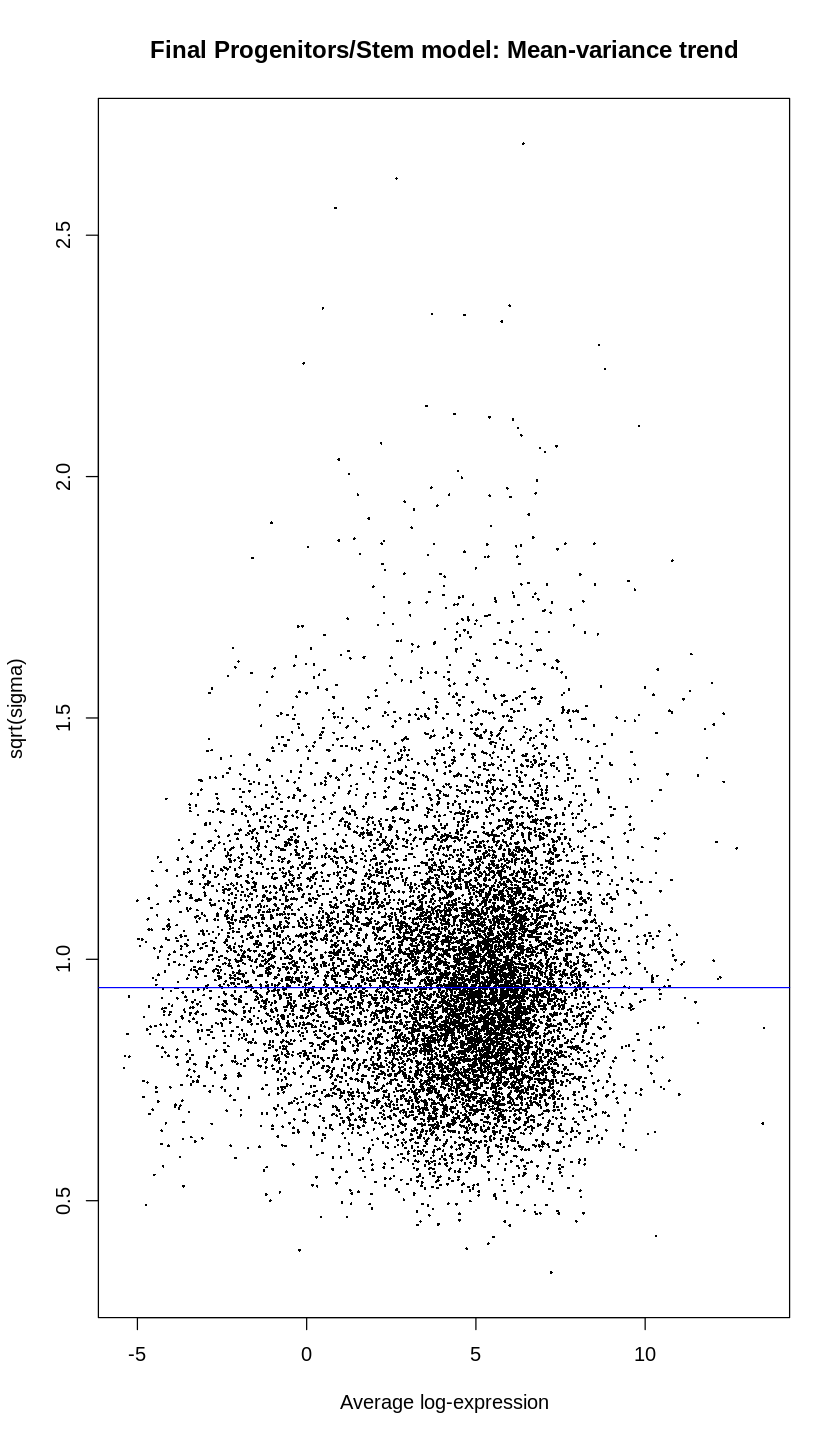

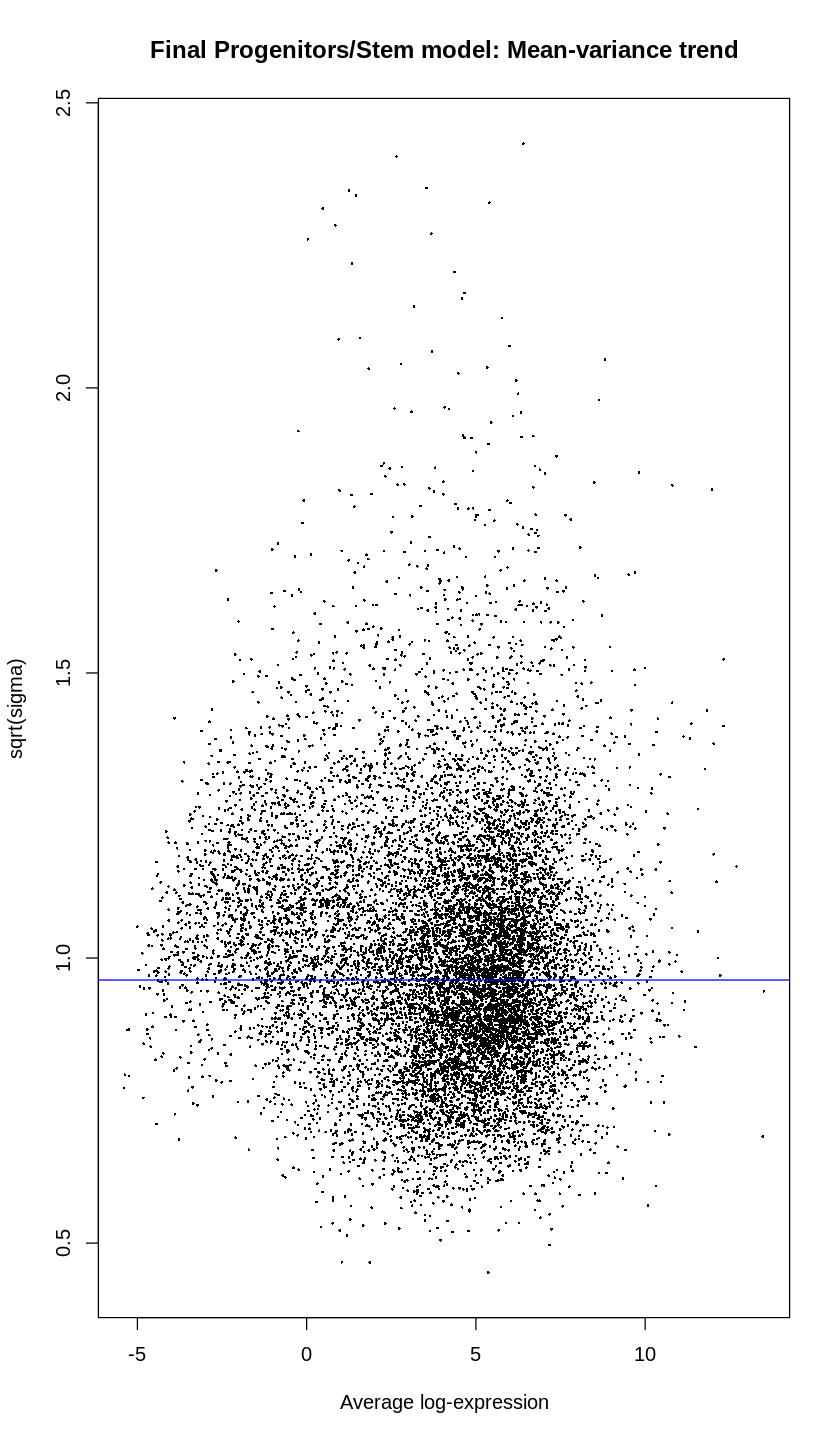

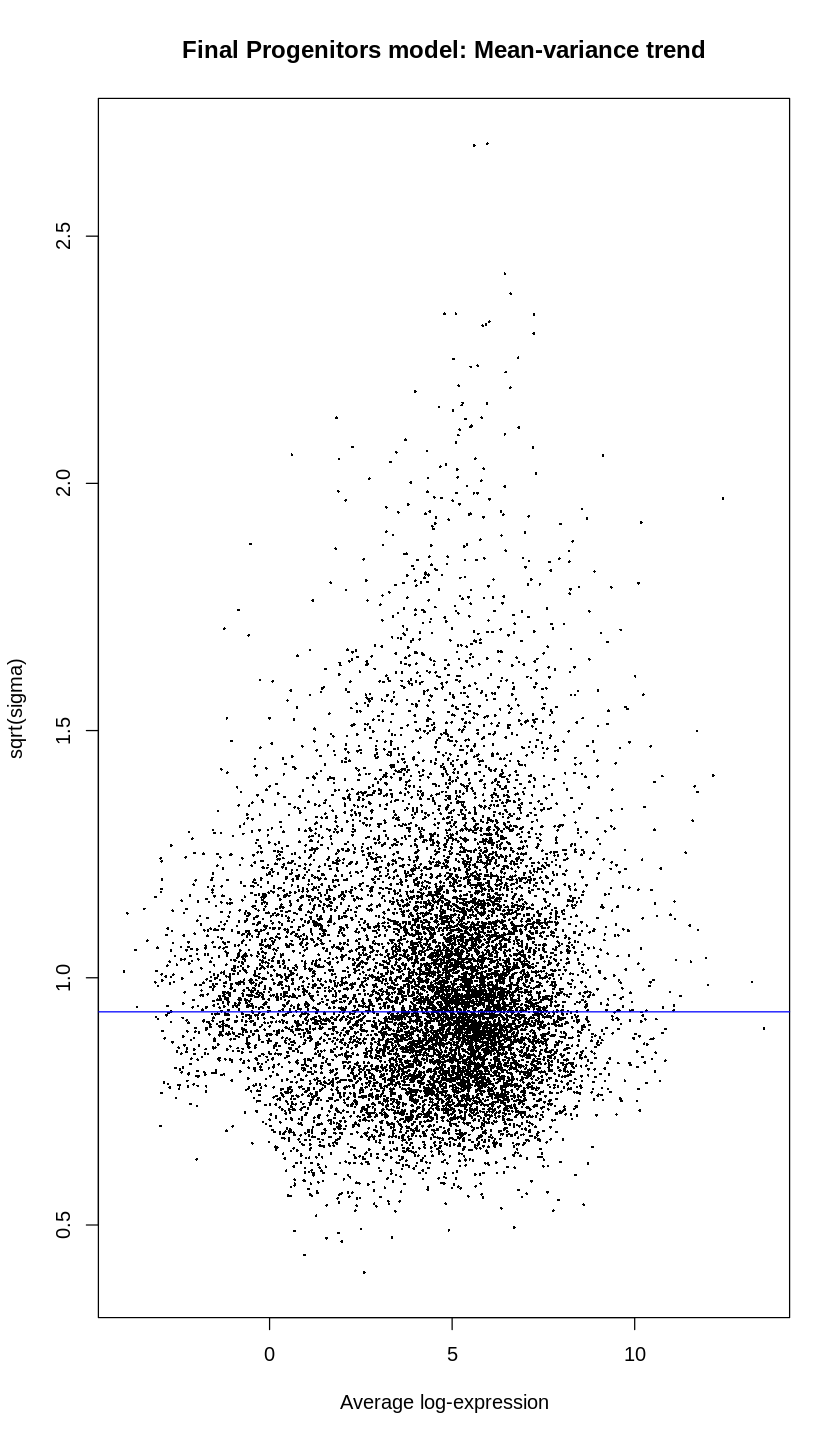

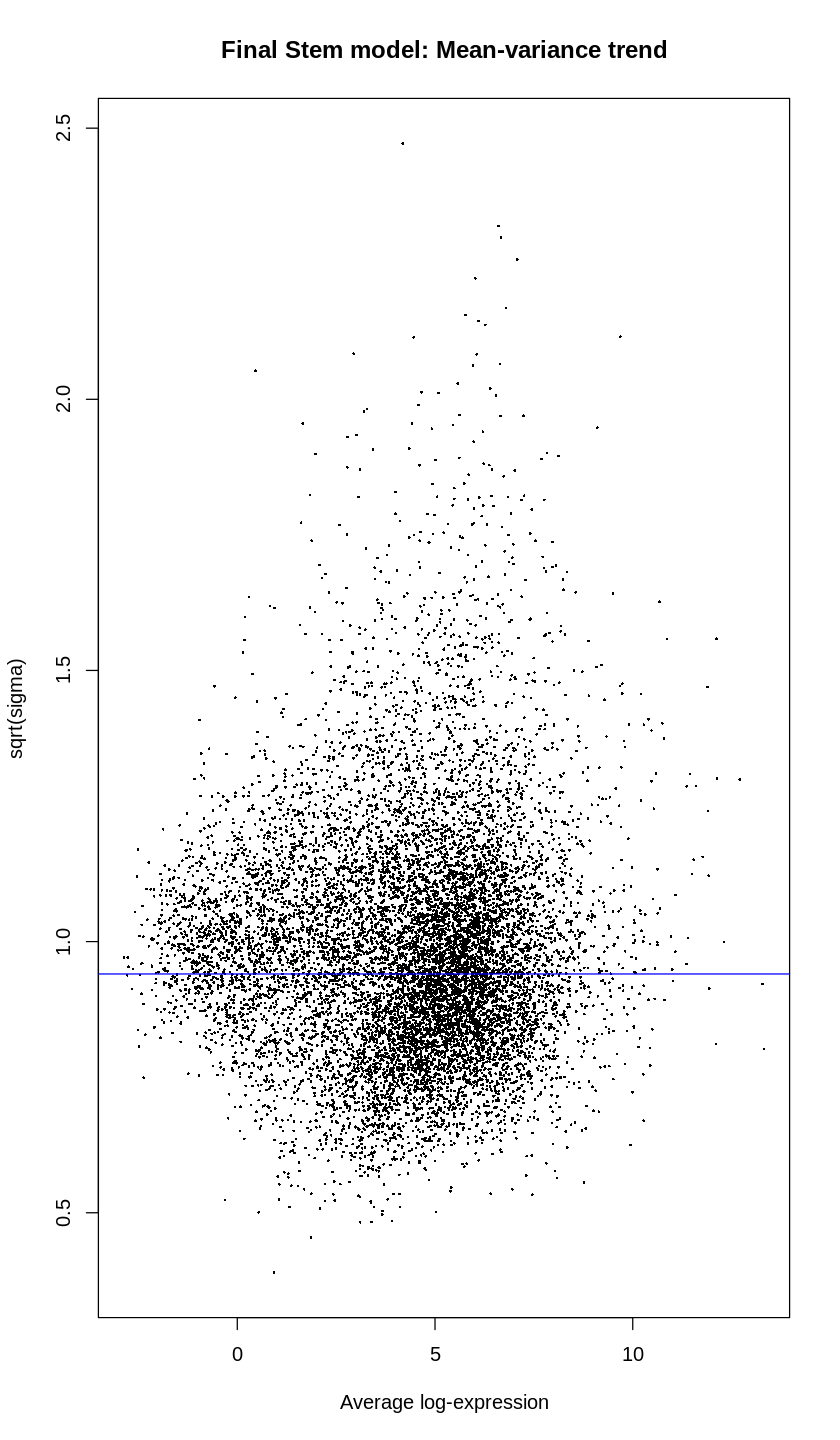

In [402]:
plotSA(gModeratedVoomedFitForContrasts, main="Final Progenitors/Stem model: Mean-variance trend")
plotSA(gModeratedVoomedFitForContrasts.paired.nocor, main="Final Progenitors/Stem model: Mean-variance trend")
plotSA(gModeratedVoomedFitForContrasts.paired, main="Final Progenitors/Stem model: Mean-variance trend")
plotSA(gModeratedVoomedFitForContrasts.prog, main="Final Progenitors model: Mean-variance trend")
plotSA(gModeratedVoomedFitForContrasts.stem, main="Final Stem model: Mean-variance trend")

>The above graphic demonstrates that the mean-variance relationship shown earlier in the voom plot has been removed by the use of the voom-produced weights.

</div>

While the voom analysis above accounts for the fact that variance is not independent of the mean, for the purposes of later per-comparison power analysis, estimate a common dispersion across all genes and an associated biological coefficient of variation (BCV). 

In the context of RNASeq, global variance is defined as the sum of technical and biological variance. Technical variance can be decreased by increasing sequencing depth. However, the impact of sequencing depth on global variance is limited by the amplitude of the biological variation. In other words, at a certain point, deeper sequencing doesn't provide additional value. In these situations, it becomes more useful to add additional samples. The RNASeqPower R package calculates a formal sample size comparison for two groups involving the following 5 factors:
    
    1. The depth of sequencing and consequent expected count for a given transcript;
    2. The coefficient of variation of counts within each of the 2 groups;
    3. The size difference (fold-change) that we wish to detect;
    4. The target false positive rate and false negative rate (or power);
    5. The number of samples in each group.
    
([12](#Citations))

In [403]:
gCommonDispersion <- estimateGLMCommonDisp(gOrigNormedFilteredDgeList, gDesignModel, 
                                           verbose=TRUE)
# The biological coefficient of variation is the square root of the common dispersion
gBcv = sqrt(gCommonDispersion$common.dispersion)

#gCommonDispersion.paired.nocor <- estimateGLMCommonDisp(gOrigNormedFilteredDgeList.paired, gDesignModel.paired.nocor, 
#                                           verbose=TRUE)
# The biological coefficient of variation is the square root of the common dispersion
#gBcv.paired = sqrt(gCommonDispersion.paired.nocor$common.dispersion)

gCommonDispersion.prog <- estimateGLMCommonDisp(gOrigNormedFilteredDgeList.prog, gDesignModel.prog, 
                                           verbose=TRUE)
gBcv.prog = sqrt(gCommonDispersion.prog$common.dispersion)

gCommonDispersion.stem <- estimateGLMCommonDisp(gOrigNormedFilteredDgeList.stem, gDesignModel.stem, 
                                           verbose=TRUE)
gBcv.stem = sqrt(gCommonDispersion.stem$common.dispersion)

Disp = 0.68007 , BCV = 0.8247 
Disp = 0.54572 , BCV = 0.7387 
Disp = 0.78766 , BCV = 0.8875 


[Table of Contents](#Table-of-Contents)

### Summarization of Differentially Expressed Genes

Look at the summary information on how many differentially expressed genes, in which directions, are found for each comparison.  By default, differentially expressed genes are identified as those with a Benjamini-Hochberg-adjusted p-value of <= 0.05.

Note that the Benjamini-Hochberg adjustment ([13](#Citations)) addresses correcting p-values across multiple tested genes, not across multiple tested contrasts:

>If several contrasts are being tested simultaneously, then the issue arises of multiple
testing for the entire set of hypotheses being considered, across contrasts as well as probes. The
function decideTests() offers a number of strategies for doing this.
The simplest multiple testing method is method="separate". This method does multiple testing
for each contrast separately. This method is the default because it is equivalent to using topTable().
Using this method, testing a set of contrasts together will give the same results as when each contrast
is tested on its own. The great advantage of this method is that it gives the same results regardless
of which set of contrasts are tested together. The disadvantage of this method is that it does not
do any multiple testing adjustment between contrasts. Another disadvantage is that the raw p-value
cutoff corresponding to significance can be very different for different contrasts, depending on the
number of DE probes. This method is recommended when different contrasts are being analysed to
answer more or less independent questions.
>
> method="global" is recommended when a set of closely related contrasts are being tested. This
method simply appends all the tests together into one long vector of tests, i.e., it treats all the tests
as equivalent regardless of which probe or contrast they relate to. An advantage is that the raw
p-value cutoff is consistent across all contrasts. For this reason, method="global" is recommended if
you want to compare the number of DE genes found for different contrasts, for example interpreting
the number of DE genes as representing the strength of the contrast. However users need to be aware
that the number of DE genes for any particular contrasts will depend on which other contrasts are
tested at the same time. Hence one should include only those contrasts which are closely related to
the question at hand. Unnecessary contrasts should be excluded as these would affect the results for
the contrasts of interest. Another more theoretical issue is that there is no theorem which proves that
adjust.method="BH" in combination with method="global" will correctly control the false discovery
rate for combinations of negatively correlated contrasts, however simulations, experience and some
theory suggest that the method is safe in practice. ([8](#Citations))

In [26]:
gMultipleTestingStrategy = "global"

In [27]:
summary(decideTests(gModeratedVoomedFitForContrasts, method=gMultipleTestingStrategy))
summary(decideTests(gModeratedVoomedFitForContrasts.paired.nocor, method=gMultipleTestingStrategy))
summary(decideTests(gModeratedVoomedFitForContrasts.paired, method=gMultipleTestingStrategy))
summary(decideTests(gModeratedVoomedFitForContrasts.prog, method=gMultipleTestingStrategy))
summary(decideTests(gModeratedVoomedFitForContrasts.stem, method=gMultipleTestingStrategy))

       PedAML.ProgvsPedAML.Stem AdultAML.ProgvsAdultAML.Stem
Down                          0                            0
NotSig                    12685                        12685
Up                            0                            0

       PedAML.ProgvsPedAML.Stem AdultAML.ProgvsAdultAML.Stem
Down                          0                            4
NotSig                    12685                        12681
Up                            0                            0

       PedAML.ProgvsPedAML.Stem AdultAML.ProgvsAdultAML.Stem
Down                          0                            0
NotSig                    12685                        12683
Up                            0                            2

       PedAMLvsAdultAML PedAMLvsPedNL
Down                200           401
NotSig            11780         11569
Up                   89            99

       PedAMLvsAdultAML PedAMLvsPedNL
Down                  0            12
NotSig            11837         11825
Up                    0             0

Because researchers often wish to receive differential expression results limited to those genes with absolute fold-changes >= some threshold, we use the TREAT approach ([14](#Citations)), which "[i]nstead of testing for genes which have log-fold-changes different from zero, ... tests whether the log2-fold-change is greater than lfc in absolute value" ([15](#Citations)).  The log-fold-change testing is therefore incorporated into the p-value calculation.  For example, if one wishes to find only those genes with fold change >=2 or <= -2 (i.e, those with  absolute fold-change of 2, and thus log2 fold-change of 1) rather than applying two thresholds (adjusted p-value that absolute log-fold-change is different than zero is <= 0.05, and absolute log-fold-change is >= 2), one instead applys a single threshold (adjusted p-value that absolute log-fold-change is >=2 is <= 0.05).  If the log-fold-change threshold is set to zero, then then results of the TREAT method are equivalent to simply identify genes whose adjusted p-value that absolute log-fold-change is different than zero is <= 0.05.

In [28]:
gModeratedVoomedFitForContrastsWithLogFcThreshold = treat(gModeratedVoomedFitForContrasts)
gModeratedVoomedFitForContrastsWithLogFcThreshold.paired.nocor = treat(gModeratedVoomedFitForContrasts.paired.nocor)
gModeratedVoomedFitForContrastsWithLogFcThreshold.paired = treat(gModeratedVoomedFitForContrasts.paired)
gModeratedVoomedFitForContrastsWithLogFcThreshold.prog = treat(gModeratedVoomedFitForContrasts.prog)
gModeratedVoomedFitForContrastsWithLogFcThreshold.stem = treat(gModeratedVoomedFitForContrasts.stem)

In [29]:
gLogThresholdedTestResults = decideTests(gModeratedVoomedFitForContrasts)
gLogThresholdedTestResults.paired.nocor = decideTests(gModeratedVoomedFitForContrasts.paired.nocor)
gLogThresholdedTestResults.paired = decideTests(gModeratedVoomedFitForContrasts.paired)
gLogThresholdedTestResults.prog = decideTests(gModeratedVoomedFitForContrasts.prog)
gLogThresholdedTestResults.stem = decideTests(gModeratedVoomedFitForContrasts.stem)

In [30]:
summary(gLogThresholdedTestResults)
summary(gLogThresholdedTestResults.paired.nocor)
summary(gLogThresholdedTestResults.paired)
summary(gLogThresholdedTestResults.prog)
summary(gLogThresholdedTestResults.stem)

       PedAML.ProgvsPedAML.Stem AdultAML.ProgvsAdultAML.Stem
Down                          0                            3
NotSig                    12685                        12680
Up                            0                            2

       PedAML.ProgvsPedAML.Stem AdultAML.ProgvsAdultAML.Stem
Down                          0                            6
NotSig                    12685                        12678
Up                            0                            1

       PedAML.ProgvsPedAML.Stem AdultAML.ProgvsAdultAML.Stem
Down                          0                           14
NotSig                    12685                        12618
Up                            0                           53

       PedAMLvsAdultAML PedAMLvsPedNL
Down                122           525
NotSig            11902         11397
Up                   45           147

       PedAMLvsAdultAML PedAMLvsPedNL
Down                  0           119
NotSig            11837         11714
Up                    0             4

In [31]:
topTable_ProgvsStem_AdultAML_All <- topTable(gModeratedVoomedFitForContrasts, coef=2, n=Inf)
topTable_ProgvsStem_PedAML_All <- topTable(gModeratedVoomedFitForContrasts, coef=1, n=Inf)
topTable_ProgvsStem_AdultAML_nocor <- topTable(gModeratedVoomedFitForContrasts.paired.nocor, coef=2, n=Inf)
topTable_ProgvsStem_PedAML_nocor <- topTable(gModeratedVoomedFitForContrasts.paired.nocor, coef=1, n=Inf)
topTable_ProgvsStem_AdultAML <- topTable(gModeratedVoomedFitForContrasts.paired, coef=2, n=Inf)
topTable_ProgvsStem_PedAML <- topTable(gModeratedVoomedFitForContrasts.paired, coef=1, n=Inf)
topTable_PedAMLvsAdultAML_Prog <- topTable(gModeratedVoomedFitForContrasts.prog, coef=2, n=Inf)
topTable_PedAMLvsPedNL_Prog <- topTable(gModeratedVoomedFitForContrasts.prog, coef=1, n=Inf)
topTable_PedAMLvsAdultAML_Stem <- topTable(gModeratedVoomedFitForContrasts.stem, coef=2, n=Inf)
topTable_PedAMLvsPedNL_Stem <- topTable(gModeratedVoomedFitForContrasts.stem, coef=1, n=Inf)

In [32]:
head(topTable_ProgvsStem_AdultAML_nocor)
head(topTable_ProgvsStem_PedAML_nocor)

ENSEMBL         ENTREZID SYMBOL  gene_type      logFC    
ENSG00000119917 ENSG00000119917 3437     IFIT3   protein_coding -5.600124
ENSG00000125968 ENSG00000125968 3397     ID1     protein_coding -5.236293
ENSG00000154734 ENSG00000154734 9510     ADAMTS1 protein_coding -6.658889
ENSG00000119922 ENSG00000119922 3433     IFIT2   protein_coding -5.457285
ENSG00000186480 ENSG00000186480 3638     INSIG1  protein_coding -2.132698
ENSG00000117289 ENSG00000117289 NA       NA      NA              1.961306
                AveExpr   t         P.Value      adj.P.Val  B       
ENSG00000119917  3.723320 -8.426581 2.430070e-06 0.01027515 4.945681
ENSG00000125968  2.025169 -8.653750 1.847956e-06 0.01027515 4.914831
ENSG00000154734 -1.974582 -8.641756 1.874615e-06 0.01027515 4.723758
ENSG00000119922  4.079763 -7.910465 4.621736e-06 0.01465668 4.598319
ENSG00000186480  6.321877 -7.262674 1.081429e-05 0.02743586 3.787839
ENSG00000117289 10.179306  6.917241 1.737657e-05 0.03673697 3.274309

ENSEMBL         ENTREZID SYMBOL gene_type      logFC     
ENSG00000090382 ENSG00000090382 4069     LYZ    protein_coding  1.7796375
ENSG00000198804 ENSG00000198804 4512     COX1   protein_coding -1.1481181
ENSG00000119866 ENSG00000119866 53335    BCL11A protein_coding -0.5692851
ENSG00000164741 ENSG00000164741 10395    DLC1   protein_coding  1.1710519
ENSG00000120129 ENSG00000120129 1843     DUSP1  protein_coding -0.6193509
ENSG00000172889 ENSG00000172889 51162    EGFL7  protein_coding -0.6139596
                AveExpr   t         P.Value     adj.P.Val B        
ENSG00000090382  7.433971  4.044387 0.001673769 0.9995624 -3.832204
ENSG00000198804 11.560991 -3.621726 0.003582817 0.9995624 -3.872459
ENSG00000119866  5.702741 -3.648644 0.003411662 0.9995624 -3.976206
ENSG00000164741  5.298746  3.550474 0.004079571 0.9995624 -3.994015
ENSG00000120129 10.026127 -3.078373 0.009714051 0.9995624 -4.012317
ENSG00000172889  8.702888 -3.050949 0.010218531 0.9995624 -4.027603

In [244]:
write.table(topTable_ProgvsStem_AdultAML_All, file="topTable_DEgenes_ProgvStem_AdultAML_All.txt", quote=FALSE, sep="\t", row.names=FALSE)
write.table(topTable_ProgvsStem_PedAML_All, file="topTable_DEgenes_ProgvStem_PedAML_All.txt", quote=FALSE, sep="\t", row.names=FALSE)
#write.table(topTable_ProgvsStem_AdultAML_nocor, file="topTable_DEgenes_ProgvsStem_AdultAML_nocor.txt", quote=FALSE, sep="\t", row.names=FALSE)
#write.table(topTable_ProgvsStem_PedAML_nocor, file="topTable_DEgenes_ProgvsStem_PedAML_nocor.txt", quote=FALSE, sep="\t", row.names=FALSE)
#write.table(topTable_PedAMLvsAdultAML_Prog, file="topTable_DEgenes_PedAMLvsAdultAML_Prog.txt", quote=FALSE, sep="\t", row.names=FALSE)
#write.table(topTable_PedAMLvsPedNL_Prog, file="topTable_DEgenes_PedAMLvsPedNL_Prog.txt", quote=FALSE, sep="\t", row.names=FALSE)
#write.table(topTable_PedAMLvsAdultAML_Stem, file="topTable_DEgenes_PedAMLvsAdultAML_Stem.txt", quote=FALSE, sep="\t", row.names=FALSE)
#write.table(topTable_PedAMLvsPedNL_Stem, file="topTable_DEgenes_PedAMLvsPedNL_Stem.txt", quote=FALSE, sep="\t", row.names=FALSE)


> The results here are identify a lot more genes compared to those above with the log-fold-change threshold. We will not use the threshold to filter the significant genelists.


#### Venn Diagrams

Venn diagrams show the overlap of the identified differentially expressed genes across various comparisons.

In [ ]:
### Don't run these functions
plotComparisonsVenn = function(aTestResults, coefficientsVector=c(1,2,3,4,5), 
                               colorsVector=c("green","blue","purple","red","orange" ),
                               mar=rep(0,4), cex=c(.9,0.6, 0.5),
                               heightIn=7, widthIn=7){
    options(repr.plot.width=heightIn, repr.plot.height=widthIn)
    vennDiagram(aTestResults[,coefficientsVector], 
                circle.col=colorsVector,
                mar=mar,cex=cex)    
}

plotAndSaveComparisonsVenn = function(aTestResults, outputDir, runName, thresholdDesc,
                                      comparisonsDesc,
                                      coefficientsVector=c(1,2,3,4,5), 
                                      colorsVector=c("green","blue","purple","red","orange" ),
                                      mar=rep(0,4), cex=c(.9,0.6, 0.5),
                                      heightIn=7, widthIn=7){
    plotComparisonsVenn(aTestResults, coefficientsVector, colorsVector, mar, cex, heightIn, widthIn)

    fileName = paste0(paste(runName, "Venn", comparisonsDesc, thresholdDesc, sep="_"),".png")
    png(filename = file.path(outputDir, fileName), height = 7, width = 7, 
      units = "in", res = 300)

    plotComparisonsVenn(aTestResults, coefficientsVector, colorsVector, mar, cex, heightIn, widthIn)

    dev.off()
    print(paste0("Output file: ", fileName))
}

In [ ]:
globalPlotAndSaveComparisonsVenn = function(comparisonsDesc,coefficientsVector=c(1,2,3,4,5), 
                                            colorsVector=c("green","blue","purple","red","orange" ),
                                            mar=rep(0,4), cex=c(.9,0.6, 0.5),
                                            heightIn=7, widthIn=7){
    plotAndSaveComparisonsVenn(gLogThresholdedTestResults, gOutputDir, gRunName, 
                               gThresholdDescription, comparisonsDesc, coefficientsVector,
                               colorsVector, mar, cex, heightIn, widthIn)    
}

In [226]:
## Use this one
gene.uni <- unique(c(rownames(gLogThresholdedTestResults.prog@.Data), 
                                           rownames(gLogThresholdedTestResults.stem@.Data)))
vennInput <- matrix(nrow = length(gene.uni), ncol=4, data = 0)
dim(vennInput)
rownames(vennInput) <- gene.uni

vennInput[which(rownames(vennInput) %in% rownames(gLogThresholdedTestResults.prog)),1] <- gLogThresholdedTestResults.prog[match(
                                            rownames(vennInput)[which(rownames(vennInput) %in% rownames(gLogThresholdedTestResults.prog))], 
                                            rownames(gLogThresholdedTestResults.prog)),1]
vennInput[which(rownames(vennInput) %in% rownames(gLogThresholdedTestResults.prog)),2] <- gLogThresholdedTestResults.prog[match(
                                            rownames(vennInput)[which(rownames(vennInput) %in% rownames(gLogThresholdedTestResults.prog))],
                                            rownames(gLogThresholdedTestResults.prog)),2]
vennInput[which(rownames(vennInput) %in% rownames(gLogThresholdedTestResults.stem)),3] <- gLogThresholdedTestResults.stem[match(
                                            rownames(vennInput)[which(rownames(vennInput) %in% rownames(gLogThresholdedTestResults.stem))], 
                                            rownames(gLogThresholdedTestResults.stem)),1]
vennInput[which(rownames(vennInput) %in% rownames(gLogThresholdedTestResults.stem)),4] <- gLogThresholdedTestResults.stem[match(
                                            rownames(vennInput)[which(rownames(vennInput) %in% rownames(gLogThresholdedTestResults.stem))], 
                                            rownames(gLogThresholdedTestResults.stem)),2]

colnames(vennInput) <- c("Progenitors - PedAML vs Adult AML",
                         "Progenitors - PedAML vs Ped non-Leuk",
                         "Stem Cells - PedAML vs Adult AML", 
                         "Stem Cells - PedAML vs Ped non-Leuk")

pdf("vennDiagram_PedAML_NL_AdultAML_TCW_03102020.pdf", width=7, height=7)
vennDiagram(vennInput,circle.col=c('red','blue','green', 'dark orange'), cex=0.75, 
            show.include = FALSE, main="RNASeq - Differentially Expressed Genes ")
dev.off()

[1] 12277     4

png 
  2

[Table of Contents](#Table-of-Contents)

### Examination of Individual Comparisons



In [33]:
gNumTopHitsShown = 20
gNumHeatmapGenes = 100

In [34]:
colnames(gOrigNormedFilteredDgeList$samples)

[1] "group"            "lib.size"         "norm.factors"     "SequenceRun"     
 [5] "SequenceDate"     "Sample"           "SampleName"       "Patient.ID"      
 [9] "RIN"              "X"                "Adult.Pediatric"  "Disease"         
[13] "Cell.type"        "Sorted.Cell.Type" "Tissue.Source"    "RNA.seq.status"  
[17] "Reads"            "Phenotype"

In [35]:
gGroupMetadataColName1 = "Phenotype"
gGroupMetadataColName2 = "group"


In [36]:
gGroupMetadataVector.paired = as.character(gOrigNormedFilteredDgeList.paired$samples[[gGroupMetadataColName1]])
gGroupMetadataVector.prog = as.character(gOrigNormedFilteredDgeList.prog$samples[[gGroupMetadataColName2]])
gGroupMetadataVector.stem = as.character(gOrigNormedFilteredDgeList.stem$samples[[gGroupMetadataColName2]])

Perform each of the requested comparisons individually and produce output gene lists and visualizations.  Each comparison produces the following information:

* A power analysis showing the power to detect various fold-changes given the size of the first and second groups in the comparison.
* A summary of the number of up- and down-regulated genes meeting the adjusted p-value threshold as described above.  Up-regulated genes are those that are more highly expressed in the first group listed in the comparison name than in the second--genes up-regulated in a comparison named, say, Day15vsDay0 are those that are more highly expressed in Day 15 than in Day 0.  The analogous description applies to down-regulated genes.
* A table of the top 20 most differentially expressed genes in the comparison, as determined by adjusted p-value, without regard to the direction of their fold change.  They are sorted by increasing adjusted p-value. Note that this list always shows the top 20 most differentially expressed genes, even if those genes are not statistically significant according to the threshold listed above.   
* A comma-separated-value (csv) file containing the differential expression results (log fold change, adjusted p-value, etc) for **EVERY** gene, regardless of whether it is found to be significantly differentially expressed.  Like the table, it is sorted by increasing adjusted p-value, but is suitable for import into a spreadsheet program for re-sorting or filtering (for example, by log fold-change).  Having a list of all genes enables checking the results for genes that are of interest but were NOT found to be significant. 
* A mean-difference plot (also known as an MA plot) showing the log fold change of each gene in the comparison as a function of its average log expression.  Genes that are up-regulated in the comparison are shown in yellow, those that are down-regulated are shown in blue, and those that are not statistically significantly regulated at the threshold listed above are shown in black.
* A heat map of the expression, across all samples, of the top 100 significantly differentially expressed genes (those meeting the adjusted p-value threshold as described above) in this particular comparison.  
* An interactive mean-difference plot produced by the Glimma package ([16](#Citations)). Glimma plots can be found in the glimma-plots directory. Genes can be filtered by various statistics (i.e. adjusted P value, average expression, log-fold change, etc) and logCPM levels of individual samples can be examined for each gene.

In [235]:
library(RNASeqPower)

getNumSamplesInGroup = function(coefficientNumber, contrastMatrix, designMatrix, 
                                contrastValue=1){
    contrastDf = as.data.frame(contrastMatrix)
    coefficientName = colnames(contrastDf)[coefficientNumber]
    groupName = row.names(contrastDf[which(contrastDf[[coefficientName]] == contrastValue),])
    designModelDf = as.data.frame(designMatrix)
    groupSize = lapply(designModelDf[groupName], sum)
    return(as.vector(unlist(groupSize)))
}

doPowerCalculation = function(coefficientNumber, contrastMatrix, designMatrix, 
                              coverage, bcv, effect, targetAlpha){
    numSamplesGroup1 = getNumSamplesInGroup(coefficientNumber, contrastMatrix, 
                                            designMatrix, 1)
    numSamplesGroup2 = getNumSamplesInGroup(coefficientNumber, contrastMatrix, 
                                            designMatrix, -1)
    sizePerGroup = c(numSamplesGroup1, numSamplesGroup2)        

    # Find the power for a study with sizePerGroup (can be a vector) per group, 
    # to detect an (effect) change, given coverage?
    rnapower(coverage, cv=bcv, effect=c(1.25, 1.5, 1.75, 2), n=sizePerGroup, 
             alpha=targetAlpha)    
}

<div class="alert alert-warning">
    <strong>Analyst Note: Placeholder</strong><br />
    
`TODO: Where does the coverage number in the below code come from?`

</div>

In [236]:
globalDoPowerCalculation = function(coefficientNumber, coverage=10,
                                    effect=c(1.25, 1.5, 1.75, 2), 
                                    targetAlpha=0.05){
    display('Power calculation: x is fold-change, y is group size')
    doPowerCalculation(coefficientNumber, gContrastMatrix, gDesignModel, 
                              coverage, gBcv, effect, targetAlpha)
}

In [37]:
library(gplots)

composeFileNameForCoefficient = function(aFit, outputDir, extension, runName, description, coeffNumber){
    coeffName = colnames(aFit)[coeffNumber]
    fileName = paste(runName, coeffName, description, sep = "_")
    fileName = paste0(fileName, extension)
    return(fileName)
}

composeFileNameForHeatmap = function(aFit, outputDir, extension, runName, description, coeffNumber, expGroups){
    coeffName = colnames(aFit)[coeffNumber]
    groupsName = paste(expGroups, sep = "_", collapse = "_")
    fileName = paste(runName, coeffName, description, groupsName, sep = "_")
    fileName = paste0(fileName, extension)
    return(fileName)
}

outputTopHitsForCoefficient = function(aFit, outputDir, runName, description, coeffNumber){
    topHits = topTreat(aFit, n=Inf, coef=coeffNumber)
    fileName = composeFileNameForCoefficient(aFit, outputDir, ".csv", runName, description, coeffNumber)
    write.csv(topHits, file.path(outputDir, fileName), row.names=FALSE)
    print(paste0("Output file: ", fileName))
    return(topHits)
}

plotMdForCoefficient = function(aFit, aTestResults, outputDir, runName, description, coeffNumber) {
    makeCustomMdPlot = function(){
        plotMD(aFit, column=coeffNumber, 
           status=aTestResults[,coeffNumber], 
           values=c(1, -1),
           main=colnames(aFit)[coeffNumber],
           hl.col=c("yellow","blue"), legend=FALSE)        
    }
    
    makeCustomMdPlot()
    
    fileName = composeFileNameForCoefficient(aFit, outputDir, ".png", 
                                             runName, description, coeffNumber)
    png(filename = file.path(outputDir, fileName), height = 7, width = 7, 
      units = "in", res = 300)
    
    makeCustomMdPlot()           
           
    dev.off()  
}

plotTopHeatmapForCoefficient = function(aFit, aVoomResults, numTopGenes, 
                                        outputDir, runName, metadataVector, description, 
                                        coeffNumber, geneNaId, expGroups){
    
    topHits = topTreat(aFit, coef=coeffNumber, n=numTopGenes)
    i = which(aVoomResults$genes[[geneNaId]] %in% topHits[[geneNaId]])
    mycol = colorpanel(1000, "blue", "black", "yellow")
    if (tolower(expGroups) == "all") {
        subGroups <- which(metadataVector %in% metadataVector) #Take all samples
    } else {
        subGroups <- which(metadataVector %in% expGroups)
    }
    group_col = brewer.pal(12, "Set3")[as.factor(metadataVector[subGroups])]
    geneNames <- aVoomResults$genes$SYMBOL[i]
    symbolNaIdx <- which(is.na(aVoomResults$genes$SYMBOL[i]))
    geneNames[symbolNaIdx] <- aVoomResults$genes[[geneNaId]][symbolNaIdx]
    makeCustomHeatmap = function(){
        heatmap.2(aVoomResults$E[i,subGroups], scale="row", labRow=geneNames, 
                 labCol=aVoomResults$targets$Sample_ID, # May need to change to represent variable containing sample name
                 ColSideColors=group_col,
                 col=mycol, trace="none", density.info="none", dendrogram="column",
                 margin=c(8,8), lhei=c(2,10))  
        legend("topleft", fill=unique(group_col), legend=unique(metadataVector[subGroups]), 
               inset=c(0,0.1), cex=0.5)
    }
    makeCustomHeatmap()
    fileName = composeFileNameForHeatmap(aFit, outputDir, ".png", runName, description, coeffNumber, expGroups)
    png(filename = file.path(outputDir, fileName), height = 12, width = 7, 
      units = "in", res = 300)   
    makeCustomHeatmap()
    dev.off()      
}


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [38]:
gAllGenesDesc = "AllGenes"
gMaDesc = paste("MaPlot", gThresholdDescription, sep="_")
gHeatmapDesc = paste(paste0("Heatmap","Top",gNumHeatmapGenes), gThresholdDescription, sep="_")

globalSummarizeTestsAndPlotMdForCoefficient = function(coefficientNumber, method=NULL, gModeratedVoomedFitForContrastsWithLogFcThreshold,
                                                       gLogThresholdelTestResults, gContrastMatrix, gVoomResult,
                                                      gGroupMetadataVector){
    display(globalDoPowerCalculation(coefficientNumber))
    coefficientName = colnames(gModeratedVoomedFitForContrastsWithLogFcThreshold)[coefficientNumber]
    display(paste("Summary of", coefficientName, "Differential Expression"))
    if(is.null(method)) {
        display(summary(decideTests(gModeratedVoomedFitForContrastsWithLogFcThreshold))[,coefficientNumber])
    } else {
        display(summary(decideTests(gModeratedVoomedFitForContrastsWithLogFcThreshold, method=gMultipleTestingStrategy))[,coefficientNumber])    
    }
    display(paste("Top", gNumTopHitsShown, "Most Significantly Differentially Expressed Genes for", coefficientName))
    display(head(n=gNumTopHitsShown,
        outputTopHitsForCoefficient(gModeratedVoomedFitForContrastsWithLogFcThreshold,
                                    gOutputDir, gRunName, gAllGenesDesc, coefficientNumber)))    

    options(repr.plot.width=7, repr.plot.height=7)
    
    plotMdForCoefficient(gModeratedVoomedFitForContrastsWithLogFcThreshold, 
                         gLogThresholdedTestResults, gOutputDir, 
                         gRunName, gMaDesc, coefficientNumber) 
    
    aGlimmaPlotName = composeFileNameForCoefficient(
        gModeratedVoomedFitForContrastsWithLogFcThreshold, 
        gOutputDir, "_interactive", gRunName, gMaDesc, coefficientNumber)
    
    
    glMDPlot(gModeratedVoomedFitForContrasts, 
         coef = coefficientNumber, 
         status = decideTests(gModeratedVoomedFitForContrasts), 
         main = colnames(gContrastMatrix)[coefficientNumber], 
         side.main = "ENSEMBLID",
         counts = gVoomResult$E, 
         groups = as.factor(gGroupMetadataVector), 
         side.ylab = "logCPM", 
         path = gOutputDir,
         html = aGlimmaPlotName, launch = F)
    
    
    print(paste0("Output file: ", paste0("glimma-plots/", aGlimmaPlotName, ".html")))    
}

globalPlotTopHeatmapForCoefficient = function(coefficientNumber, expGroups, 
                                              gModeratedVoomedFitForContrastsWithLogFcThreshold, gVoomResult,
                                             gGroupMetadataVector){
    options(repr.plot.width=7, repr.plot.height=12)  
    
    coefficientName = colnames(gModeratedVoomedFitForContrastsWithLogFcThreshold)[coefficientNumber]
    display(paste("Heatmap of Top", gNumHeatmapGenes, "Most Significantly Differentially Expressed Genes for", coefficientName))
    plotTopHeatmapForCoefficient(gModeratedVoomedFitForContrastsWithLogFcThreshold, 
                             gVoomResult, gNumHeatmapGenes, gOutputDir, 
                             gRunName, gGroupMetadataVector, gHeatmapDesc, 
                             coefficientNumber, gGeneIdCol, expGroups)  
}

ERROR: Error in paste("MaPlot", gThresholdDescription, sep = "_"): object 'gThresholdDescription' not found


<div class="alert alert-warning">
    <strong>Analyst Note: Info</strong><br />

In the next cell, note that the contrast number is intentionally NOT set as a global variable; **please don't change this**.  Setting the contrast number explicitly in each call prevents misleading records due to inconsistent state (e.g, you set `gCurrentContrast = 1`, run `globalSummarizeTestsAndPlotMdForCoefficient(gCurrentContrast)`, run `gCurrentContrast = 2`, but DON'T rerun `globalSummarizeTestsAndPlotMdForCoefficient` ... now it looks like the results you have are for `globalSummarizeTestsAndPlotMdForCoefficient(2)`, but in fact they are for `globalSummarizeTestsAndPlotMdForCoefficient(1)`).

<br />

Also, you'd think that the two code cells could be combined, but in fact they can't because they need different plot sizes, and it doesn't work to change the plot size, plot, change it again, and plot in a single Jupyter cell :( (see https://gallery.azure.ai/Notebook/Changing-R-plot-options-in-Jupyter-6#Jupyter-only-respects-the-last-value-of-repr-options-in-each-cell ).
   
</div>

<div class="alert alert-warning">
    <strong>Analyst Note: Modify Code</strong><br />
    
**For each contrast** (even those that generated zero significantly differentially expressed genes):

* Add a markdown cell containing a link back to the table of contents and the name of the contrast as a 4th-level header (e.g:

        [Table of Contents](#Table-of-Contents)
        
        #### SevereD1vsMildD1
        
* Add a link to this cell in the Table of Contents markdown (e.g., `* [SevereD1vsMildD1](#SevereD1vsMildD1)`)
* Determine the contrast number (e.g., SevereD1vsMildD1 is the 1st contrast), referred to as `x` below
* Add a code cell running `globalSummarizeTestsAndPlotMdForCoefficient(x)` where `x` is the contrast number
* Add a code cell running `globalPlotTopHeatmapForCoefficient(x, groups_to_display)` where `x` is the contrast number and `groups_to_display` contain the experimental groups that you want to display on the heatmap. `groups_to_display` can be set to `"all"` to display the standard heatmap or `c("SevereD1", "MildD1")` to only display samples from the groups listed.

</div>

[1] "Power calculation: x is fold-change, y is group size"

1.25       1.5       1.75      2       
9 0.07306285 0.1493042 0.2452706 0.349642
9 0.07306285 0.1493042 0.2452706 0.349642

[1] "Summary of PedAML.ProgvsPedAML.Stem Differential Expression"

Down NotSig     Up 
     0  12685      0

[1] "Top 20 Most Significantly Differentially Expressed Genes for PedAML.ProgvsPedAML.Stem"

ENSEMBL         ENTREZID SYMBOL   gene_type      logFC     
ENSG00000100600 ENSG00000100600 5641     LGMN     protein_coding -4.8491953
ENSG00000184113 ENSG00000184113 7122     CLDN5    protein_coding -3.0373986
ENSG00000141576 ENSG00000141576 114804   RNF157   protein_coding  4.6895791
ENSG00000169704 ENSG00000169704 2815     GP9      protein_coding -4.3668582
ENSG00000185052 ENSG00000185052 57419    SLC24A3  protein_coding -3.1261251
ENSG00000179403 ENSG00000179403 64856    VWA1     protein_coding -2.3513044
ENSG00000164741 ENSG00000164741 10395    DLC1     protein_coding  1.3218391
ENSG00000065534 ENSG00000065534 4638     MYLK     protein_coding -4.3035811
ENSG00000204642 ENSG00000204642 3134     HLA-F    protein_coding -1.2911987
ENSG00000162614 ENSG00000162614 91624    NEXN     protein_coding -2.1735817
ENSG00000127533 ENSG00000127533 9002     F2RL3    protein_coding -3.8097324
ENSG00000114654 ENSG00000114654 79825    EFCC1    protein_coding -2.7873518
ENSG00000148498 ENSG00000148498 56288    PARD3    protein_coding -3.1635036
ENSG00000106366 ENSG00000106366 5054     SERPINE1 protein_coding -1.4199782
ENSG00000185245 ENSG00000185245 2811     GP1BA    protein_coding -4.5866758
ENSG00000139410 ENSG00000139410 113675   SDSL     protein_coding -1.2354261
ENSG00000150594 ENSG00000150594 150      ADRA2A   protein_coding -5.5400014
ENSG00000170892 ENSG00000170892 79042    TSEN34   protein_coding -0.5969447
ENSG00000182809 ENSG00000182809 1397     CRIP2    protein_coding  1.3625991
ENSG00000134508 ENSG00000134508 91768    CABLES1  protein_coding -1.2058028
                AveExpr    t         P.Value      adj.P.Val B        
ENSG00000100600  0.7268001 -5.403003 8.690789e-05 0.5311324 -3.983292
ENSG00000184113  0.2583880 -4.988407 1.873711e-04 0.5311324 -4.087254
ENSG00000141576 -3.0616800  4.962361 1.967809e-04 0.5311324 -4.487686
ENSG00000169704  1.2748226 -4.949715 2.015248e-04 0.5311324 -3.819127
ENSG00000185052  0.2595598 -4.901048 2.209131e-04 0.5311324 -3.956591
ENSG00000179403  2.0962975 -4.833181 2.512254e-04 0.5311324 -4.009564
ENSG00000164741  5.4724303  4.461363 5.130157e-04 0.9296578 -2.989580
ENSG00000065534  1.7412110 -4.378170 6.031153e-04 0.9330610 -4.163655
ENSG00000204642  4.0331163 -4.160578 9.237667e-04 0.9330610 -3.346525
ENSG00000162614  2.6107394 -4.117334 1.005958e-03 0.9330610 -3.873124
ENSG00000127533 -1.1511309 -4.047658 1.154416e-03 0.9330610 -4.393119
ENSG00000114654  1.4556214 -4.033461 1.187308e-03 0.9330610 -4.272501
ENSG00000148498 -0.5504284 -4.031966 1.190826e-03 0.9330610 -4.388862
ENSG00000106366  2.4103926 -3.933916 1.446417e-03 0.9330610 -3.958701
ENSG00000185245  0.5817778 -3.839767 1.744384e-03 0.9330610 -4.229487
ENSG00000139410  2.6837753 -3.836904 1.754364e-03 0.9330610 -4.048937
ENSG00000150594  0.9970423 -3.822285 1.806228e-03 0.9330610 -4.396993
ENSG00000170892  5.9281180 -3.814285 1.835267e-03 0.9330610 -3.382410
ENSG00000182809  4.2384816  3.734888 2.150413e-03 0.9330610 -3.395050
ENSG00000134508  4.2667071 -3.731725 2.164048e-03 0.9330610 -3.818686

[1] "Output file: 20200228_DeWerf_Human_PediatricAML_differential_expression_20200305134352_PedAML.ProgvsPedAML.Stem_AllGenes.csv"
[1] "Output file: glimma-plots/20200228_DeWerf_Human_PediatricAML_differential_expression_20200305134352_PedAML.ProgvsPedAML.Stem_MaPlot_DiffExpFdrLte0.05_interactive.html"


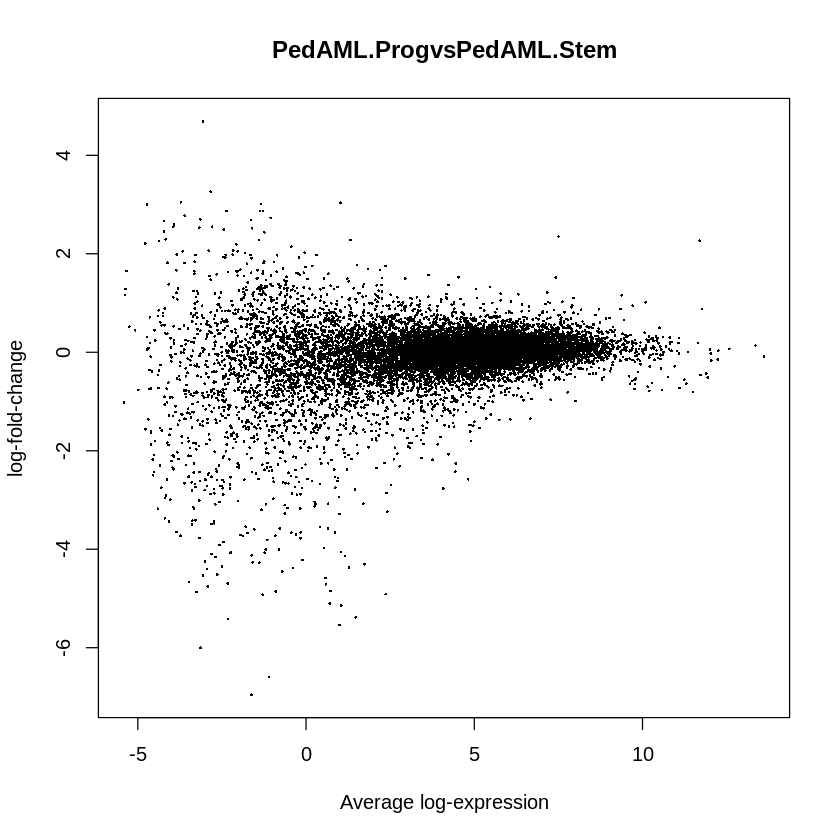

In [263]:
globalSummarizeTestsAndPlotMdForCoefficient(1, method=NULL, gModeratedVoomedFitForContrasts.paired.nocor,
                                            gLogThresholdedTestResults.paired.nocor, gContrastMatrix.paired.nocor,
                                            gVoomResult.paired.nocor, gGroupMetadataVector.paired)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for PedAML.ProgvsPedAML.Stem"

png 
  2

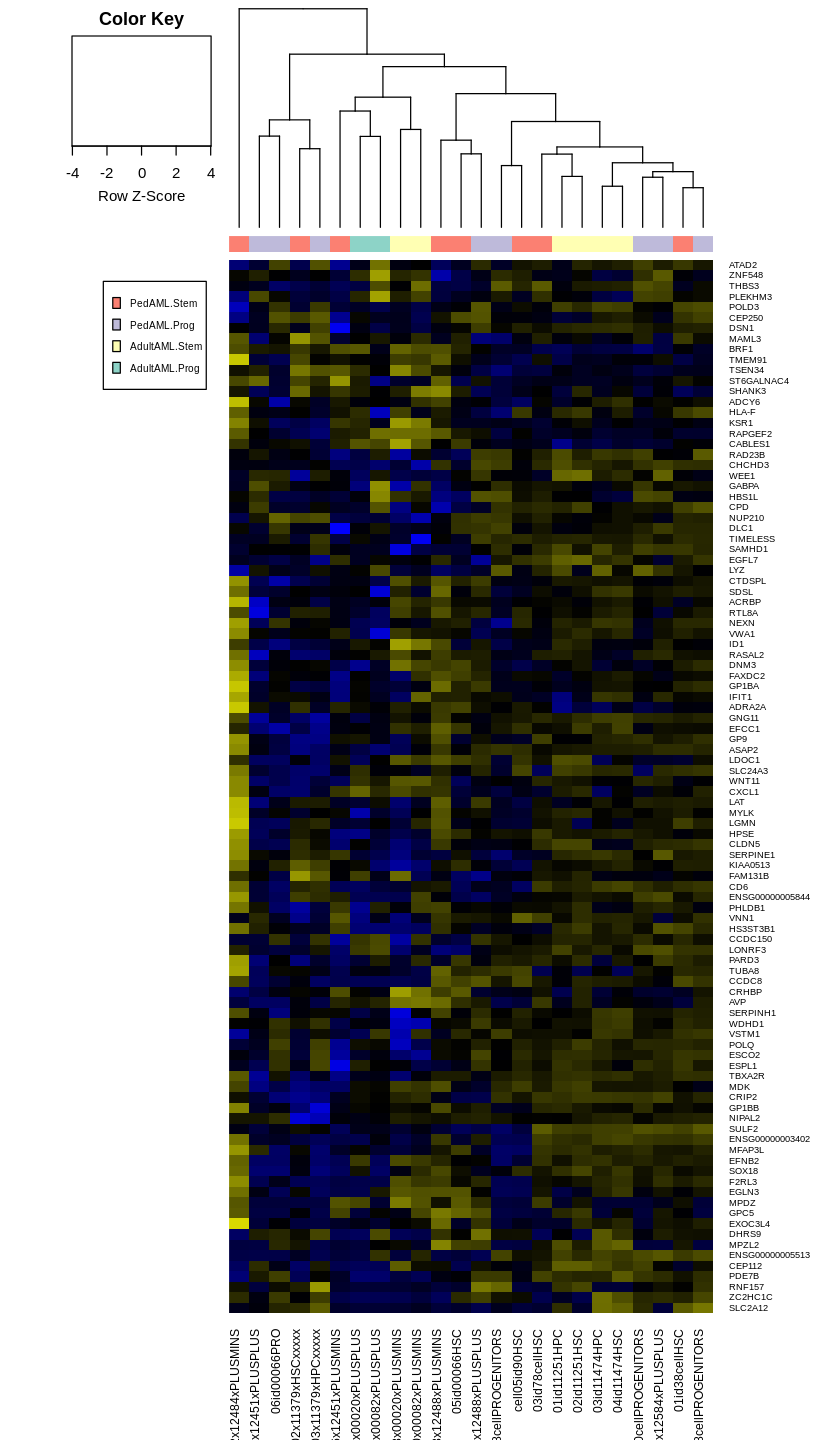

In [261]:
globalPlotTopHeatmapForCoefficient(1, c("all"), gModeratedVoomedFitForContrasts.paired.nocor,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.paired.nocor, gGroupMetadataVector.paired)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for PedAML.ProgvsPedAML.Stem"

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”

png 
  2

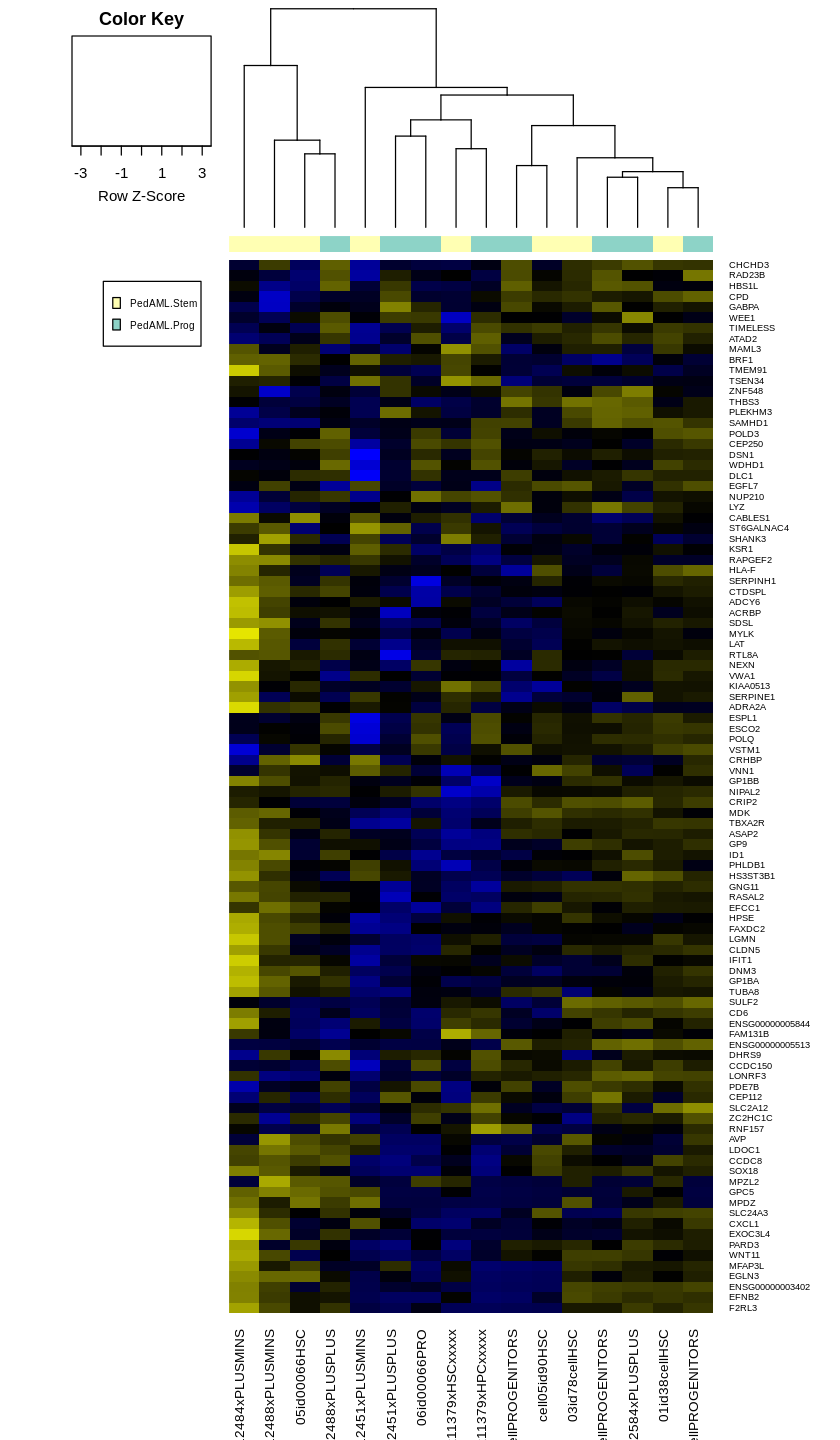

In [262]:
globalPlotTopHeatmapForCoefficient(1, c("PedAML.Prog", "PedAML.Stem"), gModeratedVoomedFitForContrasts.paired.nocor,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.paired.nocor, gGroupMetadataVector.paired)

[1] "Power calculation: x is fold-change, y is group size"

1.25       1.5       1.75      2        
3 0.04771028 0.0765756 0.1100182 0.1465372
6 0.06101389 0.1134574 0.1781099 0.2498181

[1] "Summary of AdultAML.ProgvsAdultAML.Stem Differential Expression"

Down NotSig     Up 
     5  12678      2

[1] "Top 20 Most Significantly Differentially Expressed Genes for AdultAML.ProgvsAdultAML.Stem"

ENSEMBL         ENTREZID SYMBOL  gene_type      logFC     
ENSG00000154734 ENSG00000154734 9510     ADAMTS1 protein_coding  -6.682450
ENSG00000125968 ENSG00000125968 3397     ID1     protein_coding  -5.244341
ENSG00000156475 ENSG00000156475 5521     PPP2R2B protein_coding  -8.860587
ENSG00000023445 ENSG00000023445 330      BIRC3   protein_coding  -3.524057
ENSG00000244734 ENSG00000244734 3043     HBB     protein_coding  10.234406
ENSG00000000003 ENSG00000000003 7105     TSPAN6  protein_coding  -9.210215
ENSG00000117289 ENSG00000117289 NA       NA      NA               1.959506
ENSG00000214530 ENSG00000214530 10809    STARD10 protein_coding  -1.799749
ENSG00000184058 ENSG00000184058 6899     TBX1    protein_coding   7.185590
ENSG00000186480 ENSG00000186480 3638     INSIG1  protein_coding  -2.132150
ENSG00000046889 ENSG00000046889 80243    PREX2   protein_coding -11.292101
ENSG00000168209 ENSG00000168209 54541    DDIT4   protein_coding  -2.647490
ENSG00000186812 ENSG00000186812 84307    ZNF397  protein_coding   7.530191
ENSG00000082196 ENSG00000082196 114899   C1QTNF3 protein_coding   6.699542
ENSG00000167384 ENSG00000167384 7733     ZNF180  protein_coding   5.003996
ENSG00000115738 ENSG00000115738 3398     ID2     protein_coding  -2.944962
ENSG00000177946 ENSG00000177946 92806    CENPBD1 protein_coding   8.093753
ENSG00000171161 ENSG00000171161 79894    ZNF672  protein_coding  -2.105850
ENSG00000059915 ENSG00000059915 5662     PSD     protein_coding  -2.861371
ENSG00000130844 ENSG00000130844 55422    ZNF331  protein_coding  -2.441633
                AveExpr    t         P.Value      adj.P.Val    B          
ENSG00000154734 -2.3334798 -9.771087 1.045777e-07 0.0007390622  7.12954838
ENSG00000125968  2.3246835 -9.687033 1.165254e-07 0.0007390622  7.33110427
ENSG00000156475 -3.6161972 -6.653149 9.870057e-06 0.0417338897  0.54029910
ENSG00000023445  3.7940189 -6.365746 1.596705e-05 0.0455816579  3.30222665
ENSG00000244734 -1.7572286  6.176186 2.206560e-05 0.0455816579  0.55797846
ENSG00000000003 -3.9414956 -6.110162 2.472610e-05 0.0455816579  0.18358205
ENSG00000117289 10.4781169  6.100254 2.515346e-05 0.0455816579  2.83533512
ENSG00000214530  3.1673969 -5.959399 3.213900e-05 0.0509604021  2.63501547
ENSG00000184058 -0.9524331  5.704812 5.039966e-05 0.0695446659 -0.14306297
ENSG00000186480  6.4037935 -5.657748 5.482433e-05 0.0695446659  2.07345612
ENSG00000046889 -1.6899458 -5.555961 6.583575e-05 0.0759205954 -0.02285941
ENSG00000168209  5.5457439 -5.274436 1.100218e-04 0.1074644511  1.33586302
ENSG00000186812  2.0912404  5.252711 1.145196e-04 0.1074644511 -0.47809901
ENSG00000082196  0.6832855  5.233732 1.186048e-04 0.1074644511 -0.41097805
ENSG00000167384  2.6908790  5.131157 1.434607e-04 0.1155305191  0.24811224
ENSG00000115738  6.4207932 -5.122756 1.457224e-04 0.1155305191  1.05824399
ENSG00000177946  2.0849730  4.957893 1.984438e-04 0.1479683592 -0.68681058
ENSG00000171161  5.3481107 -4.874156 2.324450e-04 0.1479683592  0.76514972
ENSG00000059915  1.5456738 -4.870574 2.340269e-04 0.1479683592  0.68943062
ENSG00000130844  5.0275666 -4.839663 2.481531e-04 0.1479683592  0.52693772

[1] "Output file: 20200228_DeWerf_Human_PediatricAML_differential_expression_20200305134352_AdultAML.ProgvsAdultAML.Stem_AllGenes.csv"
[1] "Output file: glimma-plots/20200228_DeWerf_Human_PediatricAML_differential_expression_20200305134352_AdultAML.ProgvsAdultAML.Stem_MaPlot_DiffExpFdrLte0.05_interactive.html"


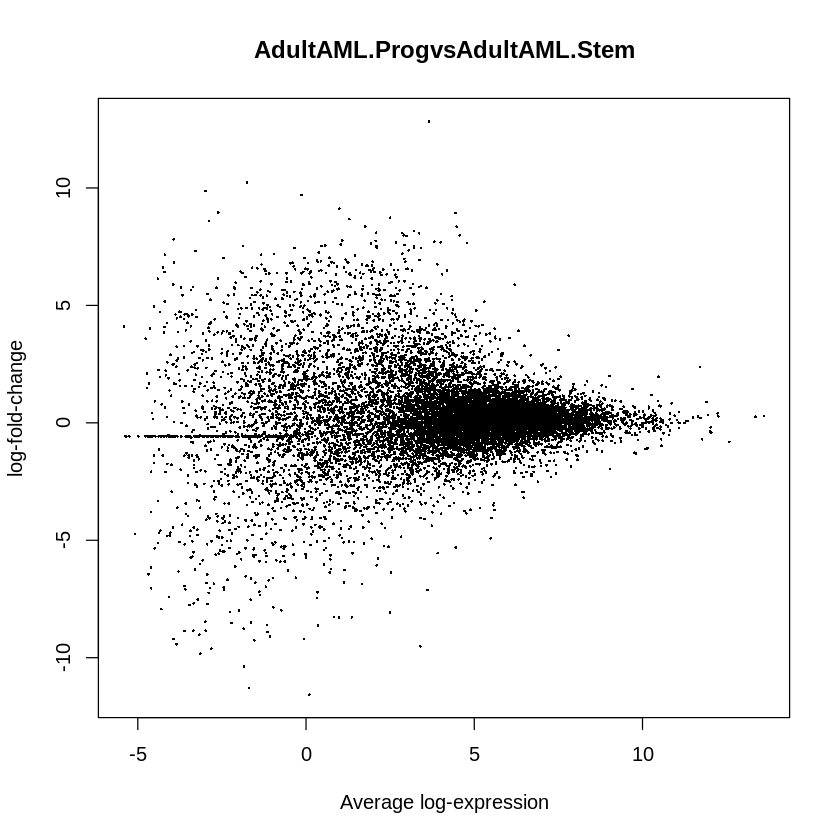

In [252]:
globalSummarizeTestsAndPlotMdForCoefficient(2, method=NULL, gModeratedVoomedFitForContrasts.paired.nocor,
                                                      gLogThresholdedTestResults.paired.nocor, gContrastMatrix.paired.nocor,
                                                      gVoomResult.paired.nocor,
                                                      gGroupMetadataVector.paired)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for AdultAML.ProgvsAdultAML.Stem"

png 
  2

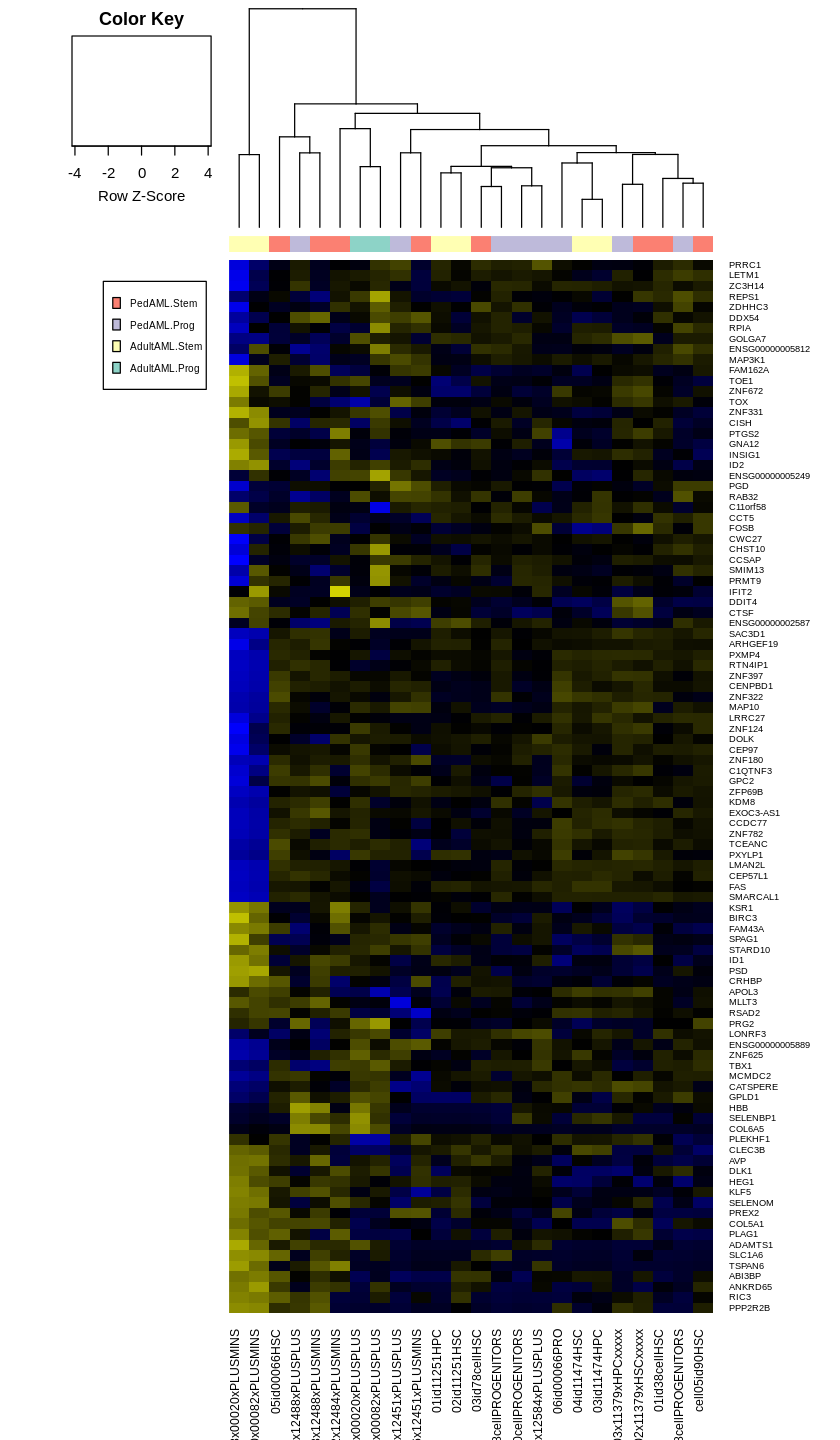

In [264]:
globalPlotTopHeatmapForCoefficient(2, c("all"), gModeratedVoomedFitForContrasts.paired.nocor,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.paired.nocor, gGroupMetadataVector.paired)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for AdultAML.ProgvsAdultAML.Stem"

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”

png 
  2

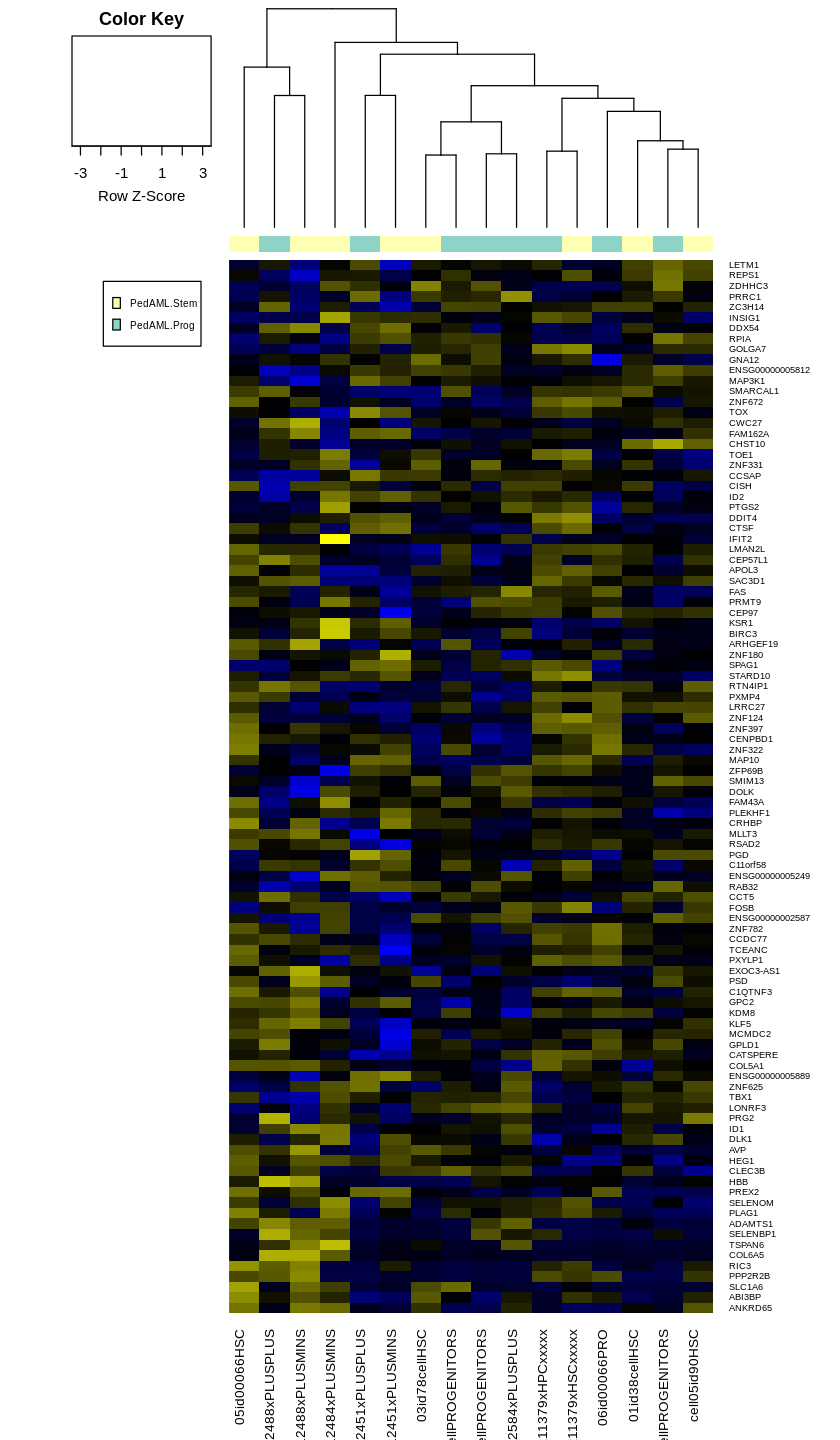

In [265]:
globalPlotTopHeatmapForCoefficient(2, c("PedAML.Prog", "PedAML.Stem"), gModeratedVoomedFitForContrasts.paired.nocor,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.paired.nocor, gGroupMetadataVector.paired)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for AdultAML.ProgvsAdultAML.Stem"

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”

png 
  2

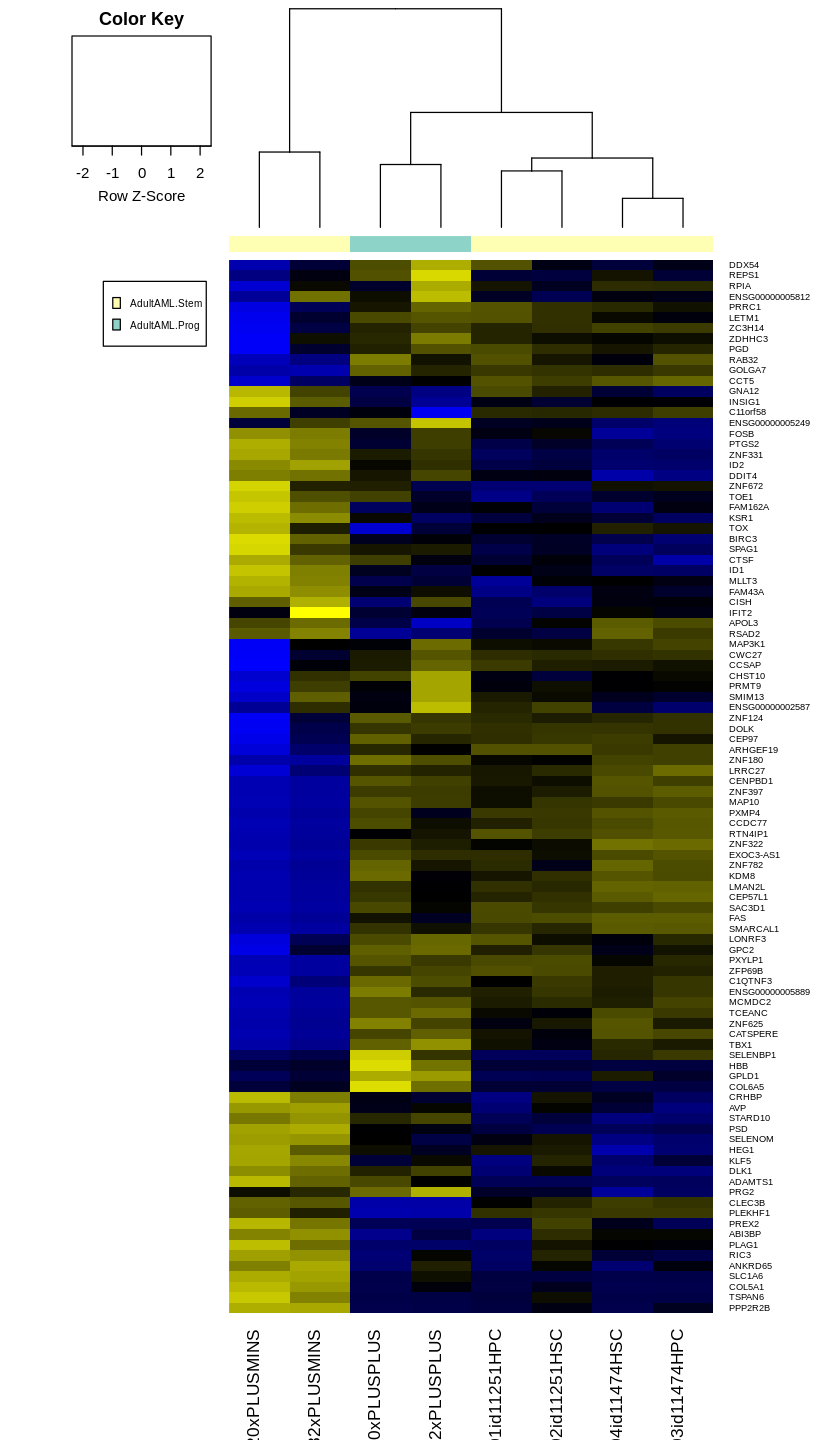

In [283]:
globalPlotTopHeatmapForCoefficient(2, c("AdultAML.Prog", "AdultAML.Stem"), gModeratedVoomedFitForContrasts.paired.nocor,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.paired.nocor, gGroupMetadataVector.paired)

[1] "Power calculation: x is fold-change, y is group size"

1.25       1.5       1.75      2       
9 0.07306285 0.1493042 0.2452706 0.349642
9 0.07306285 0.1493042 0.2452706 0.349642

[1] "Summary of PedAMLvsAdultAML Differential Expression"

Down NotSig     Up 
   122  11799     45

[1] "Top 20 Most Significantly Differentially Expressed Genes for PedAMLvsAdultAML"

ENSEMBL         ENTREZID  SYMBOL   gene_type      logFC    
ENSG00000228253 ENSG00000228253 4509      ATP8     protein_coding -2.563706
ENSG00000269028 ENSG00000269028 100462981 MTRNR2L2 protein_coding -2.228132
ENSG00000127022 ENSG00000127022 821       CANX     protein_coding  1.487963
ENSG00000198840 ENSG00000198840 4537      ND3      protein_coding -2.519886
ENSG00000212907 ENSG00000212907 4539      ND4L     protein_coding -2.145116
ENSG00000213741 ENSG00000213741 6235      RPS29    protein_coding -1.675473
ENSG00000255073 ENSG00000255073 NA        NA       protein_coding -6.743869
ENSG00000164163 ENSG00000164163 6059      ABCE1    protein_coding  1.704035
ENSG00000198938 ENSG00000198938 4514      COX3     protein_coding -2.532404
ENSG00000142892 ENSG00000142892 10026     PIGK     protein_coding  2.786214
ENSG00000067704 ENSG00000067704 55699     IARS2    protein_coding  1.550452
ENSG00000008128 ENSG00000008128 728642    CDK11A   protein_coding -2.230260
ENSG00000166734 ENSG00000166734 113201    CASC4    protein_coding  1.676694
ENSG00000198918 ENSG00000198918 6170      RPL39    protein_coding -1.521741
ENSG00000198886 ENSG00000198886 4538      ND4      protein_coding -2.494261
ENSG00000107798 ENSG00000107798 3988      LIPA     protein_coding  1.663779
ENSG00000181789 ENSG00000181789 22820     COPG1    protein_coding  1.038454
ENSG00000248333 ENSG00000248333 984       CDK11B   protein_coding -2.011863
ENSG00000109475 ENSG00000109475 6164      RPL34    protein_coding -1.517258
ENSG00000153006 ENSG00000153006 285672    SREK1IP1 protein_coding -1.436554
                AveExpr   t         P.Value      adj.P.Val  B       
ENSG00000228253  2.939750 -6.673027 2.308083e-06 0.00983868 4.569573
ENSG00000269028  3.341850 -6.608419 2.631193e-06 0.00983868 4.637987
ENSG00000127022  9.607920  6.552166 2.950487e-06 0.00983868 4.788898
ENSG00000198840  4.939344 -6.499028 3.288879e-06 0.00983868 4.660578
ENSG00000212907  5.959041 -5.964039 1.001735e-05 0.01590830 3.628453
ENSG00000213741  5.748023 -5.955902 1.019138e-05 0.01590830 3.611320
ENSG00000255073 -1.517464 -5.921380 1.096499e-05 0.01590830 1.685237
ENSG00000164163  7.184149  5.826137 1.342778e-05 0.01590830 3.344224
ENSG00000198938 11.731249 -5.824330 1.347967e-05 0.01590830 3.346652
ENSG00000142892  5.710209  5.776117 1.494212e-05 0.01590830 2.990412
ENSG00000067704  6.483238  5.675579 1.853899e-05 0.01590830 3.028696
ENSG00000008128  4.348456 -5.661819 1.909623e-05 0.01590830 2.998354
ENSG00000166734  6.594386  5.645107 1.979614e-05 0.01590830 2.975290
ENSG00000198918  7.601187 -5.643826 1.985088e-05 0.01590830 2.975613
ENSG00000198886 11.107445 -5.608981 2.140050e-05 0.01590830 2.910216
ENSG00000107798  6.963536  5.608045 2.144376e-05 0.01590830 2.908026
ENSG00000181789  7.039585  5.555673 2.401499e-05 0.01590830 2.802195
ENSG00000248333  3.149095 -5.547423 2.444795e-05 0.01590830 2.635418
ENSG00000109475  7.854577 -5.517378 2.609341e-05 0.01590830 2.714458
ENSG00000153006  4.099460 -5.468583 2.901134e-05 0.01590830 2.588912

[1] "Output file: 20200228_DeWerf_Human_PediatricAML_differential_expression_20200305134352_PedAMLvsAdultAML_AllGenes.csv"


ERROR: Error in data.frame(geneIds, anno): arguments imply differing number of rows: 11966, 12685


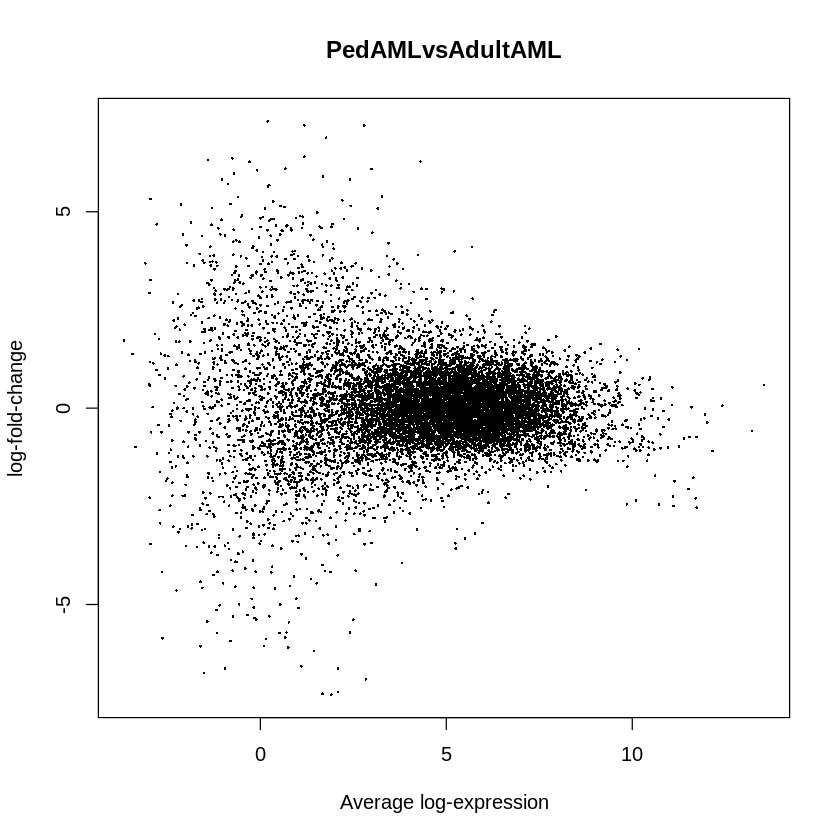

In [266]:
globalSummarizeTestsAndPlotMdForCoefficient(1, method=NULL, gModeratedVoomedFitForContrasts.prog,
                                            gLogThresholdedTestResults.prog, gContrastMatrix.prog,
                                            gVoomResult.prog, gGroupMetadataVector.prog)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for PedAMLvsAdultAML"

png 
  2

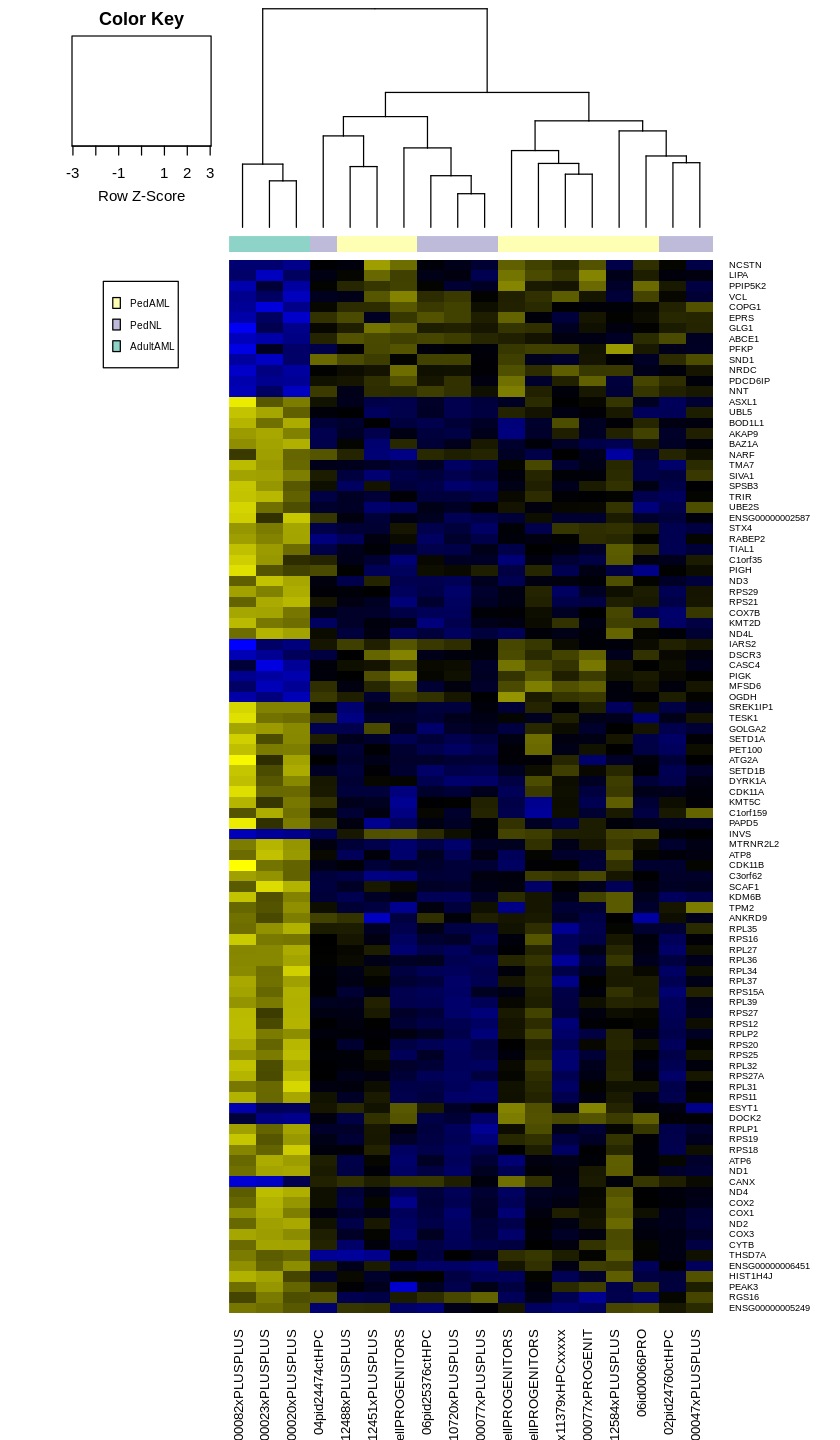

In [272]:
globalPlotTopHeatmapForCoefficient(1, c("all"), gModeratedVoomedFitForContrasts.prog,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.prog, gGroupMetadataVector.prog)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for PedAMLvsAdultAML"

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”

png 
  2

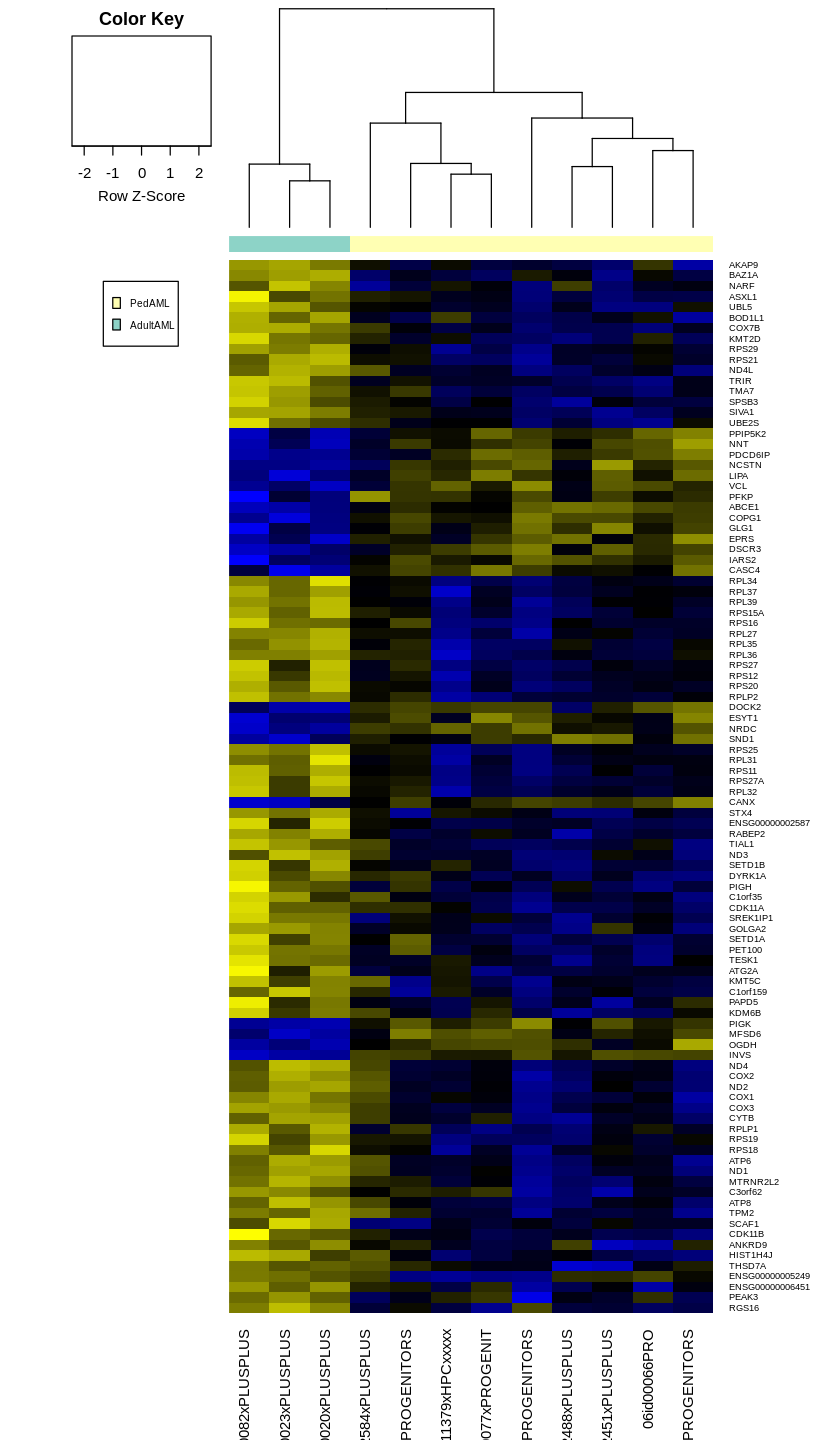

In [273]:
globalPlotTopHeatmapForCoefficient(1, c("PedAML", "AdultAML"), gModeratedVoomedFitForContrasts.prog,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.prog, gGroupMetadataVector.prog)

[1] "Power calculation: x is fold-change, y is group size"

1.25       1.5       1.75      2        
3 0.04771028 0.0765756 0.1100182 0.1465372
6 0.06101389 0.1134574 0.1781099 0.2498181

[1] "Summary of PedAMLvsPedNL Differential Expression"

Down NotSig     Up 
   516  11303    147

[1] "Top 20 Most Significantly Differentially Expressed Genes for PedAMLvsPedNL"

ENSEMBL         ENTREZID SYMBOL  gene_type      logFC    
ENSG00000081985 ENSG00000081985 3595     IL12RB2 protein_coding -8.059449
ENSG00000196368 ENSG00000196368 55190    NUDT11  protein_coding -8.272696
ENSG00000184860 ENSG00000184860 93517    SDR42E1 protein_coding -7.116862
ENSG00000114698 ENSG00000114698 57088    PLSCR4  protein_coding -7.905779
ENSG00000114405 ENSG00000114405 57415    C3orf14 protein_coding -6.286506
ENSG00000122824 ENSG00000122824 170685   NUDT10  protein_coding -8.491710
ENSG00000170627 ENSG00000170627 121355   GTSF1   protein_coding  2.628531
ENSG00000101938 ENSG00000101938 91851    CHRDL1  protein_coding -7.138982
ENSG00000082397 ENSG00000082397 23136    EPB41L3 protein_coding -7.294019
ENSG00000145020 ENSG00000145020 275      AMT     protein_coding -1.897685
ENSG00000169126 ENSG00000169126 55130    ARMC4   protein_coding -7.056809
ENSG00000147231 ENSG00000147231 55086    CXorf57 protein_coding -7.322341
ENSG00000198088 ENSG00000198088 54830    NUP62CL protein_coding -7.708369
ENSG00000153707 ENSG00000153707 5789     PTPRD   protein_coding -6.746779
ENSG00000046604 ENSG00000046604 1829     DSG2    protein_coding -8.597018
ENSG00000176273 ENSG00000176273 159371   SLC35G1 protein_coding -6.607265
ENSG00000162669 ENSG00000162669 164045   HFM1    protein_coding -6.414714
ENSG00000171033 ENSG00000171033 5569     PKIA    protein_coding -7.727265
ENSG00000107186 ENSG00000107186 8777     MPDZ    protein_coding -7.307605
ENSG00000066382 ENSG00000066382 744      MPPED2  protein_coding -6.526221
                AveExpr    t         P.Value      adj.P.Val    B       
ENSG00000081985 -0.3509481 -8.124781 1.409522e-07 0.0007797156 6.395387
ENSG00000196368 -1.9685622 -7.895136 2.152651e-07 0.0007797156 5.810994
ENSG00000184860 -2.9860444 -7.850443 2.339462e-07 0.0007797156 5.627804
ENSG00000114698 -2.4555239 -7.792620 2.606437e-07 0.0007797156 5.643726
ENSG00000114405 -1.9947118 -7.638634 3.483155e-07 0.0008335888 5.323611
ENSG00000122824 -2.2528955 -7.044839 1.097825e-06 0.0016111646 4.622542
ENSG00000170627  4.3056135  7.013134 1.168789e-06 0.0016111646 5.494183
ENSG00000101938 -2.7328425 -6.996499 1.207903e-06 0.0016111646 4.507019
ENSG00000082397 -1.9413638 -6.994869 1.211807e-06 0.0016111646 4.561086
ENSG00000145020  4.4070353 -6.927519 1.385120e-06 0.0016574343 5.331051
ENSG00000169126 -2.4995380 -6.816143 1.730110e-06 0.0018820454 4.238199
ENSG00000147231 -2.1675823 -6.742709 2.005183e-06 0.0019232736 4.196437
ENSG00000198088 -2.4857222 -6.695640 2.204920e-06 0.0019232736 4.123699
ENSG00000153707 -2.4758688 -6.659863 2.370419e-06 0.0019232736 4.040982
ENSG00000046604 -0.5304813 -6.634373 2.496120e-06 0.0019232736 4.154948
ENSG00000176273 -1.7370483 -6.619686 2.571651e-06 0.0019232736 4.004686
ENSG00000162669 -2.5625966 -6.436774 3.736796e-06 0.0026302649 3.669069
ENSG00000171033  0.2152742 -6.382345 4.179875e-06 0.0027786877 3.871125
ENSG00000107186 -2.5345136 -6.302169 4.933505e-06 0.0031070697 3.470070
ENSG00000066382 -1.9568244 -6.230271 5.728307e-06 0.0034272463 3.380904

[1] "Output file: 20200228_DeWerf_Human_PediatricAML_differential_expression_20200305134352_PedAMLvsPedNL_AllGenes.csv"


ERROR: Error in data.frame(geneIds, anno): arguments imply differing number of rows: 11966, 12685


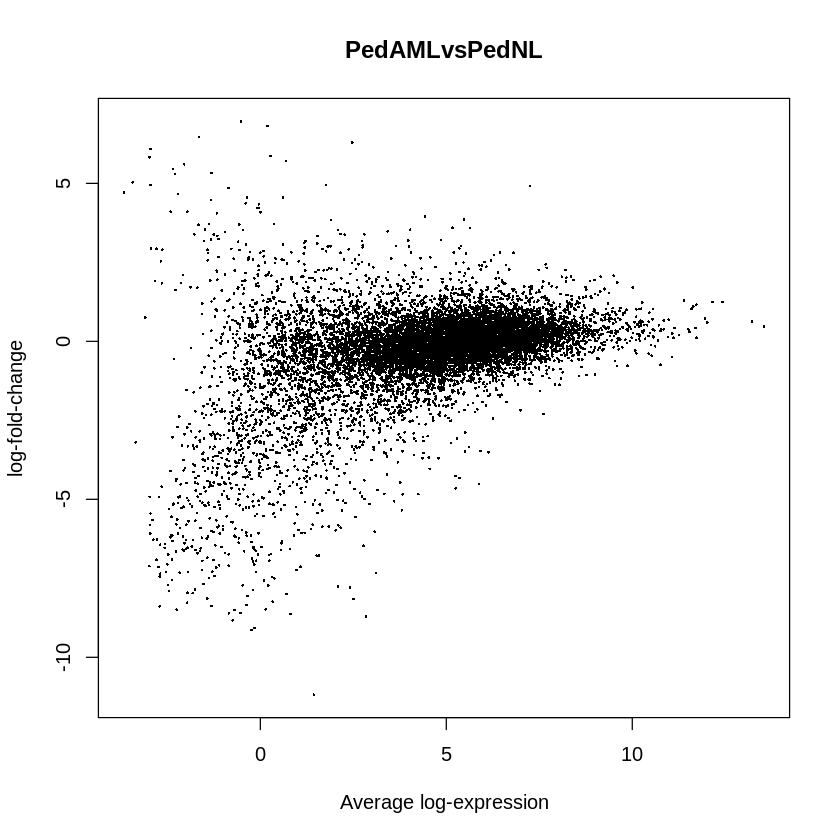

In [274]:
globalSummarizeTestsAndPlotMdForCoefficient(2, method=NULL, gModeratedVoomedFitForContrasts.prog,
                                            gLogThresholdedTestResults.prog, gContrastMatrix.prog,
                                            gVoomResult.prog, gGroupMetadataVector.prog)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for PedAMLvsPedNL"

png 
  2

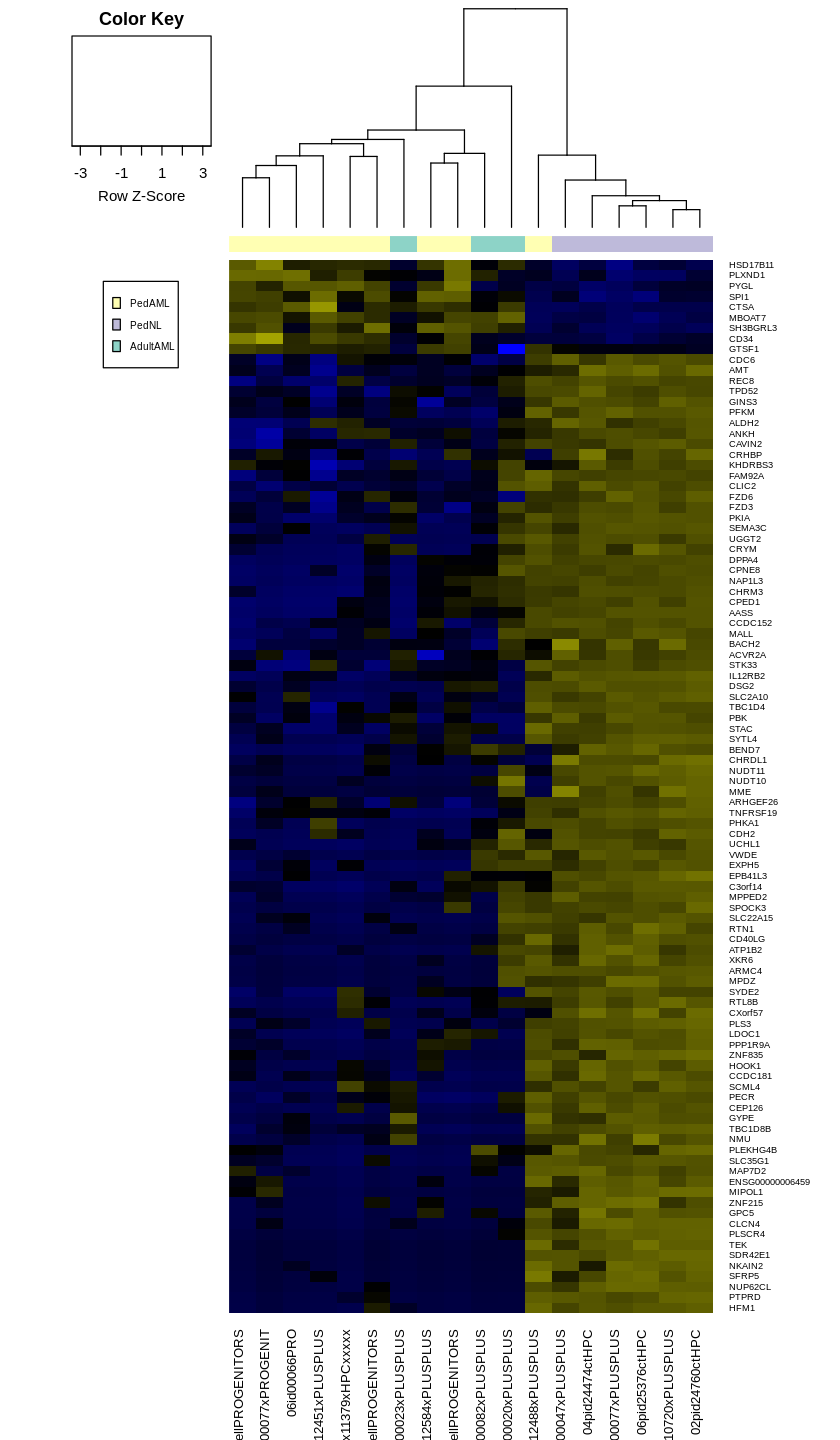

In [275]:
globalPlotTopHeatmapForCoefficient(2, c("all"), gModeratedVoomedFitForContrasts.prog,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.prog, gGroupMetadataVector.prog)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for PedAMLvsPedNL"

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”

png 
  2

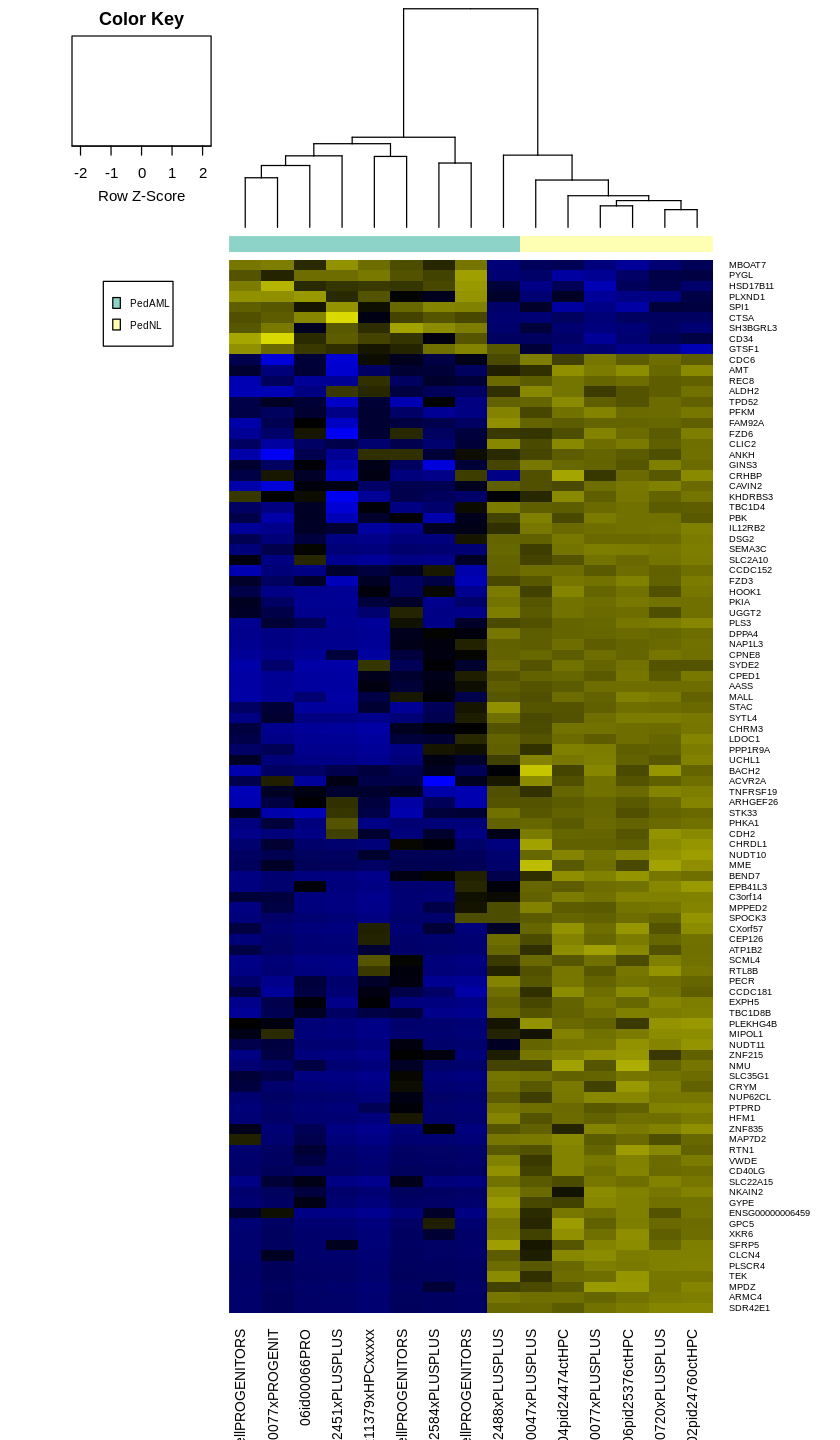

In [267]:
globalPlotTopHeatmapForCoefficient(2, c("PedAML", "PedNL"), gModeratedVoomedFitForContrasts.prog,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.prog, gGroupMetadataVector.prog)

[1] "Power calculation: x is fold-change, y is group size"

1.25       1.5       1.75      2       
9 0.07306285 0.1493042 0.2452706 0.349642
9 0.07306285 0.1493042 0.2452706 0.349642

[1] "Summary of PedAMLvsAdultAML Differential Expression"

Down NotSig     Up 
     0  11943      0

[1] "Top 20 Most Significantly Differentially Expressed Genes for PedAMLvsAdultAML"

ENSEMBL         ENTREZID SYMBOL  gene_type      logFC     
ENSG00000101187 ENSG00000101187 28231    SLCO4A1 protein_coding -2.6865606
ENSG00000182809 ENSG00000182809 1397     CRIP2   protein_coding -4.5485776
ENSG00000185477 ENSG00000185477 285513   GPRIN3  protein_coding -4.5169876
ENSG00000154655 ENSG00000154655 91133    L3MBTL4 protein_coding -5.4642574
ENSG00000173917 ENSG00000173917 3212     HOXB2   protein_coding -4.5285439
ENSG00000008056 ENSG00000008056 6853     SYN1    protein_coding -2.5963911
ENSG00000136146 ENSG00000136146 29079    MED4    protein_coding -0.7912904
ENSG00000250588 ENSG00000250588 NA       NA      NA             -2.8340112
ENSG00000164111 ENSG00000164111 308      ANXA5   protein_coding -3.4492734
ENSG00000163815 ENSG00000163815 7123     CLEC3B  protein_coding -4.7899597
ENSG00000047597 ENSG00000047597 7504     XK      protein_coding  6.6000249
ENSG00000154240 ENSG00000154240 201134   CEP112  protein_coding -5.3082429
ENSG00000169908 ENSG00000169908 4071     TM4SF1  protein_coding -5.2448235
ENSG00000113657 ENSG00000113657 1809     DPYSL3  protein_coding -4.8769250
ENSG00000157110 ENSG00000157110 11030    RBPMS   protein_coding -3.1691237
ENSG00000111276 ENSG00000111276 1027     CDKN1B  protein_coding -1.0523261
ENSG00000171148 ENSG00000171148 10474    TADA3   protein_coding  1.3178461
ENSG00000150907 ENSG00000150907 2308     FOXO1   protein_coding -3.3749006
ENSG00000106538 ENSG00000106538 5919     RARRES2 protein_coding -3.9521672
ENSG00000182636 ENSG00000182636 4692     NDN     protein_coding -5.9252000
                AveExpr     t         P.Value      adj.P.Val B        
ENSG00000101187  4.26194365 -4.383998 0.0003116462 0.8927603 -4.410625
ENSG00000182809  4.50831593 -4.118335 0.0005729625 0.8927603 -4.419395
ENSG00000185477  1.00024605 -4.101085 0.0005961046 0.8927603 -4.565182
ENSG00000154655  0.38697099 -4.079454 0.0006264530 0.8927603 -4.571990
ENSG00000173917  3.53808964 -4.054080 0.0006640319 0.8927603 -4.518224
ENSG00000008056  2.16804479 -3.905809 0.0009333337 0.8927603 -4.537865
ENSG00000136146  6.63244279 -3.900689 0.0009443676 0.8927603 -4.236889
ENSG00000250588  3.28025301 -3.894040 0.0009588912 0.8927603 -4.516007
ENSG00000164111  6.19486178 -3.830769 0.0011087447 0.8927603 -4.303854
ENSG00000163815  1.71417438 -3.815922 0.0011471624 0.8927603 -4.556725
ENSG00000047597 -1.01183865  3.768220 0.0012797852 0.8927603 -4.581468
ENSG00000154240 -0.87163081 -3.766050 0.0012861701 0.8927603 -4.576828
ENSG00000169908  3.54021078 -3.728544 0.0014016292 0.8927603 -4.518400
ENSG00000113657  0.80094501 -3.708986 0.0014658653 0.8927603 -4.564276
ENSG00000157110  4.78106060 -3.605509 0.0018575446 0.8927603 -4.461675
ENSG00000111276  4.04562907 -3.577581 0.0019799588 0.8927603 -4.452547
ENSG00000171148  5.79009968  3.512852 0.0022951976 0.8927603 -4.367540
ENSG00000150907  5.38733051 -3.479523 0.0024763411 0.8927603 -4.423631
ENSG00000106538 -0.07888698 -3.477367 0.0024885329 0.8927603 -4.571934
ENSG00000182636  0.99422584 -3.466953 0.0025482584 0.8927603 -4.571443

[1] "Output file: 20200228_DeWerf_Human_PediatricAML_differential_expression_20200305134352_PedAMLvsAdultAML_AllGenes.csv"


ERROR: Error in data.frame(geneIds, anno): arguments imply differing number of rows: 11943, 12685


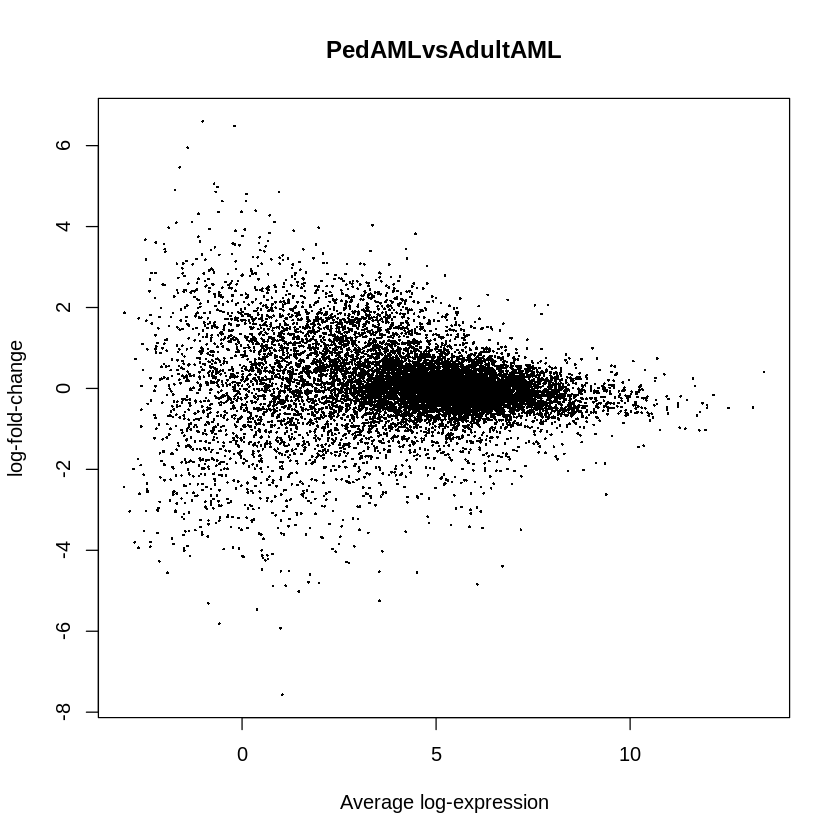

In [268]:
globalSummarizeTestsAndPlotMdForCoefficient(1, method=NULL, gModeratedVoomedFitForContrasts.stem,
                                            gLogThresholdedTestResults.stem, gContrastMatrix.stem,
                                            gVoomResult.stem, gGroupMetadataVector.stem)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for PedAMLvsAdultAML"

png 
  2

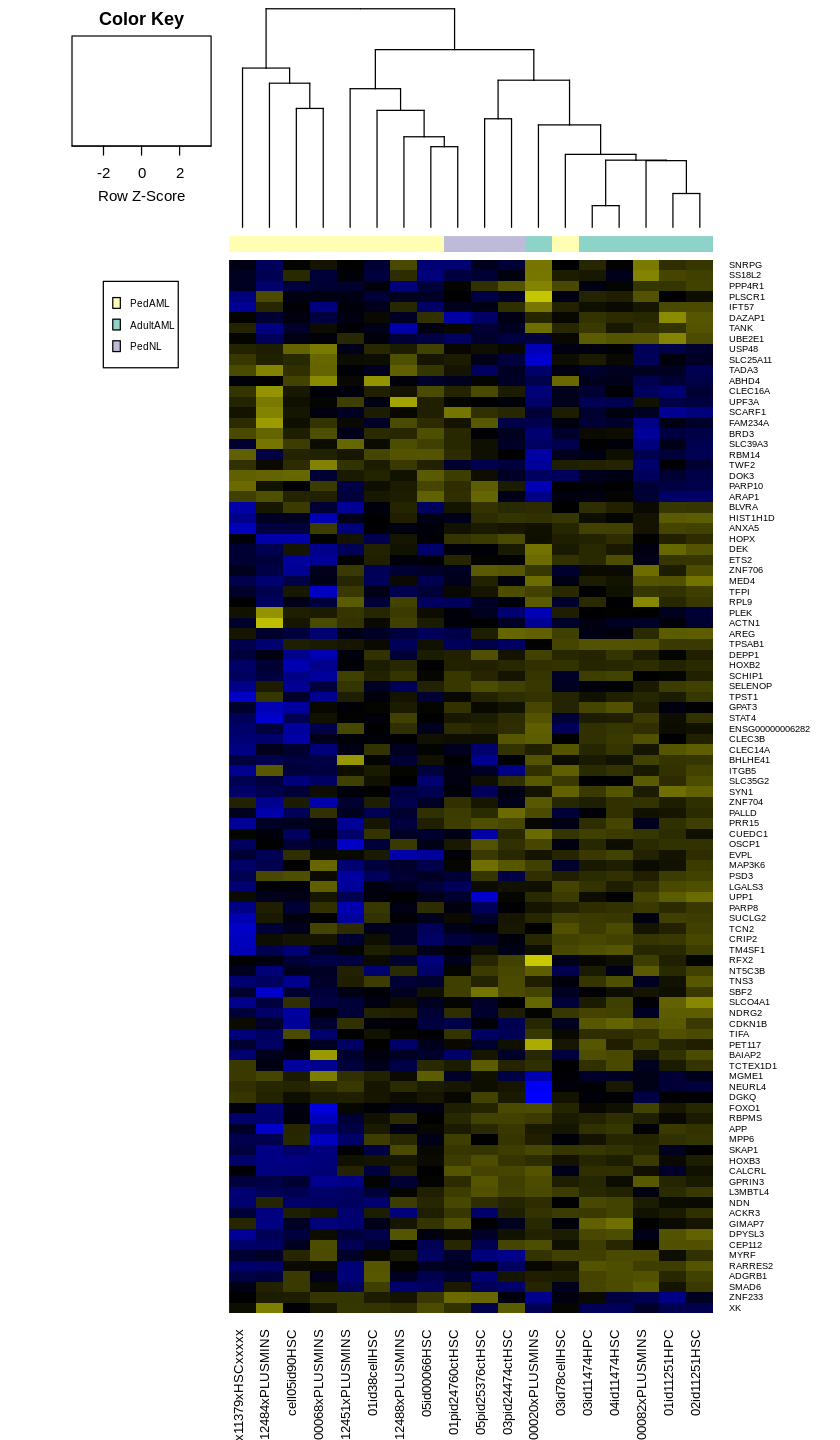

In [270]:
globalPlotTopHeatmapForCoefficient(1, c("all"), gModeratedVoomedFitForContrasts.stem,
                                  #gLogThresholdTestResults.stem, #gContrastMatrix.stem,
                                  gVoomResult.stem, gGroupMetadataVector.stem)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for PedAMLvsAdultAML"

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”

png 
  2

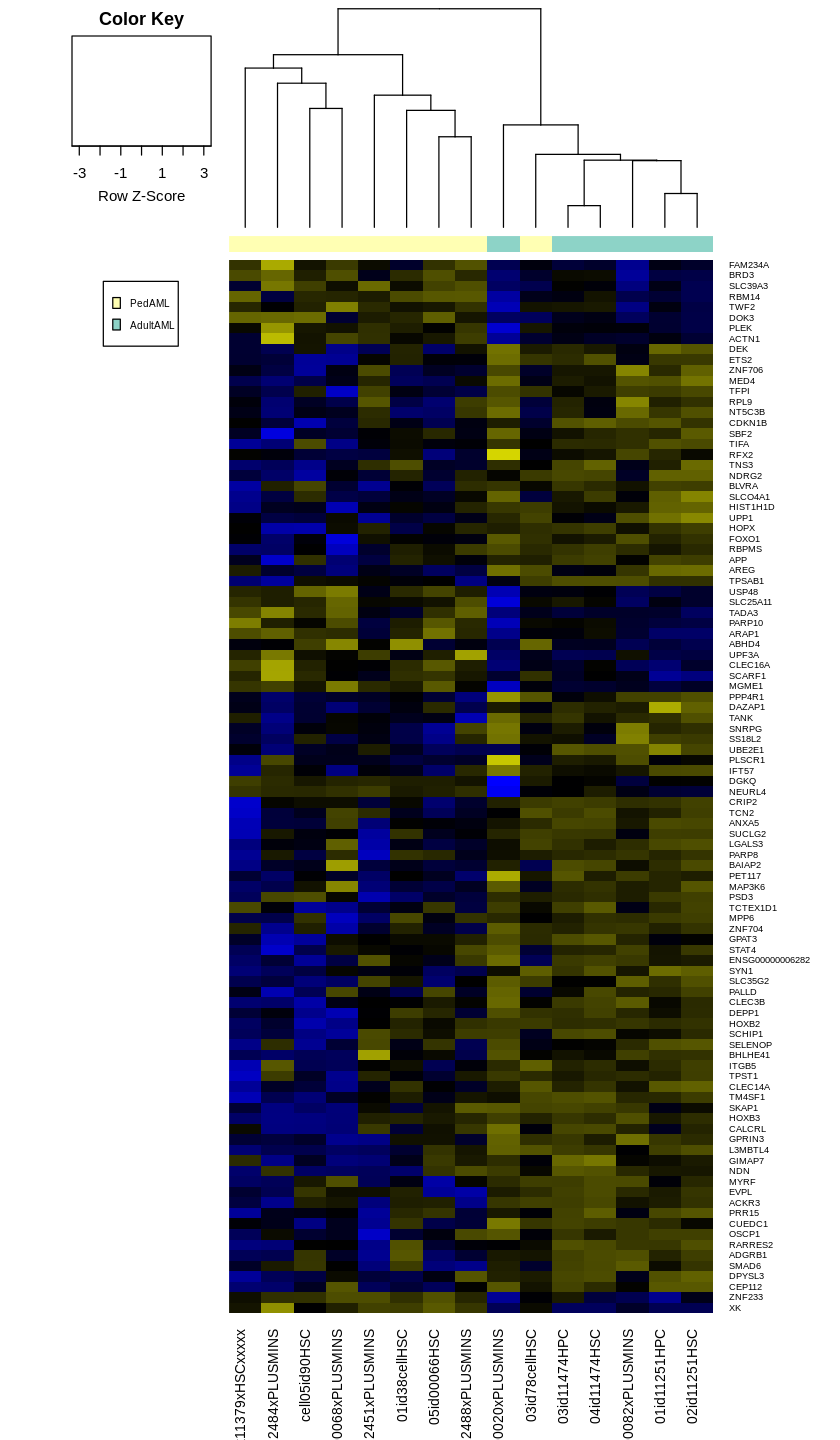

In [271]:
globalPlotTopHeatmapForCoefficient(1, c("PedAML", "AdultAML"), gModeratedVoomedFitForContrasts.stem,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.stem, gGroupMetadataVector.stem)

[1] "Power calculation: x is fold-change, y is group size"

1.25       1.5       1.75      2        
3 0.04771028 0.0765756 0.1100182 0.1465372
6 0.06101389 0.1134574 0.1781099 0.2498181

[1] "Summary of PedAMLvsPedNL Differential Expression"

Down NotSig     Up 
   172  11765      6

[1] "Top 20 Most Significantly Differentially Expressed Genes for PedAMLvsPedNL"

ENSEMBL         ENTREZID SYMBOL  gene_type      logFC    
ENSG00000164035 ENSG00000164035 51705    EMCN    protein_coding -8.178791
ENSG00000113083 ENSG00000113083 4015     LOX     protein_coding -5.146598
ENSG00000179869 ENSG00000179869 154664   ABCA13  protein_coding -7.972958
ENSG00000168306 ENSG00000168306 8309     ACOX2   protein_coding -8.275317
ENSG00000122824 ENSG00000122824 170685   NUDT10  protein_coding -7.660159
ENSG00000130635 ENSG00000130635 1289     COL5A1  protein_coding -7.550930
ENSG00000158528 ENSG00000158528 55607    PPP1R9A protein_coding -7.391353
ENSG00000046604 ENSG00000046604 1829     DSG2    protein_coding -8.708260
ENSG00000130413 ENSG00000130413 65975    STK33   protein_coding -7.084447
ENSG00000081985 ENSG00000081985 3595     IL12RB2 protein_coding -7.271747
ENSG00000112796 ENSG00000112796 59084    ENPP5   protein_coding -6.805020
ENSG00000154330 ENSG00000154330 5239     PGM5    protein_coding -8.925707
ENSG00000144057 ENSG00000144057 84620    ST6GAL2 protein_coding -7.160613
ENSG00000270466 ENSG00000270466 NA       NA      NA             -7.359041
ENSG00000134709 ENSG00000134709 51361    HOOK1   protein_coding -7.021627
ENSG00000130147 ENSG00000130147 23677    SH3BP4  protein_coding -8.997543
ENSG00000205978 ENSG00000205978 57523    NYNRIN  protein_coding -3.583602
ENSG00000154655 ENSG00000154655 91133    L3MBTL4 protein_coding -7.009405
ENSG00000133026 ENSG00000133026 4628     MYH10   protein_coding -4.251652
ENSG00000108924 ENSG00000108924 3131     HLF     protein_coding -7.947521
                AveExpr    t         P.Value      adj.P.Val  B       
ENSG00000164035 -2.1032230 -6.440828 3.377727e-06 0.01105370 3.639813
ENSG00000113083  0.4525780 -6.231750 5.234875e-06 0.01105370 4.134307
ENSG00000179869 -1.8855124 -6.215534 5.417111e-06 0.01105370 3.415315
ENSG00000168306 -1.4498139 -6.208316 5.500303e-06 0.01105370 3.365444
ENSG00000122824 -2.5995584 -6.198252 5.618510e-06 0.01105370 3.219015
ENSG00000130635  0.1222060 -6.155332 6.152728e-06 0.01105370 3.796758
ENSG00000158528 -1.5001276 -6.042206 7.825691e-06 0.01105370 3.180556
ENSG00000046604 -0.1266091 -6.001043 8.544851e-06 0.01105370 3.379847
ENSG00000130413 -1.1747192 -5.963213 9.265627e-06 0.01105370 3.094028
ENSG00000081985  1.1382333 -5.905950 1.047754e-05 0.01105370 3.422023
ENSG00000112796 -2.4656406 -5.905130 1.049602e-05 0.01105370 2.857293
ENSG00000154330 -1.4036929 -5.878860 1.110646e-05 0.01105370 2.846397
ENSG00000144057 -1.3677443 -5.819600 1.262086e-05 0.01159469 2.973198
ENSG00000270466 -3.0271410 -5.717858 1.573351e-05 0.01217816 2.490182
ENSG00000134709 -1.6034833 -5.694750 1.654413e-05 0.01217816 2.546925
ENSG00000130147  1.1267088 -5.676301 1.722197e-05 0.01217816 2.769025
ENSG00000205978  3.5968592 -5.653045 1.811714e-05 0.01217816 3.038084
ENSG00000154655  0.3869710 -5.639099 1.867665e-05 0.01217816 2.550425
ENSG00000133026  2.7135484 -5.605040 2.011879e-05 0.01217816 2.960735
ENSG00000108924  0.7804323 -5.598829 2.039380e-05 0.01217816 2.809183

[1] "Output file: 20200228_DeWerf_Human_PediatricAML_differential_expression_20200305134352_PedAMLvsPedNL_AllGenes.csv"


ERROR: Error in data.frame(geneIds, anno): arguments imply differing number of rows: 11943, 12685


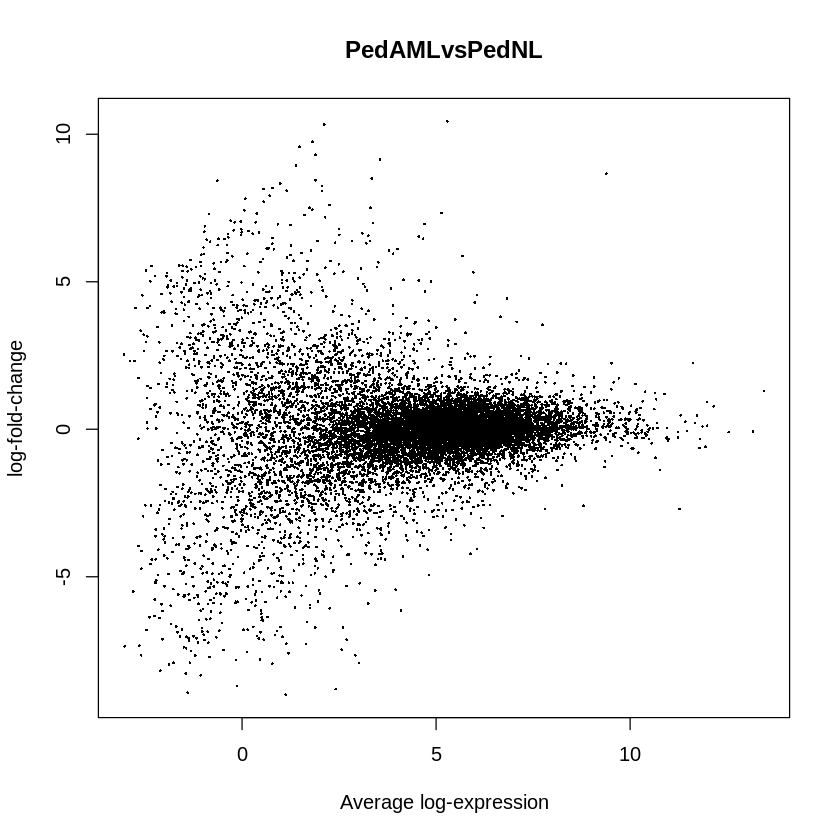

In [269]:
globalSummarizeTestsAndPlotMdForCoefficient(2, method=NULL, gModeratedVoomedFitForContrasts.stem,
                                            gLogThresholdedTestResults.stem, gContrastMatrix.stem,
                                            gVoomResult.stem, gGroupMetadataVector.stem)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for PedAMLvsPedNL"

png 
  2

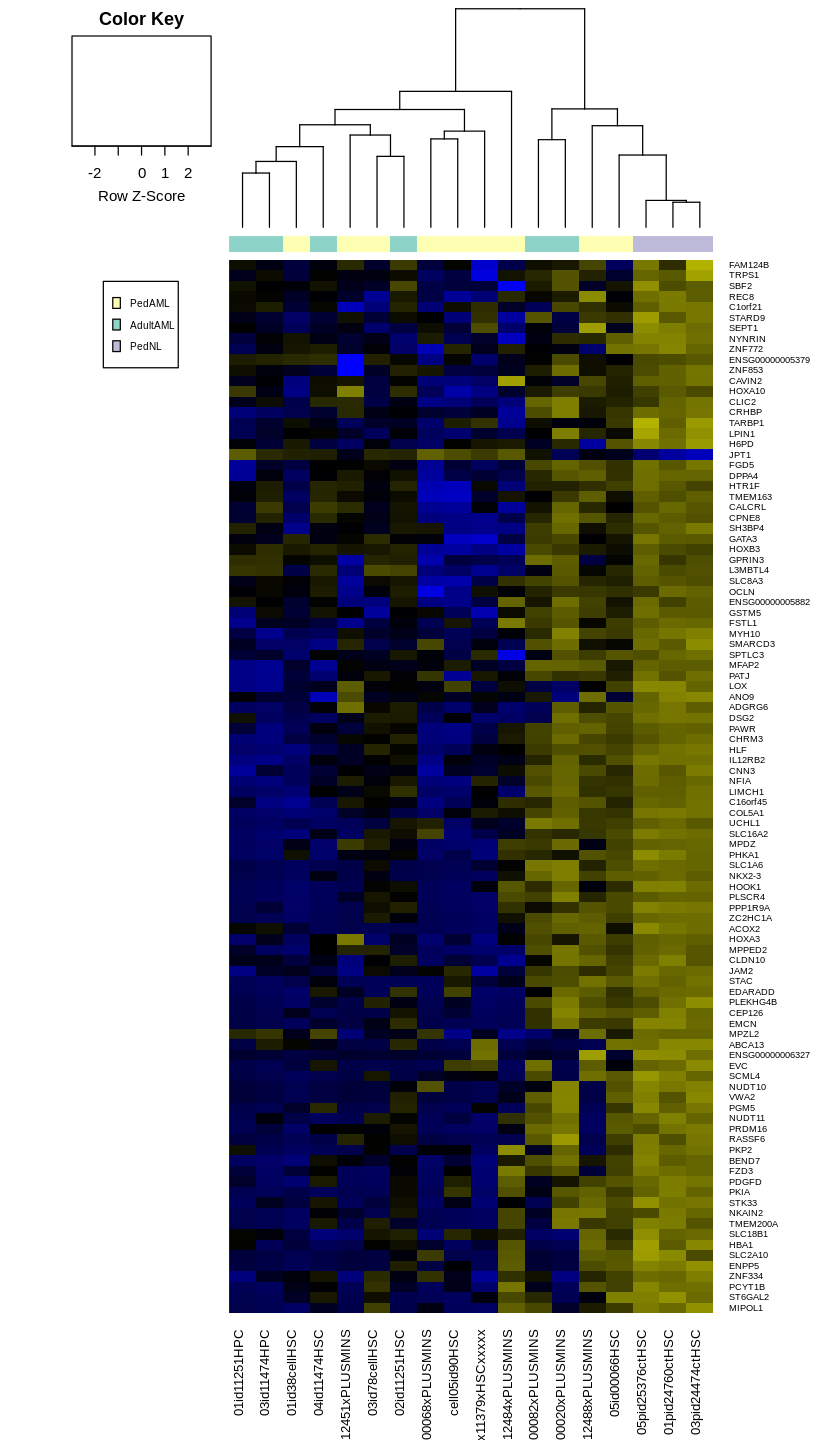

In [276]:
globalPlotTopHeatmapForCoefficient(2, c("all"), gModeratedVoomedFitForContrasts.stem,
                                  #gLogThresholdTestResults.stem, #gContrastMatrix.stem,
                                  gVoomResult.stem, gGroupMetadataVector.stem)

[1] "Heatmap of Top 100 Most Significantly Differentially Expressed Genes for PedAMLvsPedNL"

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”

png 
  2

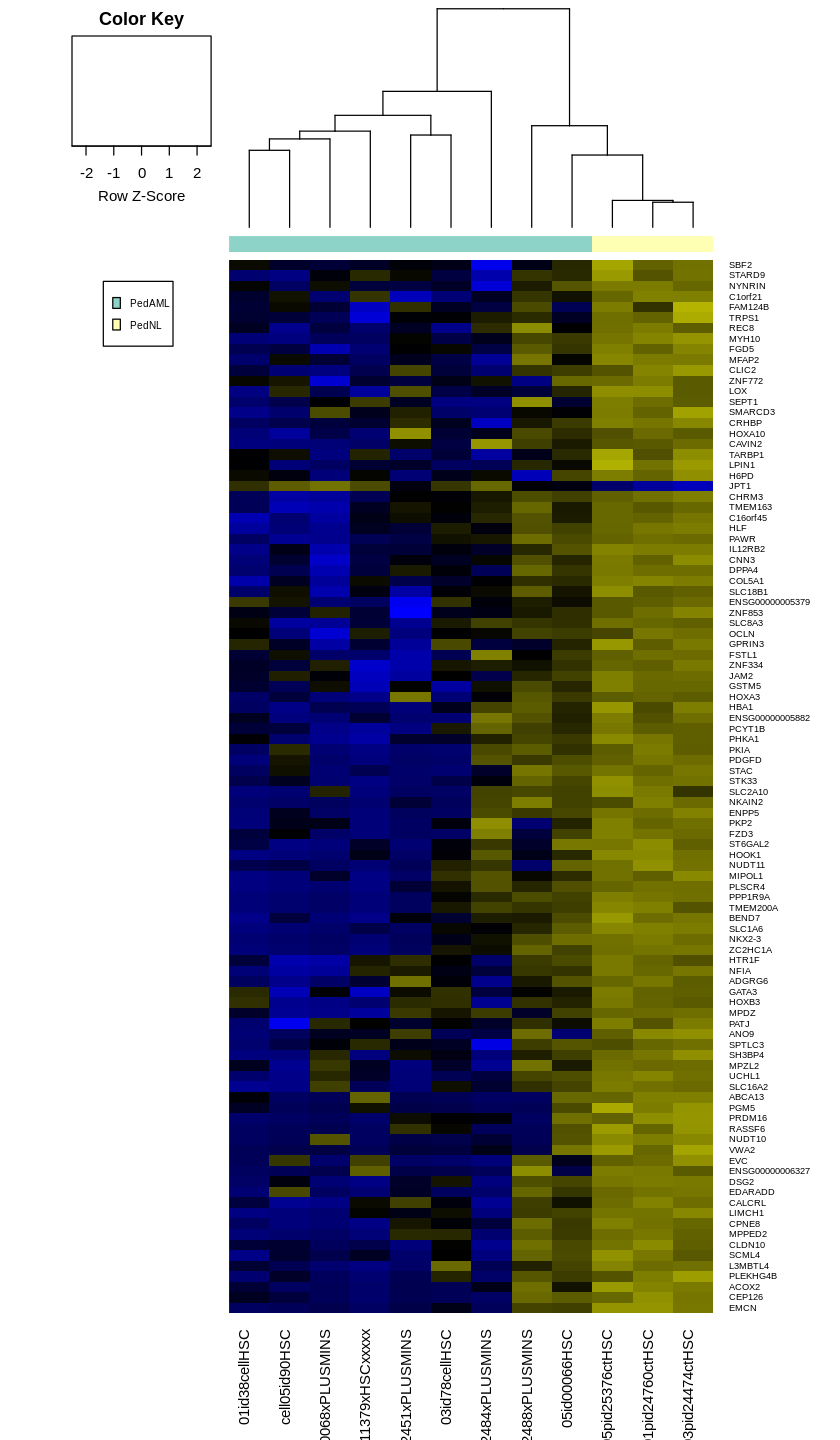

In [277]:
globalPlotTopHeatmapForCoefficient(2, c("PedAML", "PedNL"), gModeratedVoomedFitForContrasts.stem,
                                  #gLogThresholdTestResults.paired.nocor, #gContrastMatrix.paired.nocor,
                                  gVoomResult.stem, gGroupMetadataVector.stem)

[Table of Contents](#Table-of-Contents)

Save the workspace objects for future reference:


In [282]:
ls()
ls(globalenv())
ls(gPreviousStepEnv)

[1] "composeFileNameForCoefficient"                                 
  [2] "composeFileNameForHeatmap"                                     
  [3] "corfit"                                                        
  [4] "doAndPrintScaledPcaOnSamplesAsRowsDf"                          
  [5] "doPcaFromSamplesAsColsDf"                                      
  [6] "doPowerCalculation"                                            
  [7] "doScaledPcaOnSamplesAsRowsDf"                                  
  [8] "drawExamplePlot"                                               
  [9] "drawExamplePlots"                                              
 [10] "expandDesignDf"                                                
 [11] "expandPlot"                                                    
 [12] "findPlotAspectRatio"                                           
 [13] "gAllGenesDesc"                                                 
 [14] "gBcv"                                                          
 [15] "gBcv.prog"                                                     
 [16] "gBcv.stem"                                                     
 [17] "gCommonDispersion"                                             
 [18] "gCommonDispersion.prog"                                        
 [19] "gCommonDispersion.stem"                                        
 [20] "gContrastMatrix"                                               
 [21] "gContrastMatrix.paired"                                        
 [22] "gContrastMatrix.paired.nocor"                                  
 [23] "gContrastMatrix.prog"                                          
 [24] "gContrastMatrix.stem"                                          
 [25] "gContrastMatrix2"                                              
 [26] "gDefaultHeight"                                                
 [27] "gDefaultWidth"                                                 
 [28] "gDesignModel"                                                  
 [29] "gDesignModel.paired"                                           
 [30] "gDesignModel.paired.nocor"                                     
 [31] "gDesignModel.prog"                                             
 [32] "gDesignModel.stem"                                             
 [33] "gDgeList"                                                      
 [34] "gene.uni"                                                      
 [35] "generateGroupMeansDesignModel"                                 
 [36] "generateGroupMeansDesignModel2"                                
 [37] "generateGroupMeansDesignModel3"                                
 [38] "getCpmsDf"                                                     
 [39] "getHotellingT2Ellipse"                                         
 [40] "getHotellingT2EllipseCenterAndRadii"                           
 [41] "getNumSamplesInGroup"                                          
 [42] "getWhetherPointsAreOutliers"                                   
 [43] "gGeneIdCol"                                                    
 [44] "gGeneType"                                                     
 [45] "gGroupMetadataColName1"                                        
 [46] "gGroupMetadataColName2"                                        
 [47] "gGroupMetadataVector"                                          
 [48] "gGroupMetadataVector.paired"                                   
 [49] "gGroupMetadataVector.prog"                                     
 [50] "gGroupMetadataVector.stem"                                     
 [51] "gHeatmapDesc"                                                  
 [52] "gInterimDir"                                                   
 [53] "globalDoPowerCalculation"                                      
 [54] "globalPlotTopHeatmapForCoefficient"                            
 [55] "globalSummarizeTestsAndPlotMdForCoefficient"                   
 [56] "gLog2AbsFcThreshold"                                           
 [57] "gLogThresholdedTest

[1] "composeFileNameForCoefficient"                                 
  [2] "composeFileNameForHeatmap"                                     
  [3] "corfit"                                                        
  [4] "doAndPrintScaledPcaOnSamplesAsRowsDf"                          
  [5] "doPcaFromSamplesAsColsDf"                                      
  [6] "doPowerCalculation"                                            
  [7] "doScaledPcaOnSamplesAsRowsDf"                                  
  [8] "drawExamplePlot"                                               
  [9] "drawExamplePlots"                                              
 [10] "expandDesignDf"                                                
 [11] "expandPlot"                                                    
 [12] "findPlotAspectRatio"                                           
 [13] "gAllGenesDesc"                                                 
 [14] "gBcv"                                                          
 [15] "gBcv.prog"                                                     
 [16] "gBcv.stem"                                                     
 [17] "gCommonDispersion"                                             
 [18] "gCommonDispersion.prog"                                        
 [19] "gCommonDispersion.stem"                                        
 [20] "gContrastMatrix"                                               
 [21] "gContrastMatrix.paired"                                        
 [22] "gContrastMatrix.paired.nocor"                                  
 [23] "gContrastMatrix.prog"                                          
 [24] "gContrastMatrix.stem"                                          
 [25] "gContrastMatrix2"                                              
 [26] "gDefaultHeight"                                                
 [27] "gDefaultWidth"                                                 
 [28] "gDesignModel"                                                  
 [29] "gDesignModel.paired"                                           
 [30] "gDesignModel.paired.nocor"                                     
 [31] "gDesignModel.prog"                                             
 [32] "gDesignModel.stem"                                             
 [33] "gDgeList"                                                      
 [34] "gene.uni"                                                      
 [35] "generateGroupMeansDesignModel"                                 
 [36] "generateGroupMeansDesignModel2"                                
 [37] "generateGroupMeansDesignModel3"                                
 [38] "getCpmsDf"                                                     
 [39] "getHotellingT2Ellipse"                                         
 [40] "getHotellingT2EllipseCenterAndRadii"                           
 [41] "getNumSamplesInGroup"                                          
 [42] "getWhetherPointsAreOutliers"                                   
 [43] "gGeneIdCol"                                                    
 [44] "gGeneType"                                                     
 [45] "gGroupMetadataColName1"                                        
 [46] "gGroupMetadataColName2"                                        
 [47] "gGroupMetadataVector"                                          
 [48] "gGroupMetadataVector.paired"                                   
 [49] "gGroupMetadataVector.prog"                                     
 [50] "gGroupMetadataVector.stem"                                     
 [51] "gHeatmapDesc"                                                  
 [52] "gInterimDir"                                                   
 [53] "globalDoPowerCalculation"                                      
 [54] "globalPlotTopHeatmapForCoefficient"                            
 [55] "globalSummarizeTestsAndPlotMdForCoefficient"                   
 [56] "gLog2AbsFcThreshold"                                           
 [57] "gLogThresholdedTest

[1] "doAndPrintScaledPcaOnSamplesAsRowsDf"    
 [2] "doPcaFromSamplesAsColsDf"                
 [3] "doRawCountsPca"                          
 [4] "doScaledPcaOnSamplesAsRowsDf"            
 [5] "expandDesignDf"                          
 [6] "expandPlot"                              
 [7] "filterDgeListByCpmThresholdForNumSamples"
 [8] "findPlotAspectRatio"                     
 [9] "gDgeList"                                
[10] "gDgeList.prog"                           
[11] "gDgeList.stem"                           
[12] "getCpmsDf"                               
[13] "getHotellingT2Ellipse"                   
[14] "getHotellingT2EllipseCenterAndRadii"     
[15] "getWhetherPointsAreOutliers"             
[16] "gFilteredDgeList"                        
[17] "gFilteredDgeList.prog"                   
[18] "gFilteredDgeList.stem"                   
[19] "gGeneIdCol"                              
[20] "gGeneType"                               
[21] "gGroupColumns"                           
[22] "gGroupColumnsA"                          
[23] "gInterimDir"                             
[24] "gMinExclusiveCpms"                       
[25] "gMinInclusiveNumSamples"                 
[26] "gOrigNormedFilteredDgeList"              
[27] "gOrigNormedFilteredDgeList.prog"         
[28] "gOrigNormedFilteredDgeList.stem"         
[29] "gOutputDir"                              
[30] "gPreviousStepEnv"                        
[31] "gPreviousStepRdataFp"                    
[32] "gProjectName"                            
[33] "gRunName"                                
[34] "gSampleColName"                          
[35] "gSourceDir"                              
[36] "isPointOutsideEllipse"                   
[37] "loadToEnvironment"                       
[38] "make2dPcaPlot"                           
[39] "makeAndPrintCpmsPca"                     
[40] "makeAndPrintPca"                         
[41] "makeAndPrintPcaPlot"                     
[42] "makeAndPrintRawCountsPca"                
[43] "makeNormalizedPca"                       
[44] "makeRunName"                             
[45] "plotLogCpmDensityPrePostFiltering"       
[46] "plotMdsColoredByColumn"                  
[47] "printPlotInViewport"                     
[48] "reformatDfForPca"                        
[49] "syncCountSampleOrderToDesignDf"          
[50] "writeFilteredCpms"                       
[51] "writeWorkspaceImage"

In [280]:
writeWorkspaceImage(gInterimDir, gRunName)

[1] "Output file: 20200228_DeWerf_Human_PediatricAML_differential_expression_20200305134352.RData"


[Table of Contents](#Table-of-Contents)

## Citations



1. Law CW, Alhamdoosh M, Su S, Smyth GK, Ritchie ME. RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR. Version 2. F1000Res. 2016 Jun 17 [revised 2016 Jan 1];5:1408.
2. Ritchie, ME, Phipson, B, Wu, D, Hu, Y, Law, CW, Shi, W, and Smyth, GK (2015). limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Research 43(7), e47.
3. Robinson MD, McCarthy DJ and Smyth GK (2010). edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics 26, 139-140.
4. Huber W, Carey VJ, Gentleman R, Anders S, Carlson M, Carvalho BS, Bravo HC, Davis S, Gatto L, Girke T, Gottardo R, Hahne F, Hansen KD, Irizarry RA, Lawrence M, Love MI, MacDonald J, Obenchain V, Oleś AK, Pagès H, Reyes A, Shannon P, Smyth GK, Tenenbaum D, Waldron L, Morgan M. Orchestrating high-throughput genomic analysis with Bioconductor. Nat Methods. 2015 Feb;12(2):115-21.
5. R Core Team (2016). R: A language and environment for statistical computing. R Foundation for Statistical Computing, Vienna, Austria. URL https://www.R-project.org/.
6. Law CW, Chen Y, Shi W, Smyth GK. voom: Precision weights unlock linear model analysis tools for RNA-seq read counts. Genome Biol. 2014 Feb 3;15(2):R29.
7. https://www.machinelearningplus.com/machine-learning/complete-introduction-linear-regression-r/
8. Smyth, G. K., Ritchie, M., & Thorne, N. (2015). Linear Models for Microarray and RNA-Seq Data User’s Guide. R, (March 2016). https://www.bioconductor.org/packages/release/bioc/vignettes/limma/inst/doc/usersguide.pdf .
9. http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html
10. https://stat.ethz.ch/pipermail/bioconductor/2014-May/059713.html 
11. https://stat.ethz.ch/pipermail/bioconductor/attachments/20130530/4dcc9475/attachment.pl
12. Hart S, Therneau TM, Zhang Y, Poland GA, Kocher J-P. (2013). Calculating Sample Size Estimates for RNA Sequencing Data. Journal of Computational Biology, 20(12), 970-978.
13. Benjamini, Y. and Hochberg, Y. (1995). Controlling the false discovery rate: a practical and powerful approach to multiple testing. Journal of the Royal Statistical Society Series B 57, 289–300.
14. McCarthy DJ, Smyth GK. Testing significance relative to a fold-change threshold is a TREAT. Bioinformatics. 2009 Mar 15;25(6):765-71.
15. http://web.mit.edu/~r/current/arch/i386_linux26/lib/R/library/limma/html/ebayes.html
16. Su S, Law CW, Ah-Cann C, Asselin-Labat M, Blewitt ME, Ritchie ME (2017). Glimma: interactive graphics for gene expression analysis. Bioinformatics, 33(13), 2050-2052.

[Table of Contents](#Table-of-Contents)

## Appendix: R Session Info

In [233]:
Sys.time()
sessionInfo()

[1] "2020-03-10 16:37:56 PDT"

R version 3.4.3 (2017-11-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS: /mnt/data1/tomw/anaconda2/lib/R/lib/libRblas.so
LAPACK: /mnt/data1/tomw/anaconda2/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] cowplot_0.9.4        ggplot2_3.1.1        RColorBrewer_1.1-2  
 [4] IRdisplay_0.7.0      statmod_1.4.30       Glimma_1.6.0        
 [7] edgeR_3.20.9         limma_3.34.9         RevoUtils_10.0.8    
[10] RevoUtilsMath_10.0.1

loaded via a namespace (and not attached):
 [1] Biobase_2.38.0             httr_1.4.0                
 [3] RMySQL_0.10.17             bit64_0.9-7               
 [5] jsonlite_1.6               assertthat_0.2.1          
 [7] stats4_3.4.3               RBGL_1.54.0               
 [9] blob_1.1.1                 GenomeInfoDbData_1.0.0    
[11] Rsamtools_1.30.0      

[Table of Contents](#Table-of-Contents)

Copyright (c) 2018 UC San Diego Center for Computational Biology & Bioinformatics under the MIT License

Notebook template by Amanda Birmingham